In [8]:
import random
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import seaborn as sns
import pandas as pd

# New board sizes: 8x8 to 20x20 in increments of 2
BOARD_SIZES = [8*8, 10*10, 12*12, 14*14, 16*16, 18*18, 20*20]
NUM_SNAKES_LADDERS_DENSITY = 0.1  # Density for snakes and ladders
FIXED_SNAKE_LENGTH = 10  # Changed from 11 to 10 per requirements
FIXED_LADDER_LENGTH = 10  # Changed from 11 to 10 per requirements
NUM_SIMULATIONS = 10000  # Number of simulations per configuration
NS_NL_RATIOS = [0.5, 1.0, 1.5, 2.0]  # Ns/Nl Ratio values

#### Create the Board


In [9]:
def create_snakes_and_ladders(board_size, num_snakes, num_ladders, fixed_snake_length=FIXED_SNAKE_LENGTH, fixed_ladder_length=FIXED_LADDER_LENGTH):
    """
    Generates random positions for snakes and ladders with FIXED lengths.
    Simplified version without board connectivity checks.
    """
    snakes = {}
    ladders = {}
    used_tiles = set()

    def generate_endpoints(entity_type, used_tiles, board_size, fixed_snake_length, fixed_ladder_length):
        attempts = 0
        while attempts < 100:
            attempts += 1
            if entity_type == "snake":
                start_tile = random.randint(12, board_size - 1) # Snakes start further up
                end_tile = start_tile - fixed_snake_length # Fixed snake length
            elif entity_type == "ladder":
                start_tile = random.randint(2, board_size - 30) # Ladders start lower
                end_tile = start_tile + fixed_ladder_length # Fixed ladder length


            if start_tile in used_tiles:
                continue

            if entity_type == "snake":
                if end_tile < 1:
                    continue
            elif entity_type == "ladder":
                if end_tile > board_size -1:
                    continue

            if end_tile in used_tiles or end_tile == start_tile:
                continue

            valid_placement = _check_overlap(snakes, ladders, start_tile, end_tile, entity_type)

            if valid_placement:
                used_tiles.add(start_tile)
                used_tiles.add(end_tile)
                return start_tile, end_tile
        return None, None


    def _check_overlap(snakes, ladders, start_tile, end_tile, entity_type):
        """Helper function to check for overlaps (same as before)."""
        valid_placement = True
        for s_start, s_end in snakes.items():
            if start_tile == s_start or start_tile == s_end or end_tile == s_start or end_tile == s_end:
                valid_placement = False
                break
        if not valid_placement:
            return False

        for l_start, l_end in ladders.items():
            if start_tile == l_start or start_tile == l_end or end_tile == l_start or end_tile == l_end:
                valid_placement = False
                break
        return valid_placement


    # Generate Snakes - with retry mechanism if placement fails
    snakes_placed = 0
    for _ in range(num_snakes * 2): # Try placing snakes more times than needed
        if snakes_placed >= num_snakes:
            break # Stop if enough snakes placed
        start, end = generate_endpoints("snake", used_tiles, board_size, fixed_snake_length, fixed_ladder_length)
        if start is not None: # Check if valid placement was found
            snakes[start] = end
            snakes_placed += 1

    # Generate Ladders - with retry mechanism
    ladders_placed = 0
    for _ in range(num_ladders * 2): # Try placing ladders more times than needed
        if ladders_placed >= num_ladders:
            break # Stop if enough ladders placed
        start, end = generate_endpoints("ladder", used_tiles, board_size, fixed_snake_length, fixed_ladder_length)
        if start is not None: # Check if valid placement was found
            ladders[start] = end
            ladders_placed += 1


    return snakes, ladders

#### Game Simulation Logic


In [10]:
def simulate_game(board_size, snakes, ladders, record_positions=False, record_entity_triggers=False):
    """
    Simulates a single game of Snakes and Ladders.
    """
    position = 0
    turns = 0
    positions_visited = [] if record_positions else None
    entity_triggers = [] if record_entity_triggers else None

    if record_positions:
        positions_visited.append(position)

    while position < board_size:
        roll = random.randint(1, 6)
        new_position = position + roll

        if new_position > board_size:
            new_position = board_size - (new_position - board_size)

        position = new_position
        turns += 1

        if record_positions:
            positions_visited.append(position)

        if position in snakes:
            if record_entity_triggers:
                entity_triggers.append(position)
            position = snakes[position]
            if record_positions:
                positions_visited.append(position)
        elif position in ladders:
            if record_entity_triggers:
                entity_triggers.append(position)
            position = ladders[position]
            if record_positions:
                positions_visited.append(position)

    return turns, positions_visited, entity_triggers

def run_single_simulation(board_size, num_snakes, num_ladders, num_simulations=NUM_SIMULATIONS, 
                          display_labeled_board=True):
    """
    Runs a single simulation with the given parameters.
    """
    turn_counts_simulation = []
    all_positions_visited = []
    all_entity_triggers = []

    snakes, ladders = create_snakes_and_ladders(board_size, num_snakes, num_ladders, 
                                               FIXED_SNAKE_LENGTH, FIXED_LADDER_LENGTH)

    if display_labeled_board:
        labeled_board_plt = plot_board_layout_matplotlib(board_size, snakes, ladders)
        labeled_board_plt.show()

    for _ in range(num_simulations):
        turns, positions, triggers = simulate_game(board_size, snakes, ladders,
                                                  record_positions=True,
                                                  record_entity_triggers=True)
        turn_counts_simulation.append(turns)
        all_positions_visited.append(positions)
        all_entity_triggers.append(triggers)

    avg_turns_simulation = sum(turn_counts_simulation) / num_simulations
    
    # Calculate win probabilities for different turn thresholds
    prob_win_half_turns = calculate_win_probability_turns(turn_counts_simulation, board_size / 2)
    prob_win_third_turns = calculate_win_probability_turns(turn_counts_simulation, board_size / 3)
    prob_win_quarter_turns = calculate_win_probability_turns(turn_counts_simulation, board_size / 4)

    metrics = {
        "board_size": board_size,
        "num_snakes": num_snakes,
        "num_ladders": num_ladders,
        "snake_ladder_ratio": num_snakes / num_ladders if num_ladders > 0 else float('inf'),
        "average_turns": avg_turns_simulation,
        "min_turns": min(turn_counts_simulation),
        "max_turns": max(turn_counts_simulation),
        "prob_win_half_turns": prob_win_half_turns,
        "prob_win_third_turns": prob_win_third_turns,
        "prob_win_quarter_turns": prob_win_quarter_turns
    }
    
    return metrics, turn_counts_simulation, all_positions_visited


def run_fixed_snake_density_simulations():
    """
    Run simulations with fixed snake density (0.1) and varying Ns/Nl ratios.
    """
    all_results = []
    
    for board_size in BOARD_SIZES:
        square_side = int(np.sqrt(board_size))
        print(f"\n--- Board Size: {square_side}x{square_side} ---")
        
        # Fixed snake density at 0.1 of board size
        num_snakes = int(NUM_SNAKES_LADDERS_DENSITY * board_size)
        
        for ratio in NS_NL_RATIOS:
            # Calculate ladder count based on ratio: Ns/Nl = ratio => Nl = Ns/ratio
            num_ladders = int(num_snakes / ratio)
            
            print(f"  Simulating with {num_snakes} snakes, {num_ladders} ladders (Ns/Nl ratio: {ratio})")
            
            # Unpack the returned values into named variables
            metrics, turn_counts, _ = run_single_simulation(board_size, num_snakes, num_ladders)
            metrics["simulation_type"] = "fixed_snake_density"
            metrics["ns_nl_ratio"] = ratio
            
            all_results.append(metrics)
            
            # Only show detailed plots for a sample of configurations to avoid too many plots
            if ratio == NS_NL_RATIOS[0]:
                plot_turn_distribution(turn_counts, num_snakes, num_ladders, NUM_SIMULATIONS)
                
    return all_results



def run_fixed_ladder_density_simulations():
    """
    Run simulations with fixed ladder density (0.1) and varying Ns/Nl ratios.
    """
    all_results = []
    
    for board_size in BOARD_SIZES:
        square_side = int(np.sqrt(board_size))
        print(f"\n--- Board Size: {square_side}x{square_side} ---")
        
        # Fixed ladder density at 0.1 of board size
        num_ladders = int(NUM_SNAKES_LADDERS_DENSITY * board_size)
        
        for ratio in NS_NL_RATIOS:
            # Calculate snake count based on ratio: Ns/Nl = ratio => Ns = ratio * Nl
            num_snakes = int(ratio * num_ladders)
            
            print(f"  Simulating with {num_snakes} snakes, {num_ladders} ladders (Ns/Nl ratio: {ratio})")
            
            # Unpack the returned values into named variables
            metrics, turn_counts, _ = run_single_simulation(board_size, num_snakes, num_ladders)
            metrics["simulation_type"] = "fixed_ladder_density"
            metrics["ns_nl_ratio"] = ratio
            
            all_results.append(metrics)
            
            # Only show detailed plots for a sample of configurations
            if ratio == NS_NL_RATIOS[0]:
                plot_turn_distribution(turn_counts, num_snakes, num_ladders, NUM_SIMULATIONS)
                
    return all_results

#### Generate Graphs


In [11]:
def create_labeled_board_representation(board_size, snakes, ladders):
    """
    Creates a NumPy array representation of a Snakes and Ladders board with labels for sns.heatmap,
    ADJUSTED FOR VARIABLE BOARD SIZES.
    """
    side_length = int(np.sqrt(board_size)) # Calculate side length of square board - NEW
    grid = np.empty((side_length, side_length), dtype=object)  # NumPy array of objects, dynamic size - NEW

    for tile in range(1, board_size + 1):
        row = (tile - 1) // side_length # Use side_length instead of fixed 10 - NEW
        col = (tile - 1) % side_length # Use side_length instead of fixed 10 - NEW
        if row % 2 == 1:
            col = (side_length - 1) - col # Use side_length - NEW

        tile_label = str(tile)

        if tile in snakes:
            tile_label = f'S{tile}→{snakes[tile]}'
        elif tile in ladders:
            tile_label = f'L{tile}→{ladders[tile]}'

        grid[(side_length - 1) - row, col] = tile_label # Use side_length - 1 for row index - NEW

    return grid


def plot_board_layout_matplotlib(board_size, snakes, ladders):
    """
    Plots a Snakes and Ladders board LAYOUT using matplotlib lines and markers,
    based on faculty's draw_board function, WITH TILE NUMBERS - CORRECTED VISUALIZATION.
    """
    side_length = int(np.sqrt(board_size))
    fig, ax = plt.subplots(figsize=(10, 10)) # Fixed figsize (can be adjusted)

    ax.set_xlim(0, side_length)
    ax.set_ylim(side_length, 0) # Invert y-axis to match board layout (0 at top)
    ax.set_aspect('equal') # Ensure square grid cells - Moved to be after axis limits

    # Draw Tiles and Tile Numbers - NEW - Added tile numbering
    for tile in range(1, board_size + 1):
        row = (tile - 1) // side_length
        col = (tile - 1) % side_length
        if row % 2 == 1:
            col = (side_length - 1) - col
        
        # Dynamic text positioning - NEW - Calculate text position based on cell boundaries
        x_pos = col + 0.5
        y_pos = (side_length - 1 - row) + 0.5 # Inverted y-axis, so adjust y-position
        ax.text(x_pos, y_pos, str(tile), ha='center', va='center', fontsize=8, color='black') # Add tile numbers

    # Draw Snakes
    for start, end in snakes.items():
        start_x, start_y = (start - 1) % side_length, (start - 1) // side_length
        end_x, end_y = (end - 1) % side_length, (end - 1) // side_length
        if ((start-1) // side_length) % 2 == 0: 
            start_x = (side_length - 1) - start_x 
        if ((end-1) // side_length) % 2 == 0:
            end_x = (side_length - 1) - end_x 

        ax.plot([start_x + 0.5, end_x + 0.5], [(side_length - 1 - start_y) + 0.5, (side_length - 1 - end_y) + 0.5], 'r', linewidth=2, marker="o", markersize=8) # Dynamic y-coords

    # Draw Ladders
    for start, end in ladders.items():
        start_x, start_y = (start - 1) % side_length, (start - 1) // side_length
        end_x, end_y = (end - 1) % side_length, (end - 1) // side_length
        row = (start - 1) // side_length
        if ((row) % 2) == 1: 
            start_x = (side_length - 1) - start_x 
        if ((end-1) // side_length) % 2 == 1: 
            end_x = (side_length - 1) - end_x 
        ax.plot([start_x + 0.5, end_x + 0.5], [(side_length - 1 - start_y) + 0.5, (side_length - 1 - end_y) + 0.5], 'g', linewidth=2, marker="o", markersize=8) # Dynamic y-coords


    ax.set_xticks(np.arange(side_length))
    ax.set_yticks(np.arange(side_length))
    ax.set_xticklabels([]) # Remove x tick labels
    ax.set_yticklabels([]) # Remove y tick labels
    ax.grid(True, linewidth=0.5, color='gray', linestyle='-') # тонкий серый grid
    plt.title("Snakes and Ladders Board Layout", fontsize=14) # Title

    plt.tight_layout()
    plt.show()
    return plt # Return plt object - IMPORTANT: Ensure plt is returned
    

def plot_turn_distribution(turn_counts_simulation, num_snakes, num_ladders, num_simulations):
    """
    Plots the distribution of turns taken to complete games.
    """
    plt.figure(figsize=(10, 6))
    
    # Determine bin size
    bin_size = max(1, (max(turn_counts_simulation) - min(turn_counts_simulation)) // 20)
    
    plt.hist(turn_counts_simulation, bins=range(min(turn_counts_simulation), max(turn_counts_simulation) + bin_size, bin_size),
             align='left', rwidth=0.8, color='skyblue', edgecolor='black', density=True)
    plt.xlabel("Number of Turns")
    plt.ylabel("Probability")
    plt.title(f"Turn Distribution\n({num_snakes} Snakes, {num_ladders} Ladders, {num_simulations} Simulations)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(range(min(turn_counts_simulation), max(turn_counts_simulation) + 1, bin_size))
    plt.tight_layout()
    plt.show()


def plot_game_trajectories(all_positions_visited, board_size, num_trajectories=5):
    """
    Plots game trajectories for a few example games.
    """
    plt.figure(figsize=(10, 6))
    plt.xlabel("Turns")
    plt.ylabel("Tile Number")
    plt.title(f"Game Trajectories (First {num_trajectories} Games)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    max_turns_to_plot = 0 # Track max turns for x-axis limit

    for game_index, positions_list in enumerate(all_positions_visited[:num_trajectories]): # Plot only first num_trajectories
        turns_axis = range(len(positions_list))
        plt.plot(turns_axis, positions_list, marker='.', linestyle='-', linewidth=1, markersize=5, label=f'Game {game_index+1}')
        max_turns_to_plot = max(max_turns_to_plot, len(positions_list)) # Update max turns

    plt.xlim(0, max_turns_to_plot + 5) # Set x-axis limit, adding some buffer
    plt.ylim(0, board_size + 5) # Set y-axis limit, adding some buffer
    plt.legend()
    plt.tight_layout()
    plt.show()


def calculate_win_probability_turns(turn_counts, target_turns):
    """
    Calculates the probability of winning within a certain number of turns.
    """
    wins_within_turns = sum(1 for turns in turn_counts if turns <= target_turns)
    probability = wins_within_turns / len(turn_counts)
    return probability

def plot_win_probability_vs_ratio(results_df, board_size, probability_type, simulation_type):
    """
    Plot win probabilities against Ns/Nl ratio for a specific board size.
    """
    # Filter data for the specified board size and simulation type
    filtered_df = results_df[(results_df['board_size'] == board_size) & 
                             (results_df['simulation_type'] == simulation_type)]
    
    # Plot probabilities vs ratio
    plt.figure(figsize=(10, 6))
    
    if probability_type == "all":
        plt.plot(filtered_df['ns_nl_ratio'], filtered_df['prob_win_half_turns'], 
                 marker='o', linestyle='-', label='P(Win within N/2 Turns)')
        plt.plot(filtered_df['ns_nl_ratio'], filtered_df['prob_win_third_turns'], 
                 marker='s', linestyle='-', label='P(Win within N/3 Turns)')
        plt.plot(filtered_df['ns_nl_ratio'], filtered_df['prob_win_quarter_turns'], 
                 marker='^', linestyle='-', label='P(Win within N/4 Turns)')
    else:
        plt.plot(filtered_df['ns_nl_ratio'], filtered_df[probability_type], 
                 marker='o', linestyle='-', 
                 label=f'P(Win within {probability_type.split("_")[-2]} Turns)')
    
    sim_type_label = "Fixed Snake Density (0.1)" if simulation_type == "fixed_snake_density" else "Fixed Ladder Density (0.1)"
    square_side = int(np.sqrt(board_size))
    
    plt.xlabel("Ns/Nl Ratio")
    plt.ylabel("Probability")
    plt.title(f"Win Probability vs Ns/Nl Ratio\n({square_side}x{square_side} Board, {sim_type_label})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    return plt


def plot_win_probability_vs_ratio_combined(results_df, simulation_type):
    """
    Plot win probabilities against Ns/Nl ratio for all board sizes combined.
    """
    # Filter data for the simulation type
    filtered_df = results_df[results_df['simulation_type'] == simulation_type]
    
    # Create figure for each probability type
    for prob_type, prob_label in [
        ('prob_win_half_turns', 'N/2'),
        ('prob_win_third_turns', 'N/3'),
        ('prob_win_quarter_turns', 'N/4')
    ]:
        plt.figure(figsize=(12, 8))
        
        for board_size in BOARD_SIZES:
            board_df = filtered_df[filtered_df['board_size'] == board_size]
            square_side = int(np.sqrt(board_size))
            plt.plot(board_df['ns_nl_ratio'], board_df[prob_type], 
                     marker='o', linestyle='-', label=f'{square_side}x{square_side} Board')
        
        sim_type_label = "Fixed Snake Density (0.1)" if simulation_type == "fixed_snake_density" else "Fixed Ladder Density (0.1)"
        
        plt.xlabel("Ns/Nl Ratio")
        plt.ylabel(f"P(Win within {prob_label} Turns)")
        plt.title(f"Win Probability within {prob_label} Turns vs Ns/Nl Ratio\n({sim_type_label})")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


#### Analysis



=== FIXED SNAKE DENSITY SIMULATIONS ===

--- Board Size: 8x8 ---
  Simulating with 6 snakes, 12 ladders (Ns/Nl ratio: 0.5)


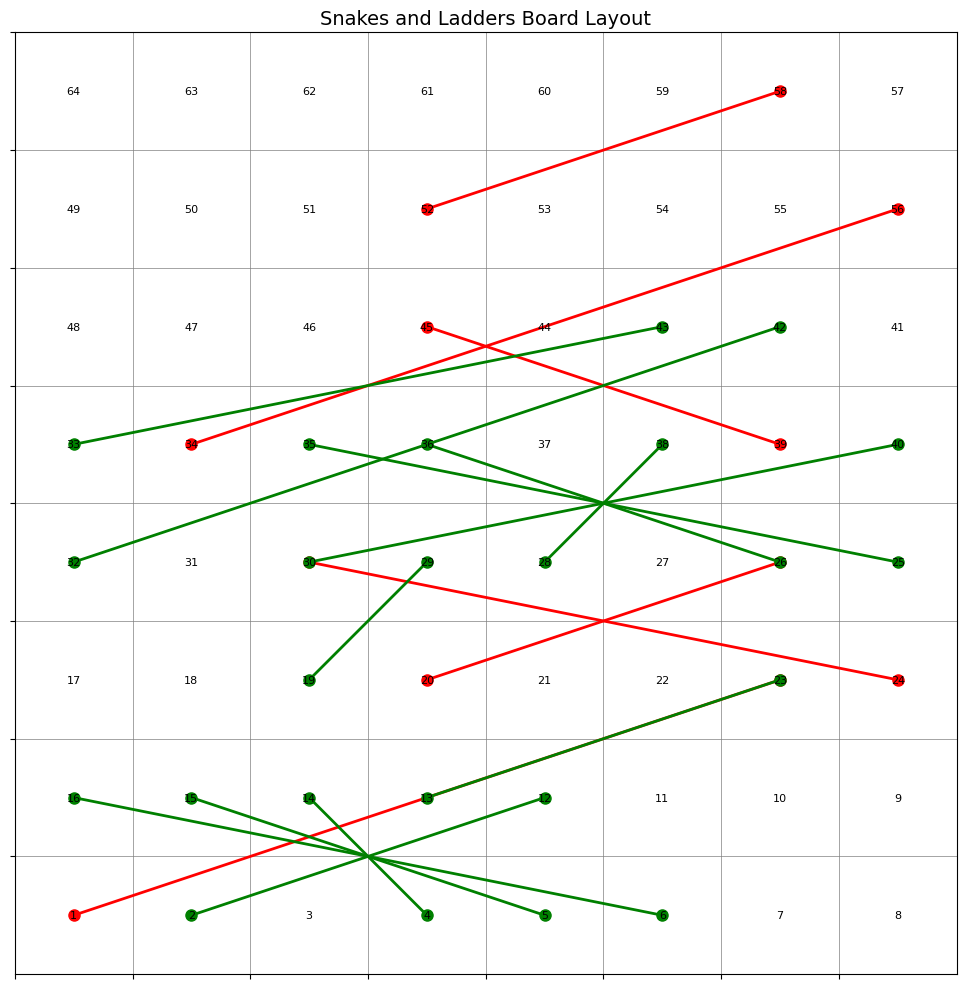

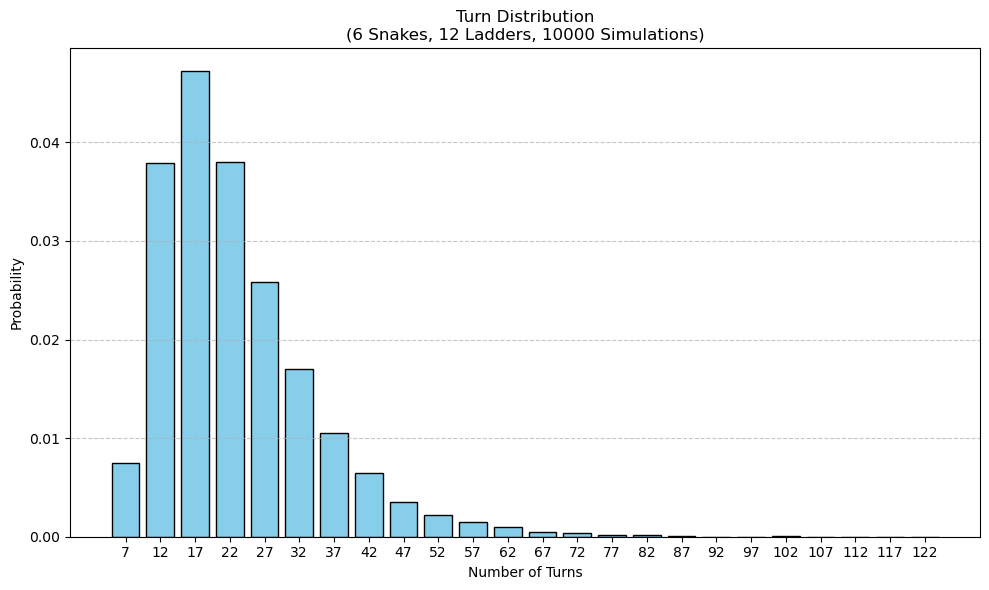

  Simulating with 6 snakes, 6 ladders (Ns/Nl ratio: 1.0)


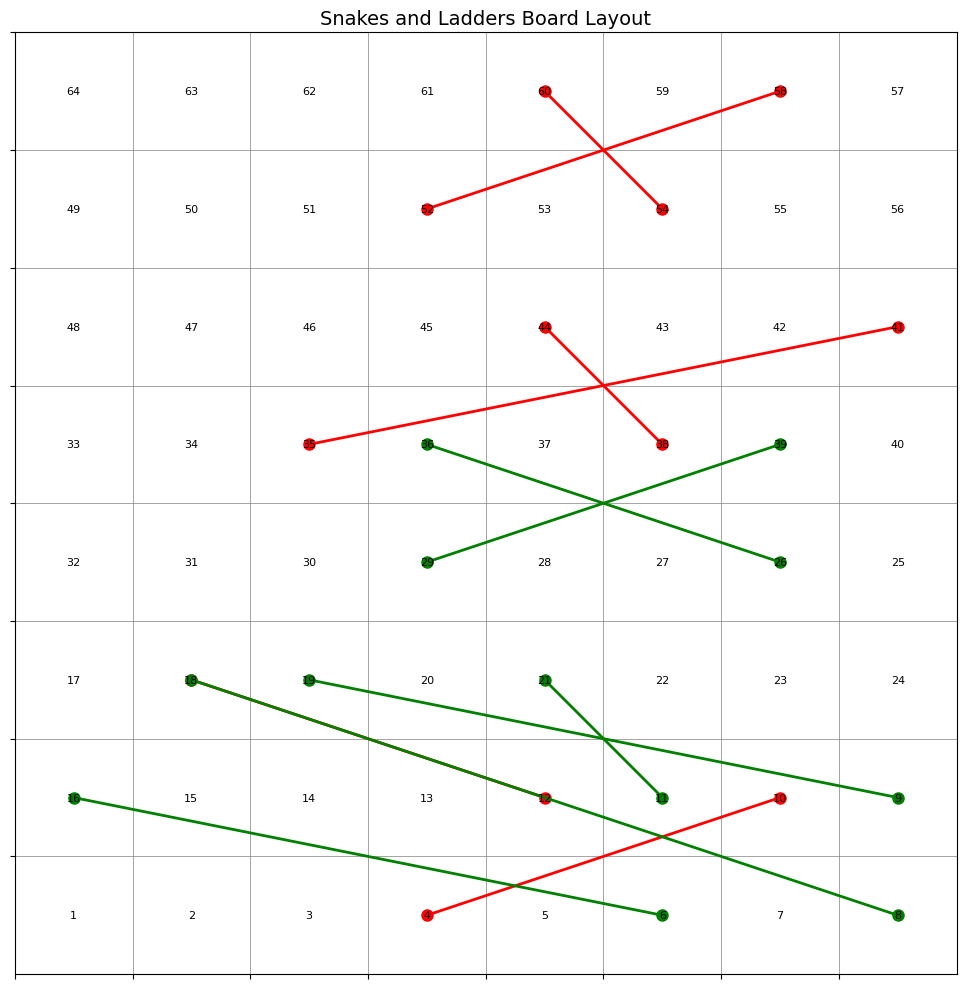

  Simulating with 6 snakes, 4 ladders (Ns/Nl ratio: 1.5)


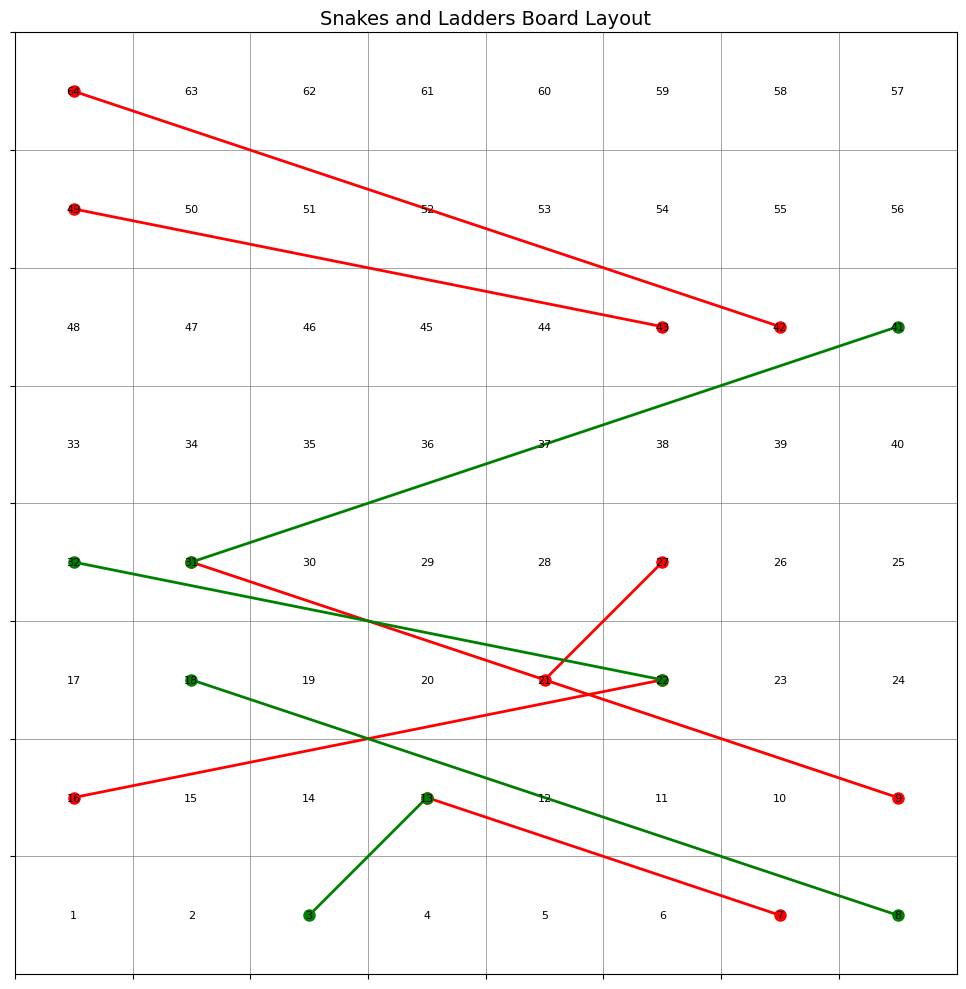

  Simulating with 6 snakes, 3 ladders (Ns/Nl ratio: 2.0)


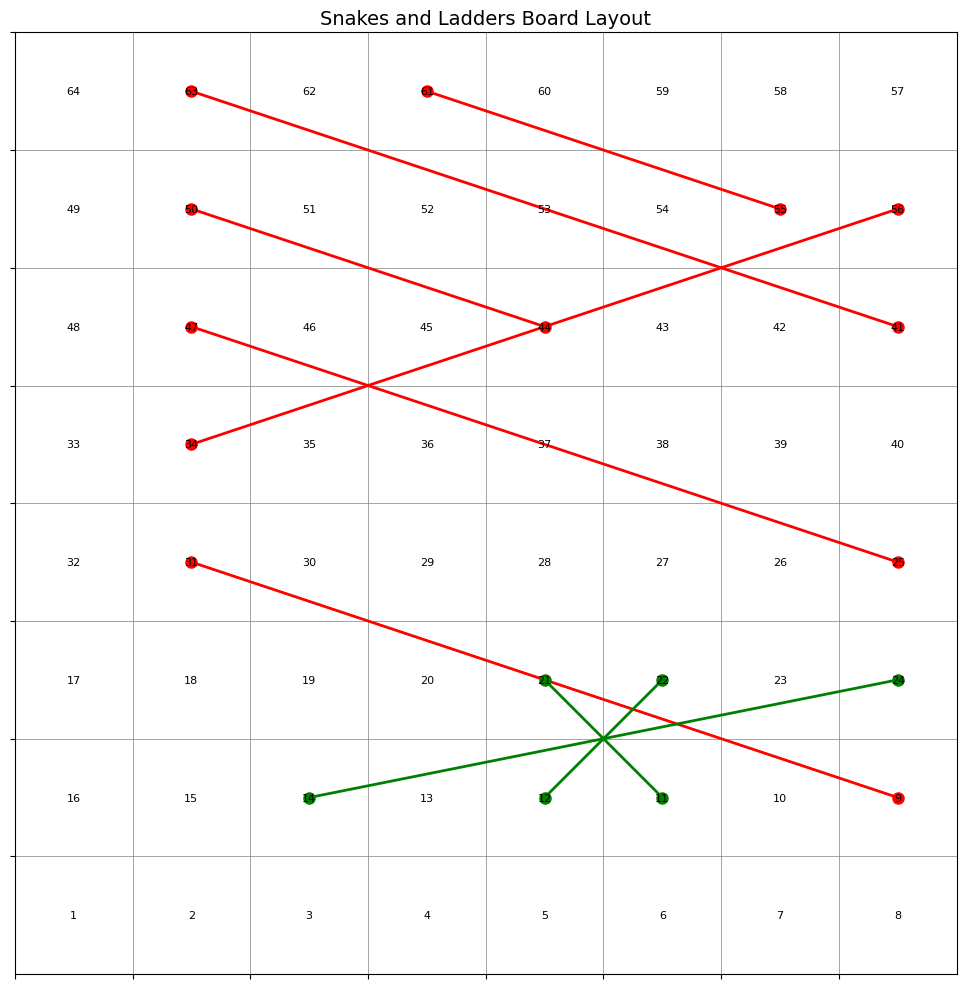


--- Board Size: 10x10 ---
  Simulating with 10 snakes, 20 ladders (Ns/Nl ratio: 0.5)


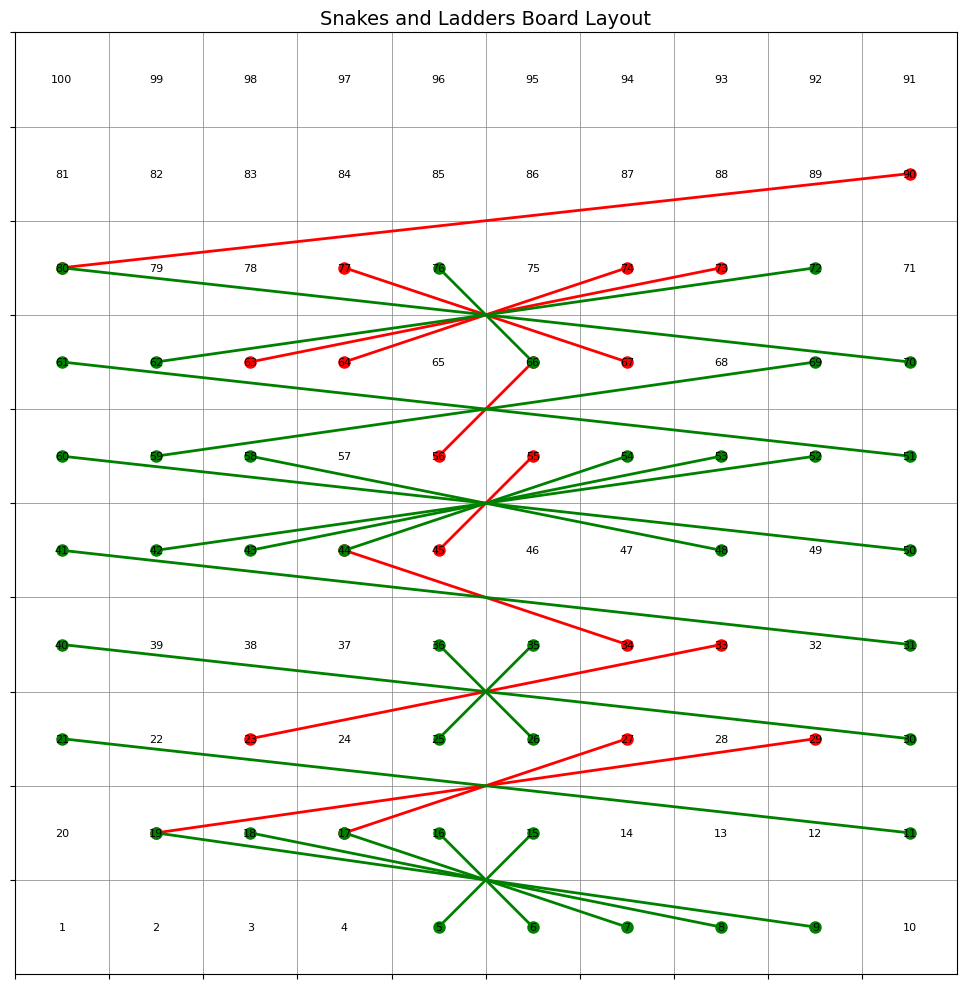

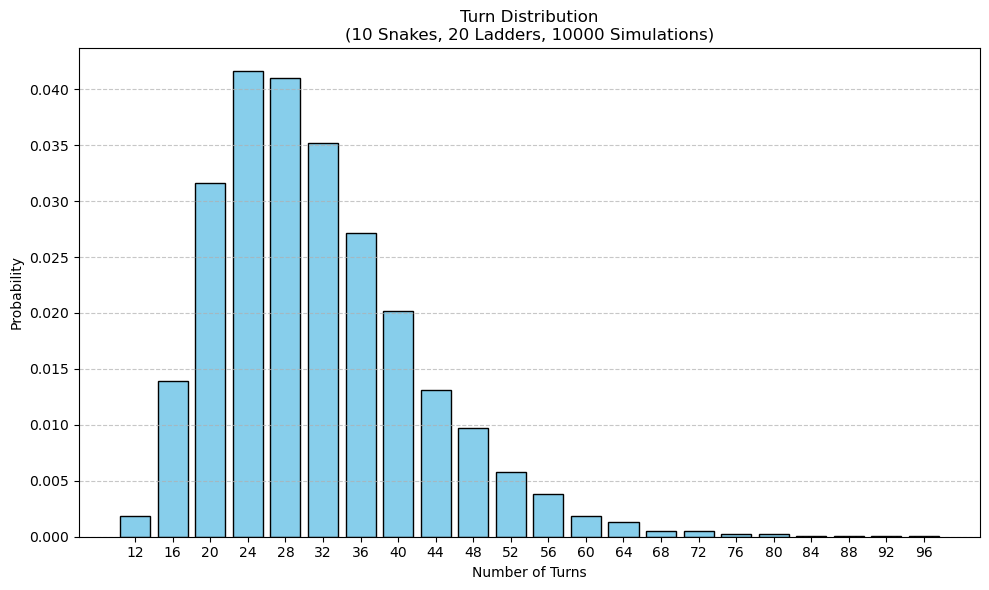

  Simulating with 10 snakes, 10 ladders (Ns/Nl ratio: 1.0)


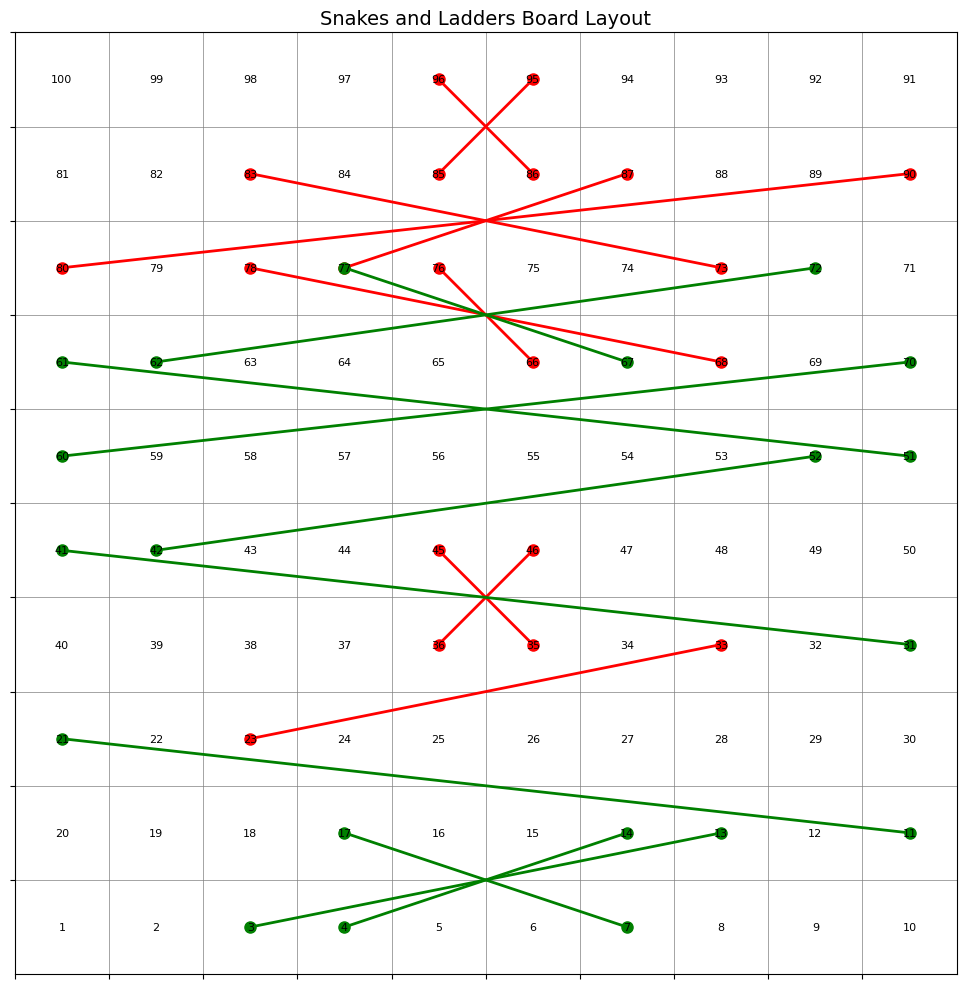

  Simulating with 10 snakes, 6 ladders (Ns/Nl ratio: 1.5)


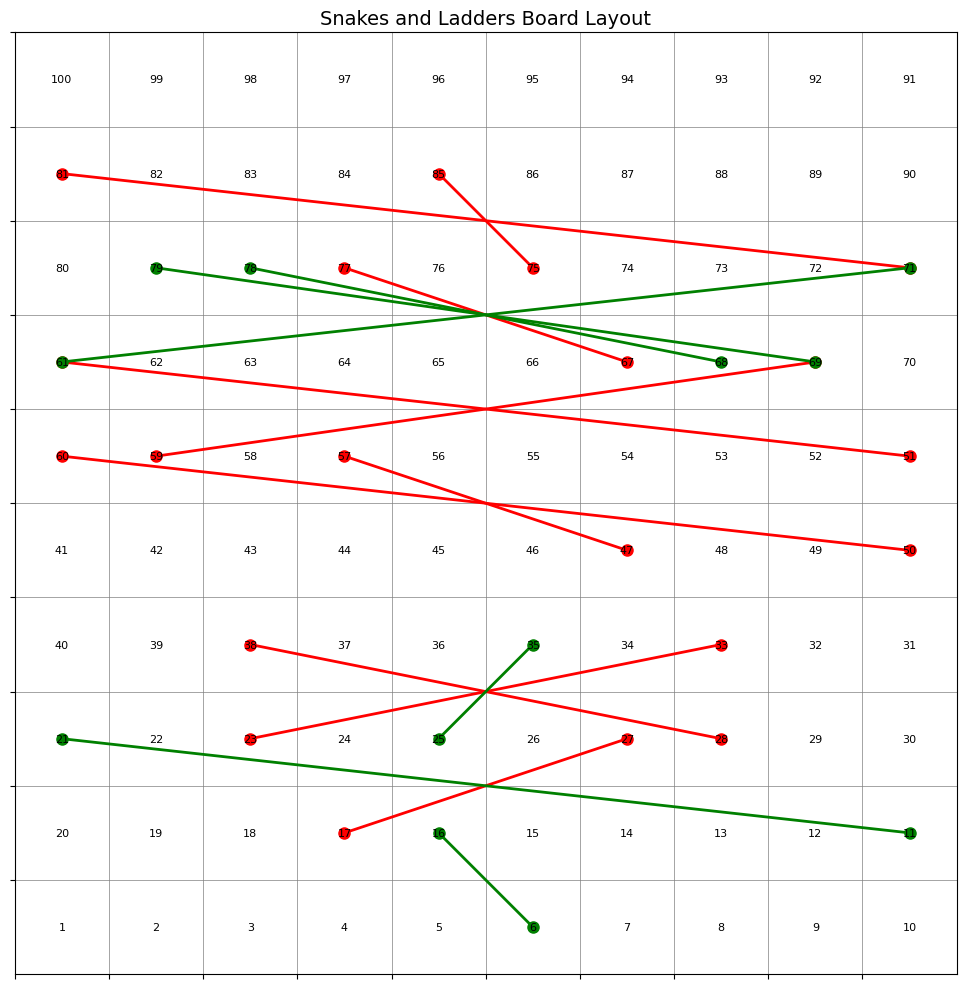

  Simulating with 10 snakes, 5 ladders (Ns/Nl ratio: 2.0)


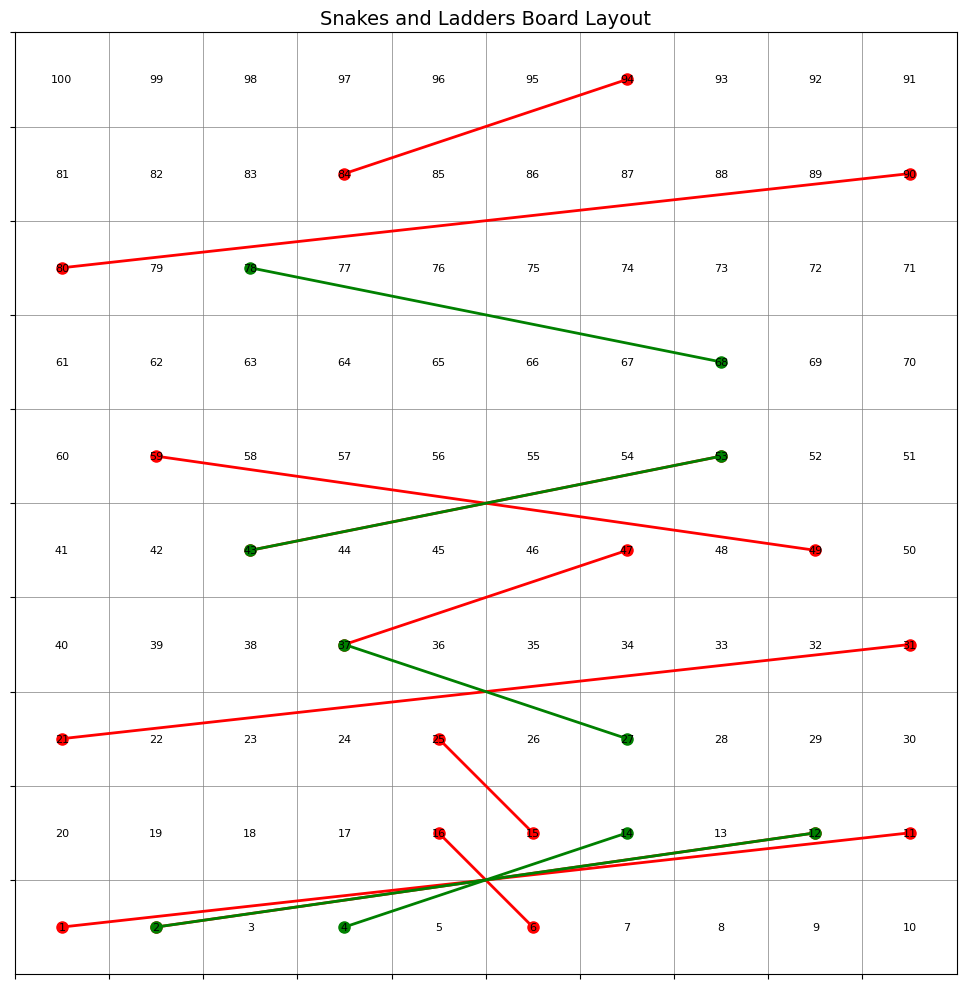


--- Board Size: 12x12 ---
  Simulating with 14 snakes, 28 ladders (Ns/Nl ratio: 0.5)


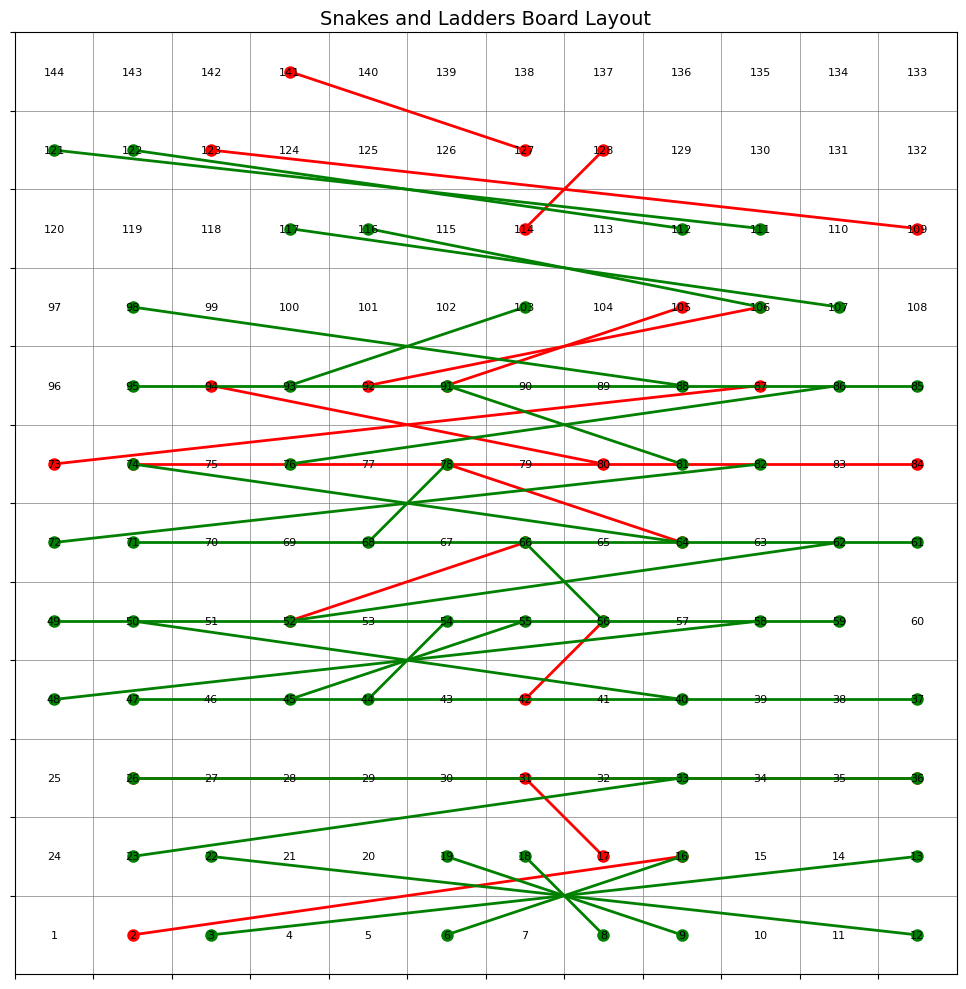

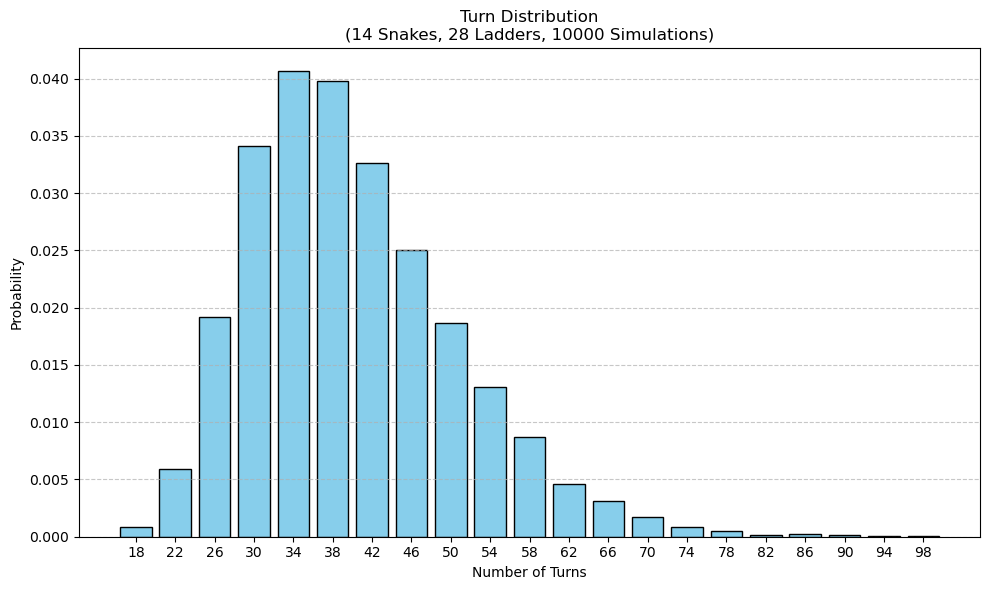

  Simulating with 14 snakes, 14 ladders (Ns/Nl ratio: 1.0)


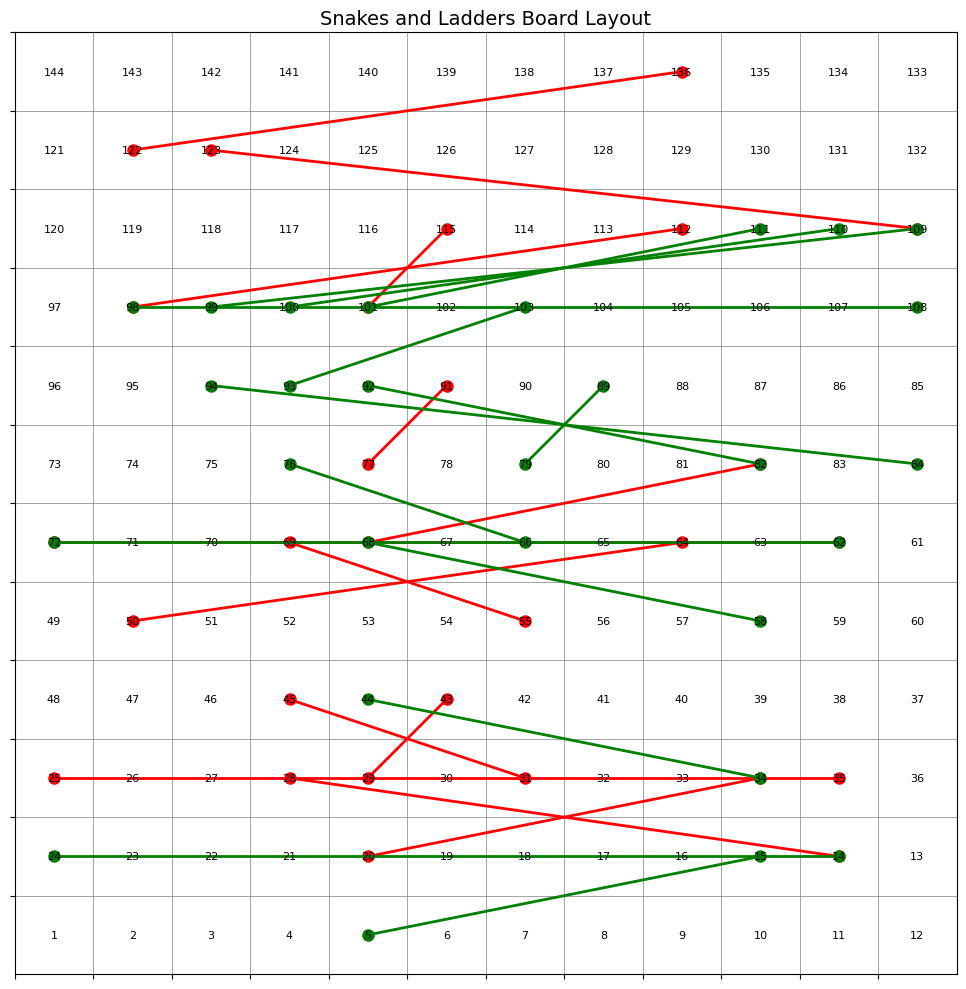

  Simulating with 14 snakes, 9 ladders (Ns/Nl ratio: 1.5)


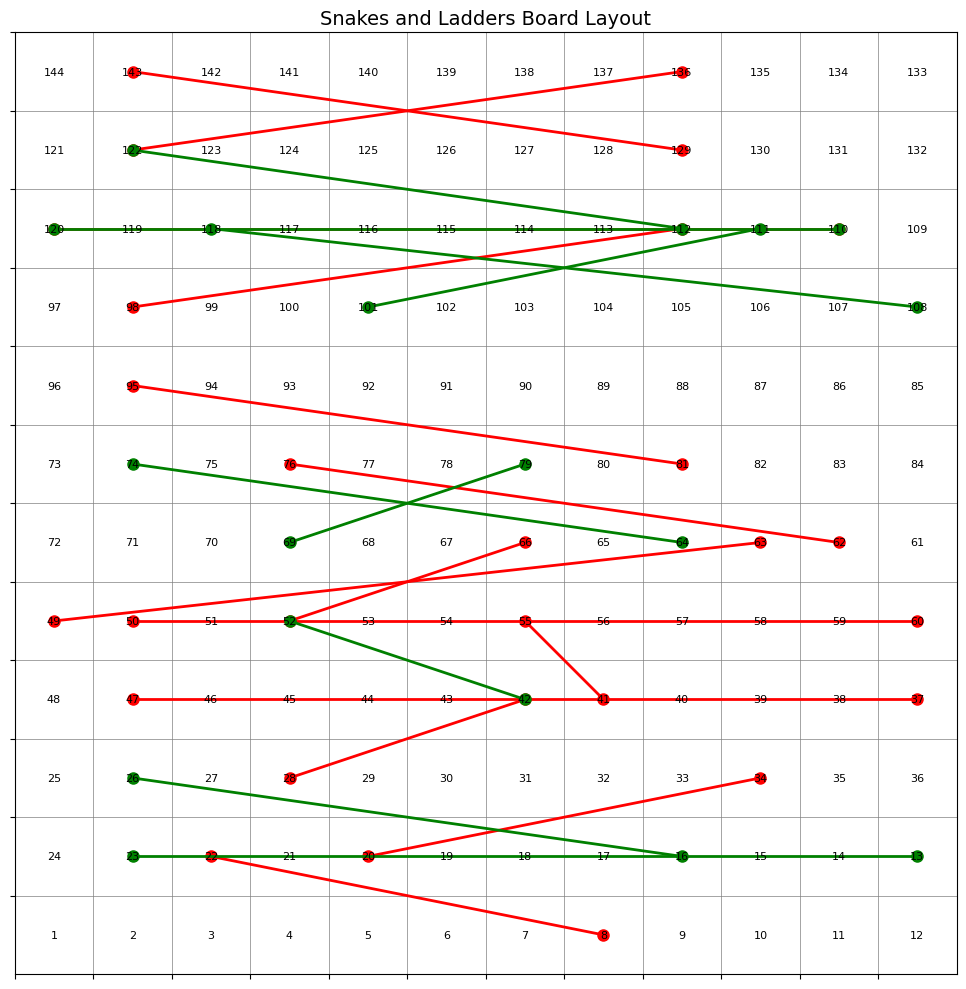

  Simulating with 14 snakes, 7 ladders (Ns/Nl ratio: 2.0)


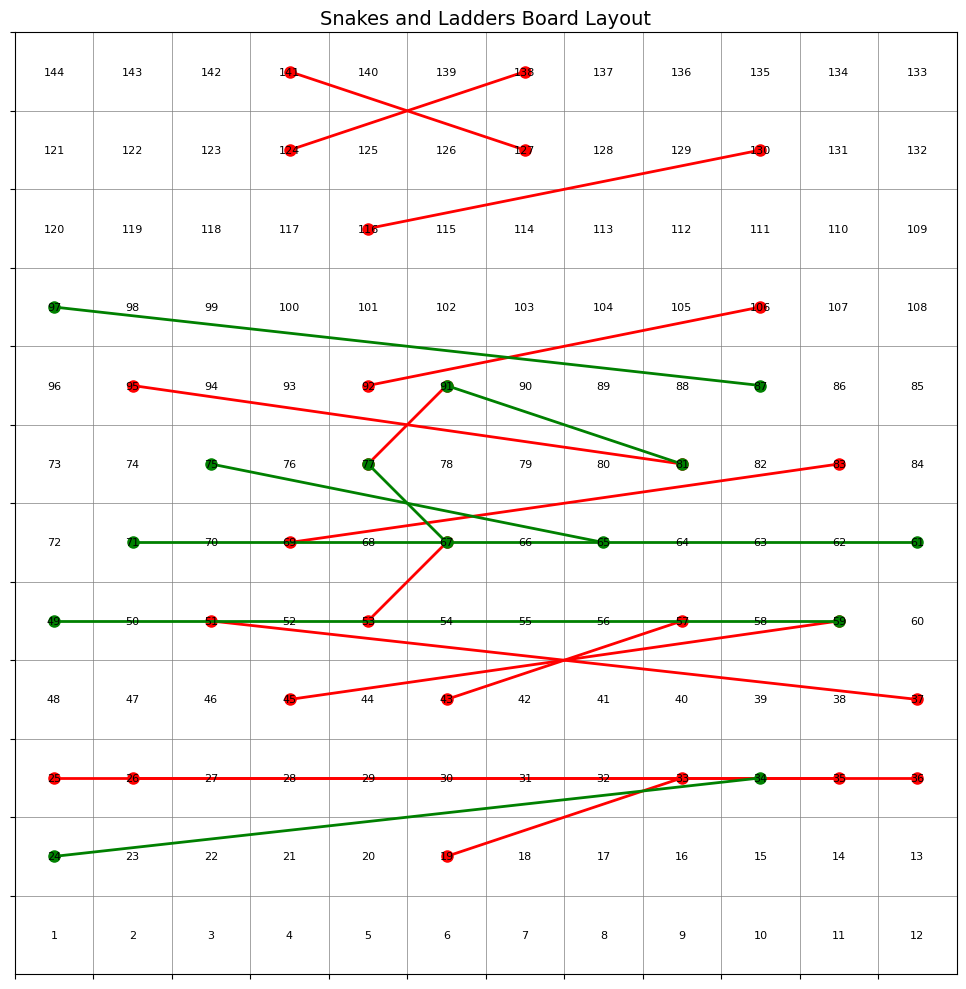


--- Board Size: 14x14 ---
  Simulating with 19 snakes, 38 ladders (Ns/Nl ratio: 0.5)


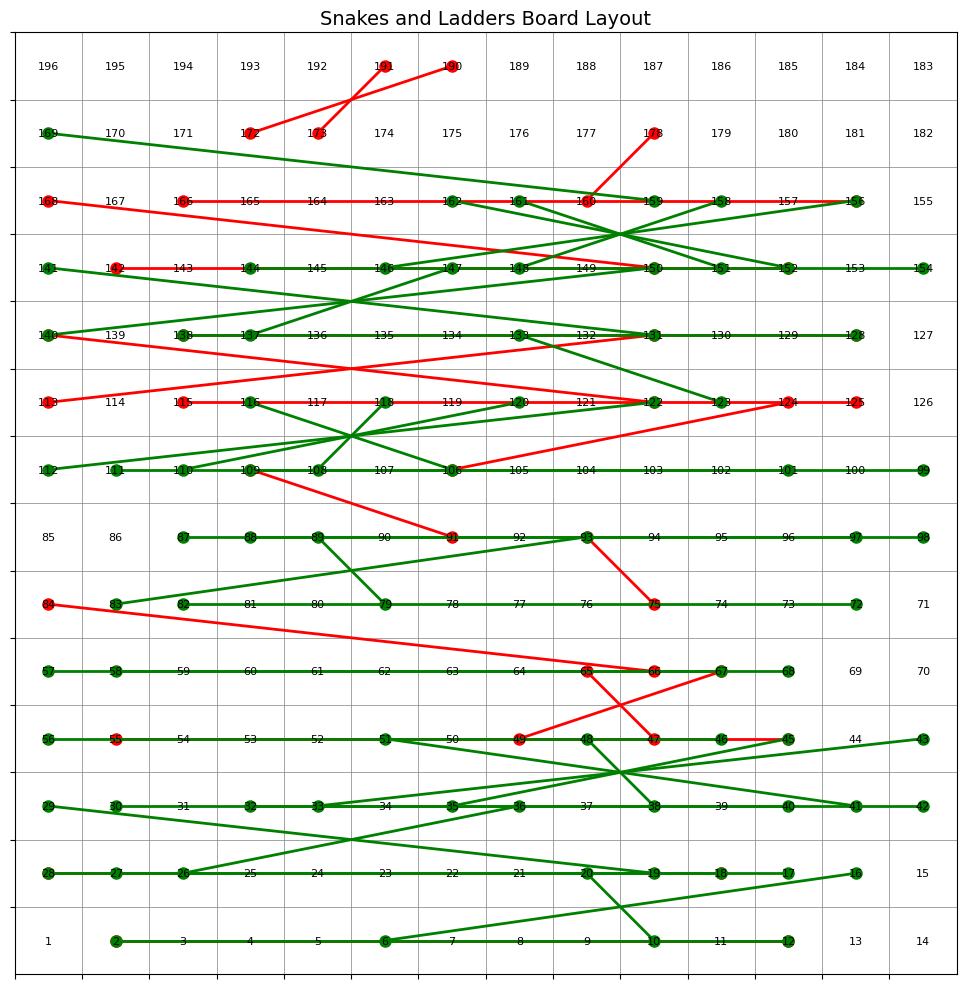

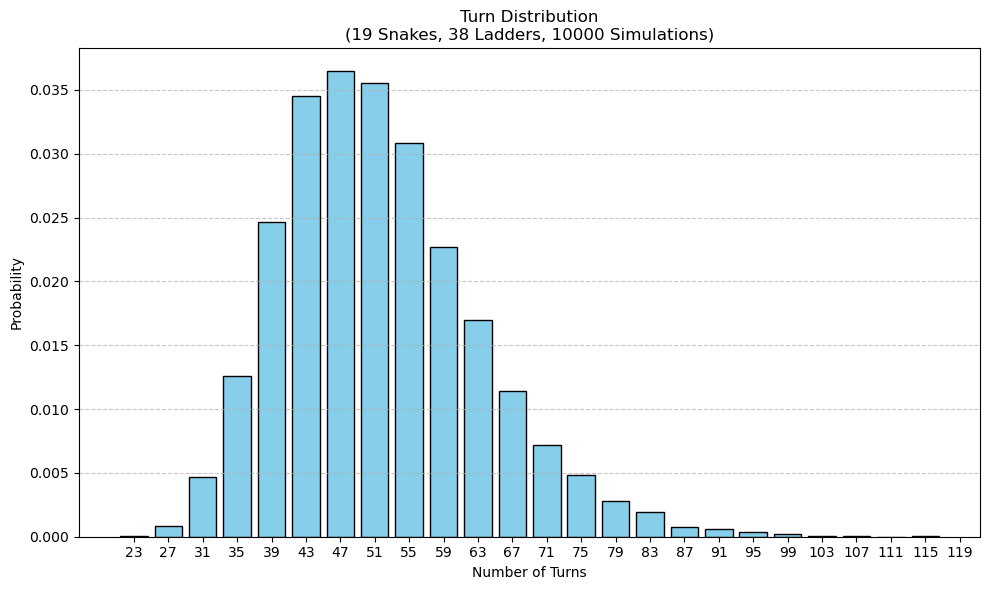

  Simulating with 19 snakes, 19 ladders (Ns/Nl ratio: 1.0)


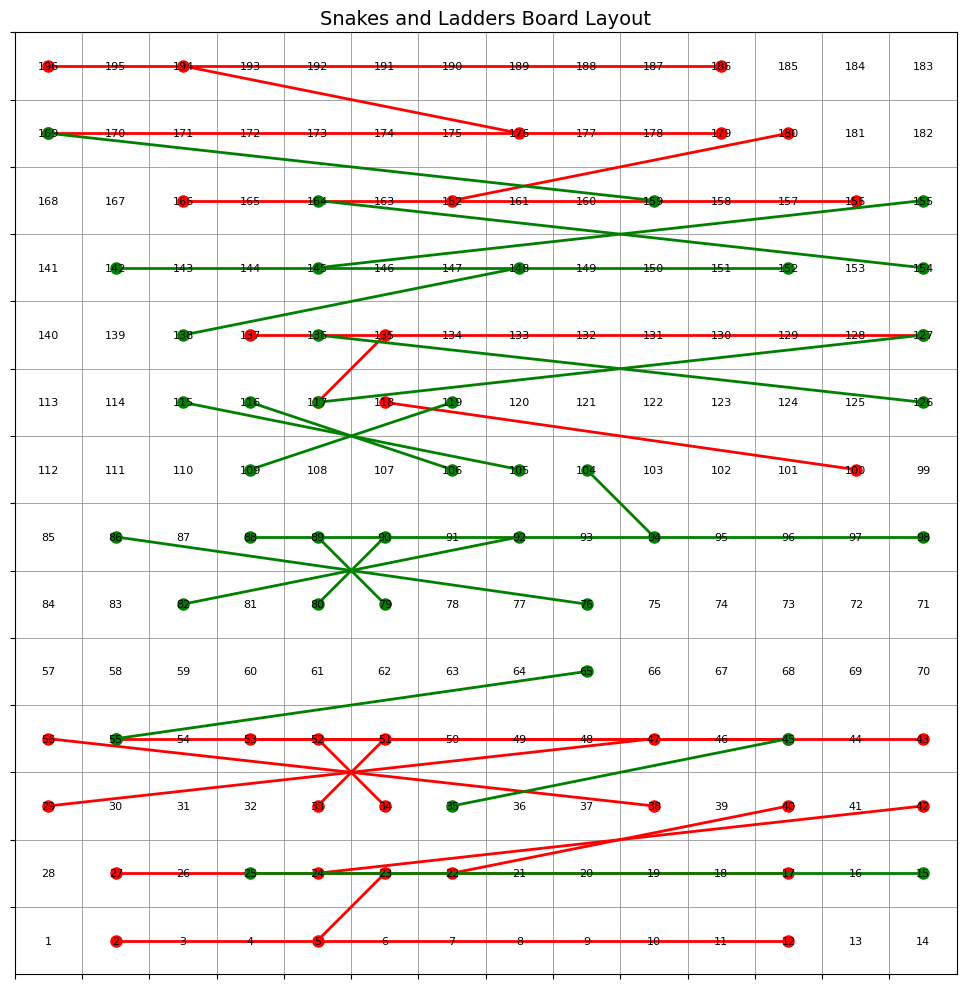

  Simulating with 19 snakes, 12 ladders (Ns/Nl ratio: 1.5)


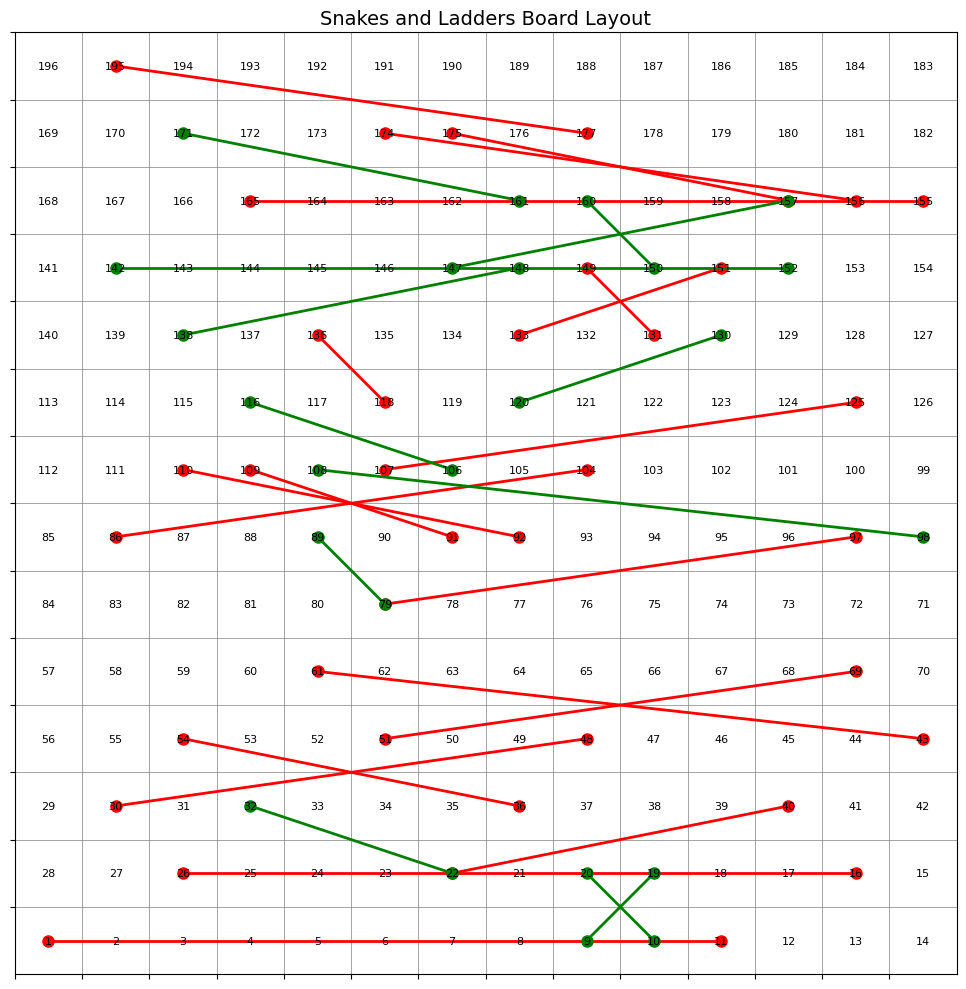

  Simulating with 19 snakes, 9 ladders (Ns/Nl ratio: 2.0)


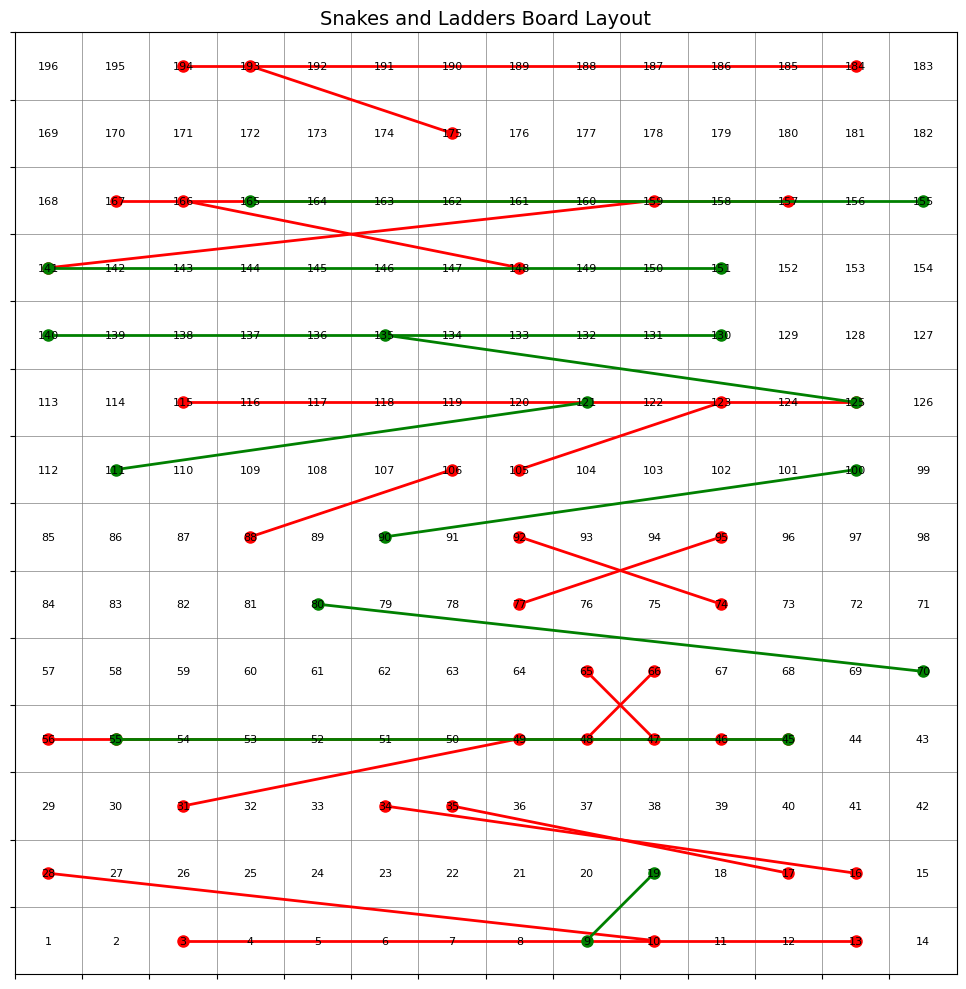


--- Board Size: 16x16 ---
  Simulating with 25 snakes, 50 ladders (Ns/Nl ratio: 0.5)


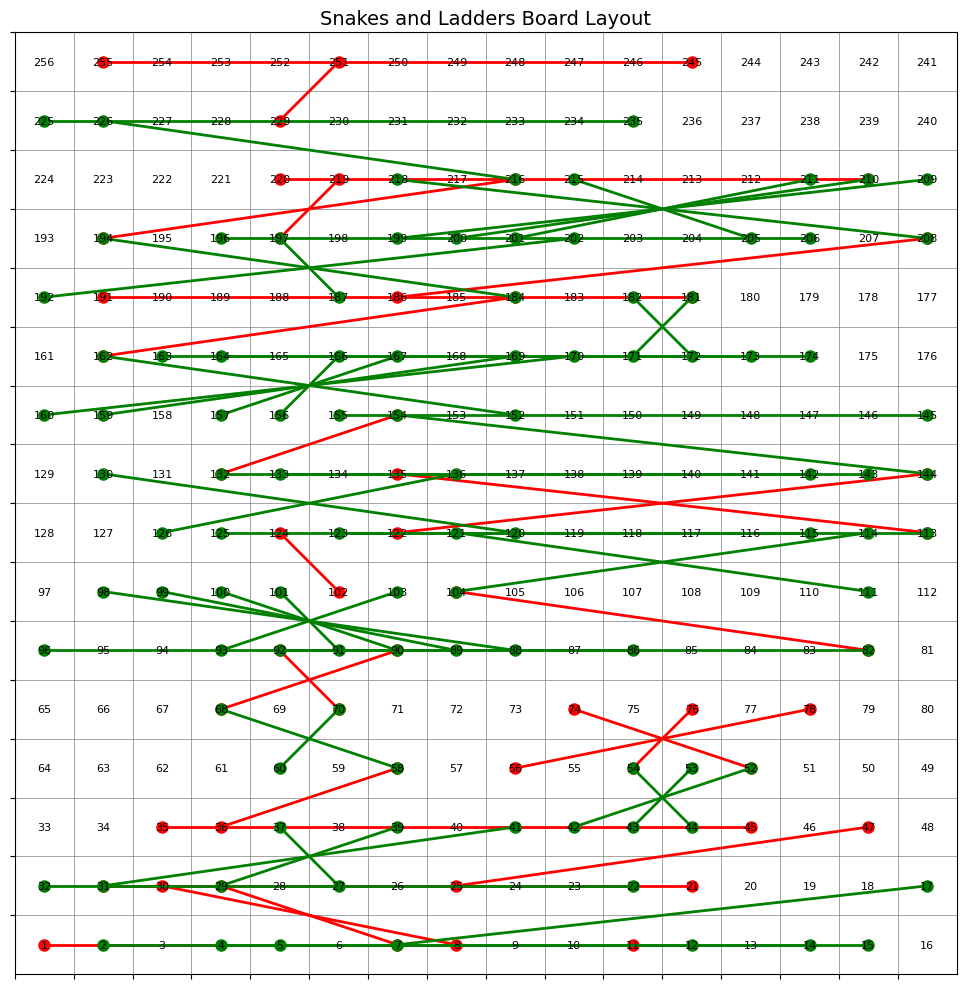

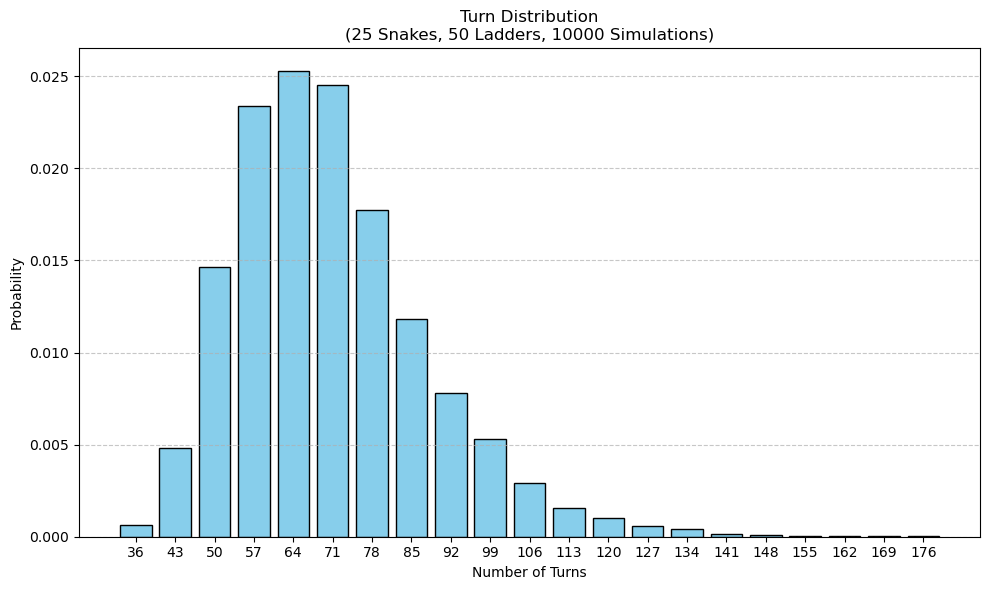

  Simulating with 25 snakes, 25 ladders (Ns/Nl ratio: 1.0)


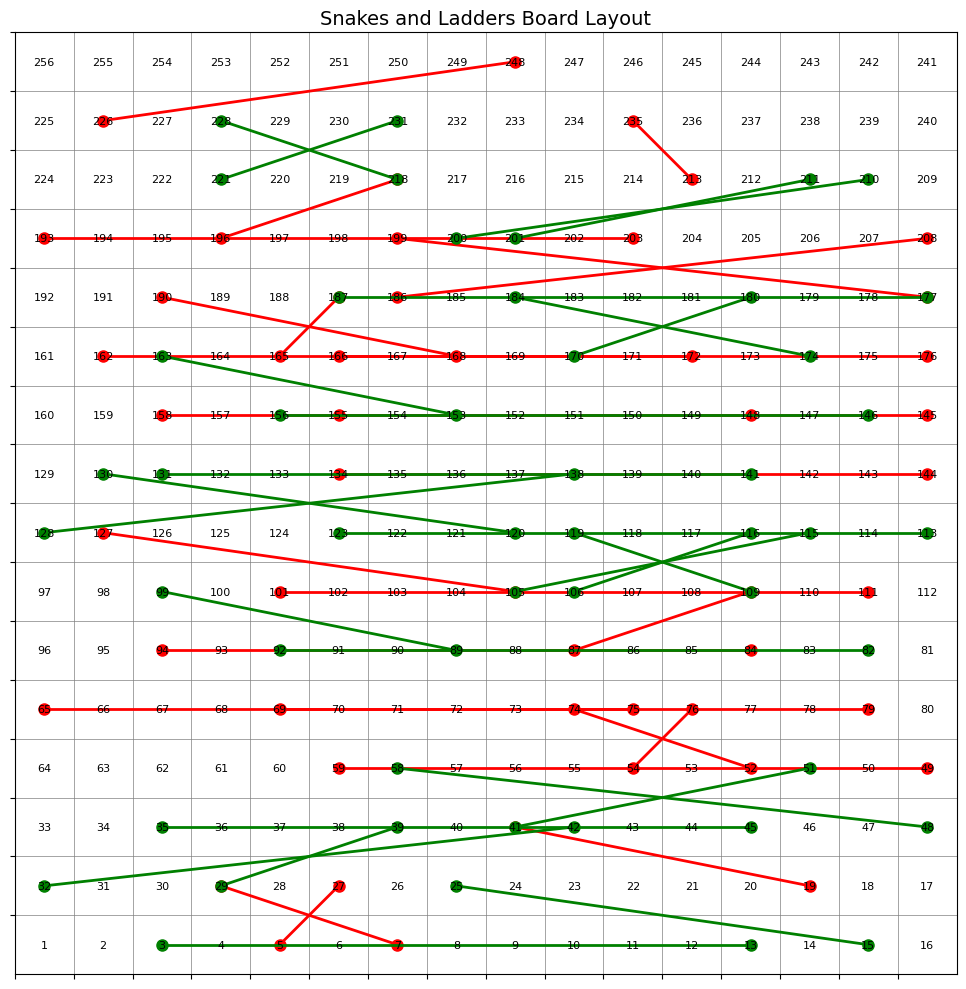

  Simulating with 25 snakes, 16 ladders (Ns/Nl ratio: 1.5)


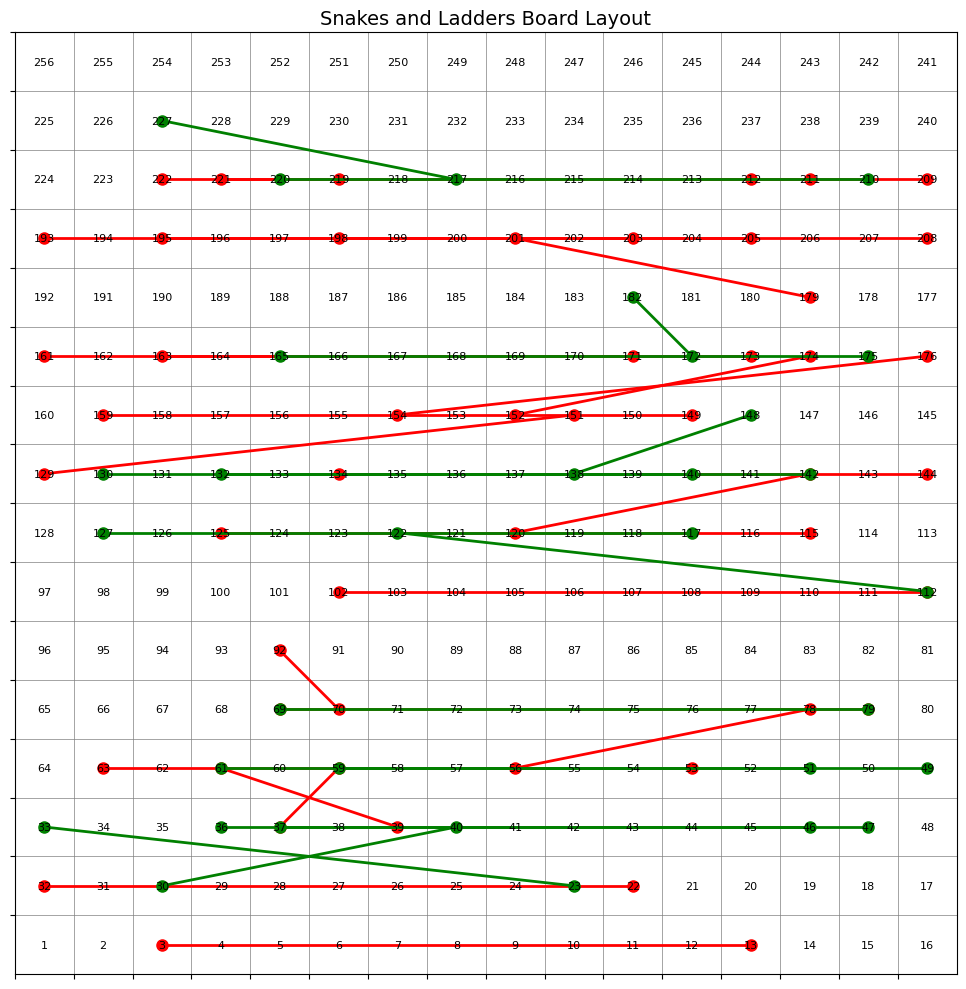

  Simulating with 25 snakes, 12 ladders (Ns/Nl ratio: 2.0)


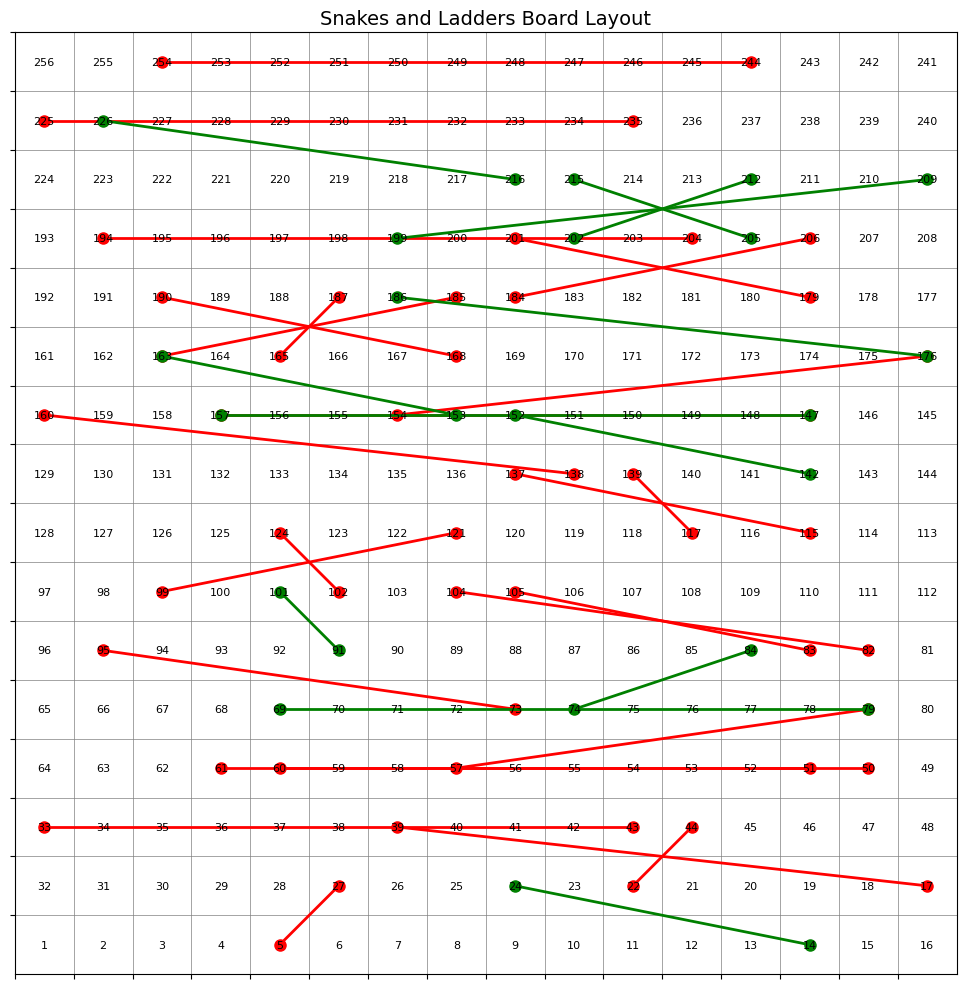


--- Board Size: 18x18 ---
  Simulating with 32 snakes, 64 ladders (Ns/Nl ratio: 0.5)


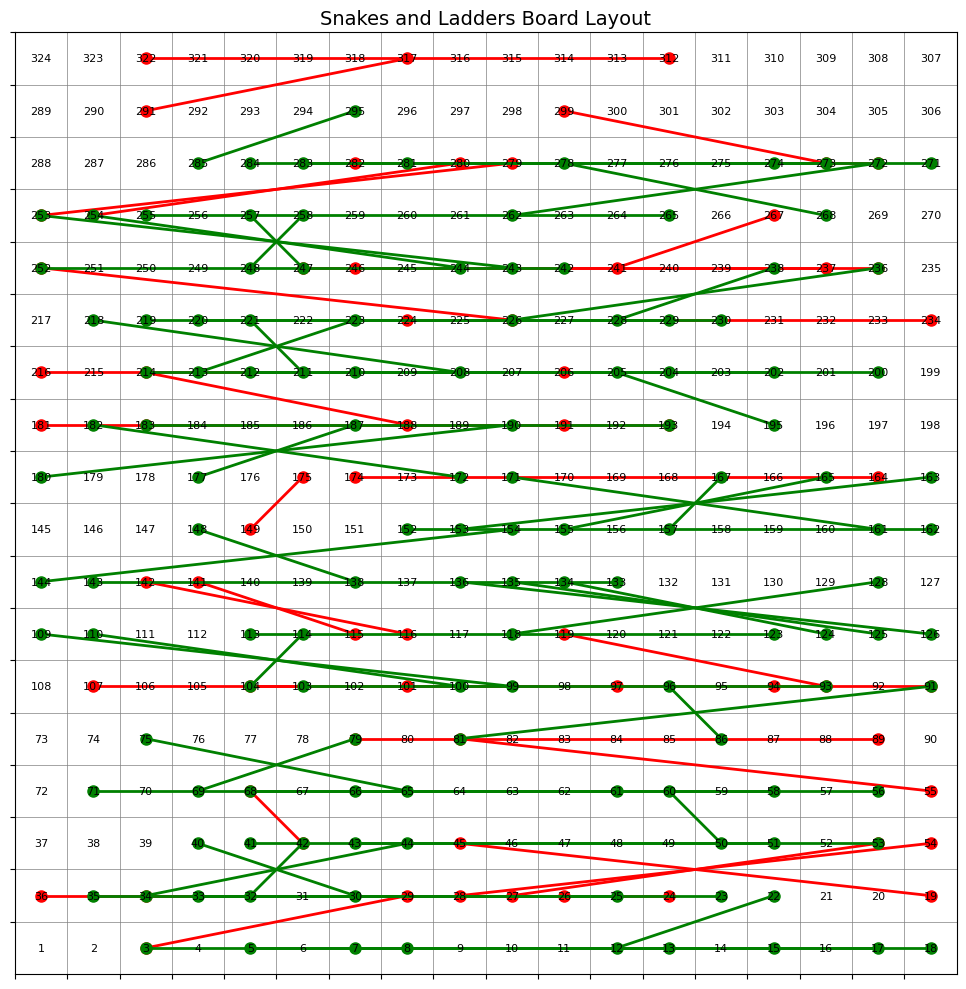

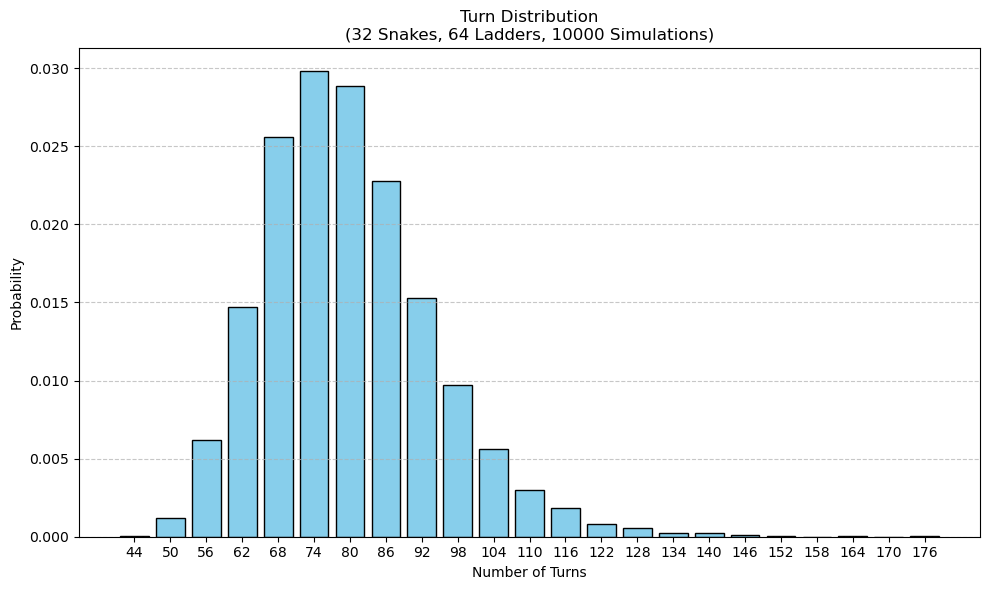

  Simulating with 32 snakes, 32 ladders (Ns/Nl ratio: 1.0)


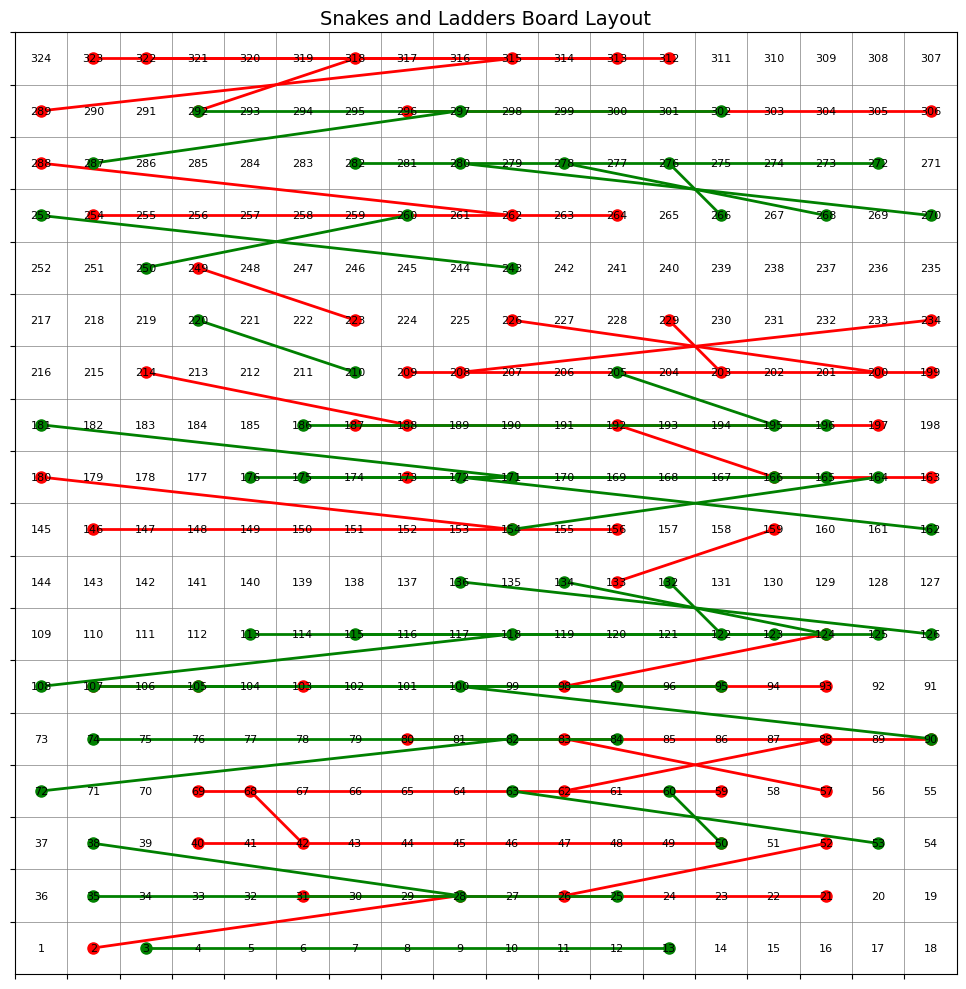

  Simulating with 32 snakes, 21 ladders (Ns/Nl ratio: 1.5)


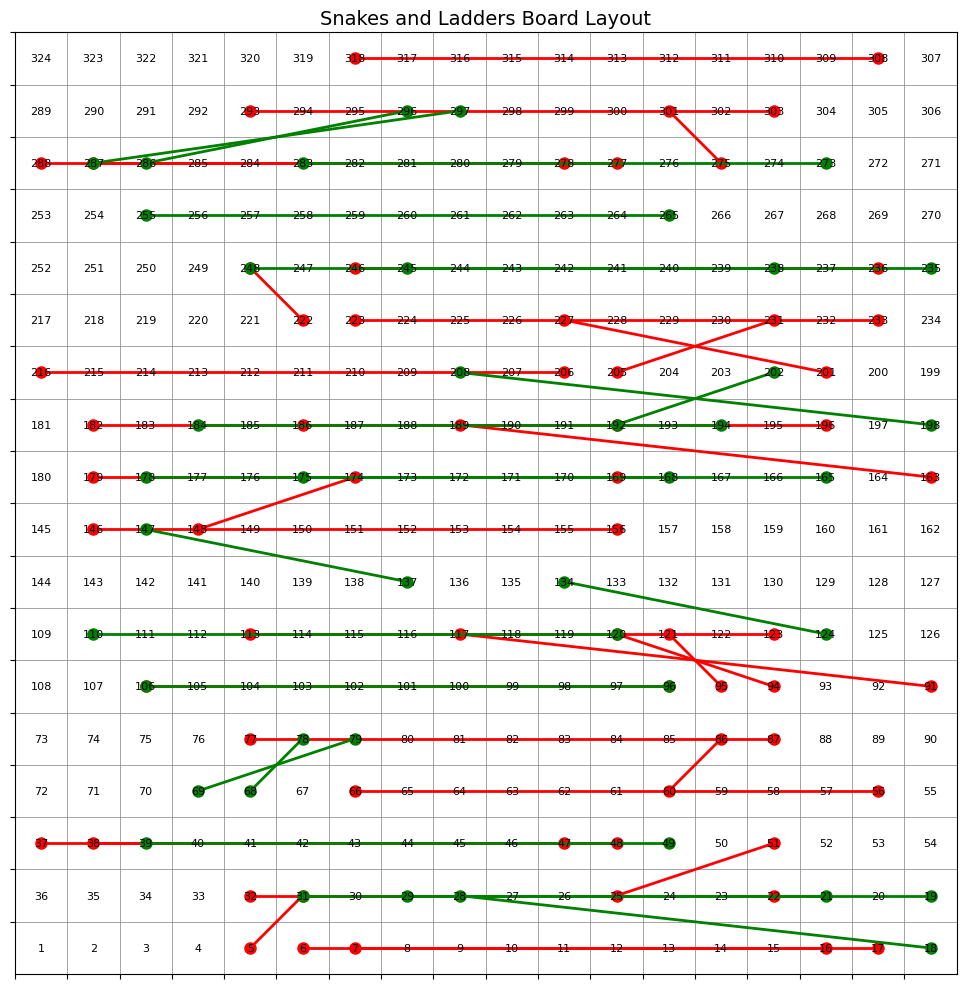

  Simulating with 32 snakes, 16 ladders (Ns/Nl ratio: 2.0)


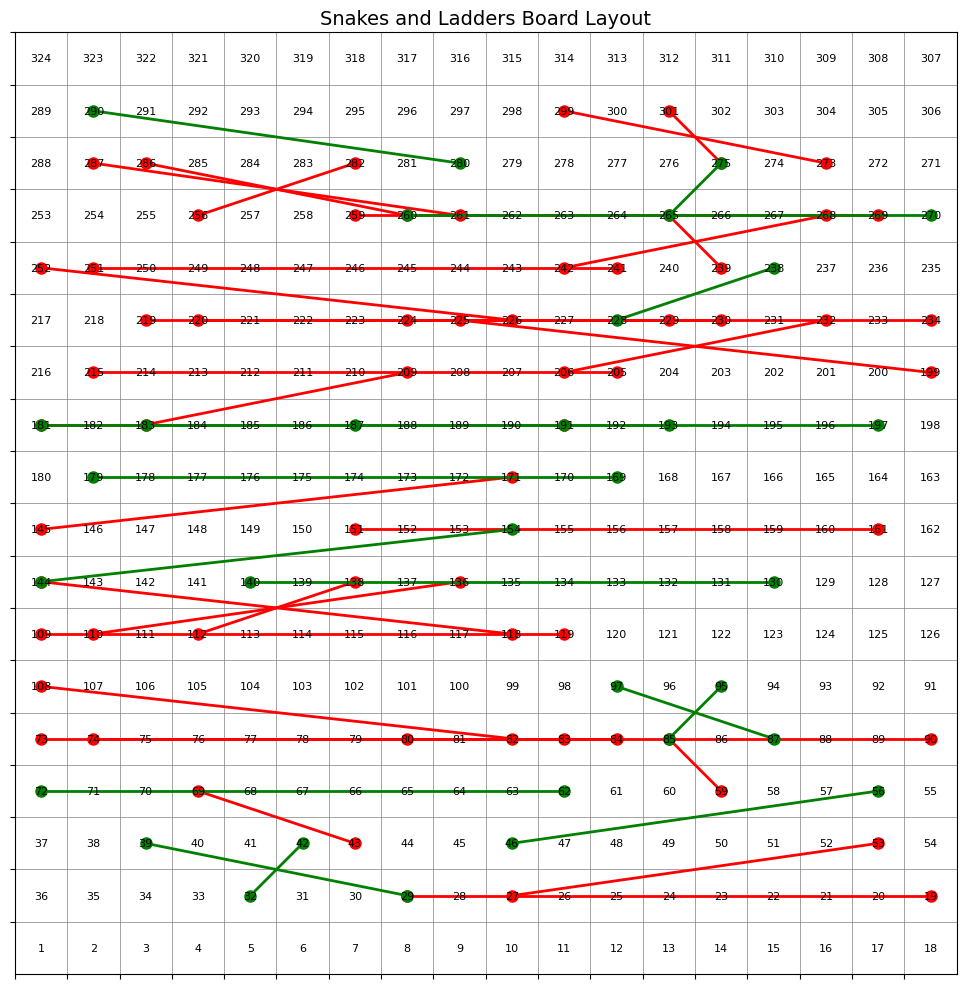


--- Board Size: 20x20 ---
  Simulating with 40 snakes, 80 ladders (Ns/Nl ratio: 0.5)


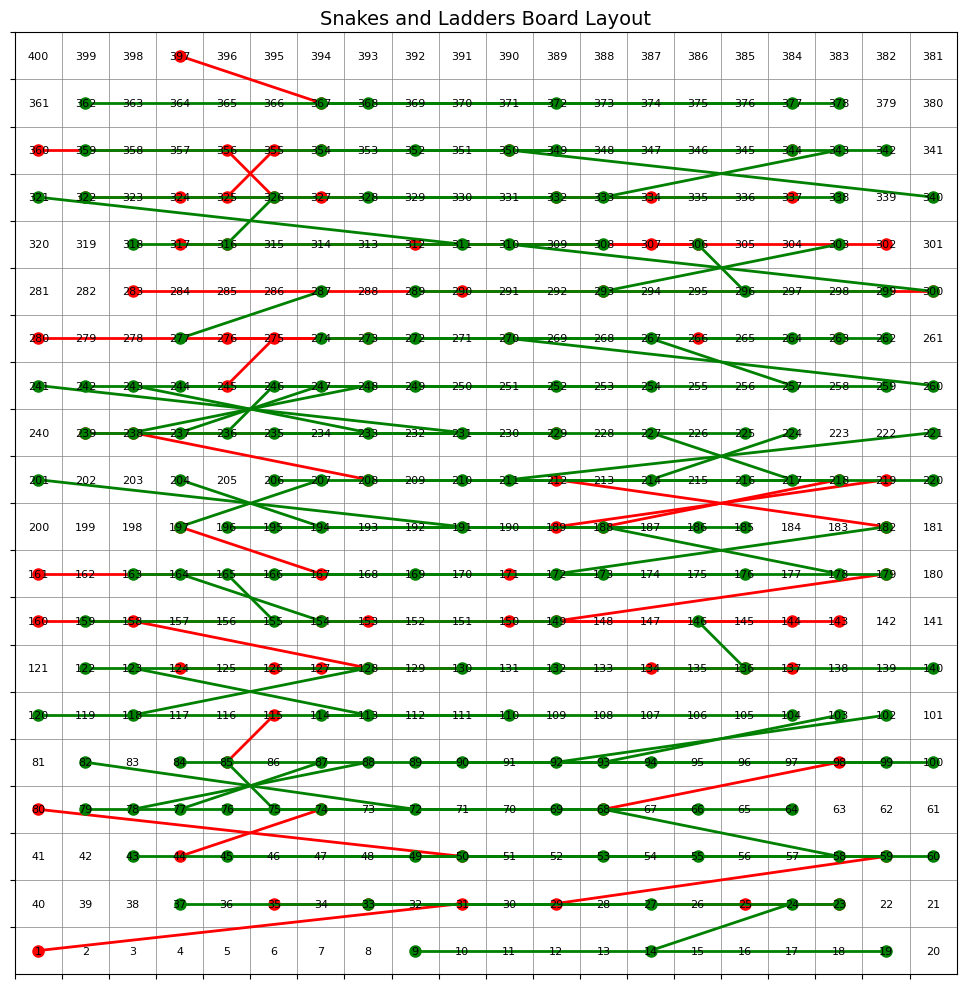

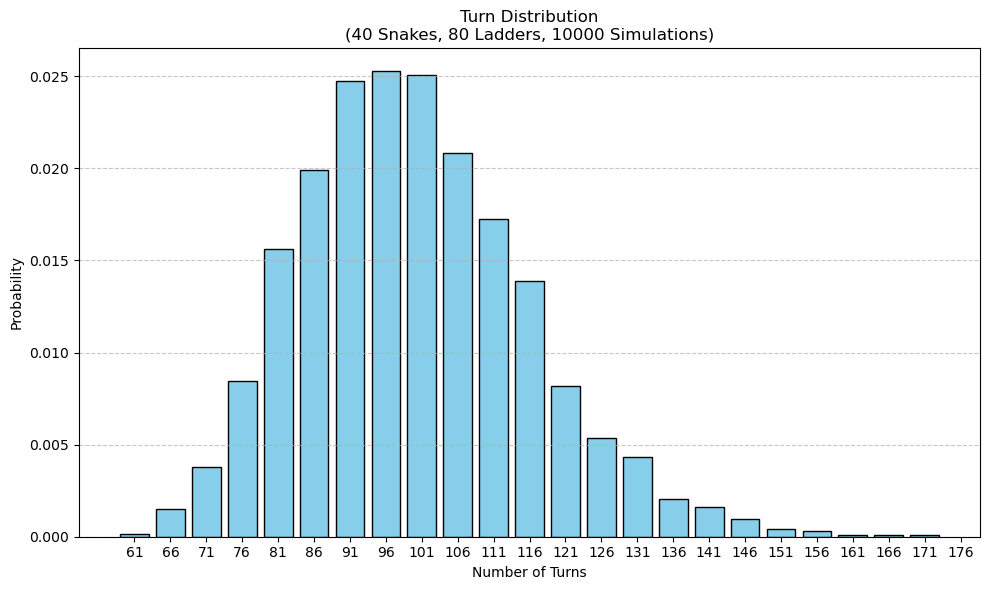

  Simulating with 40 snakes, 40 ladders (Ns/Nl ratio: 1.0)


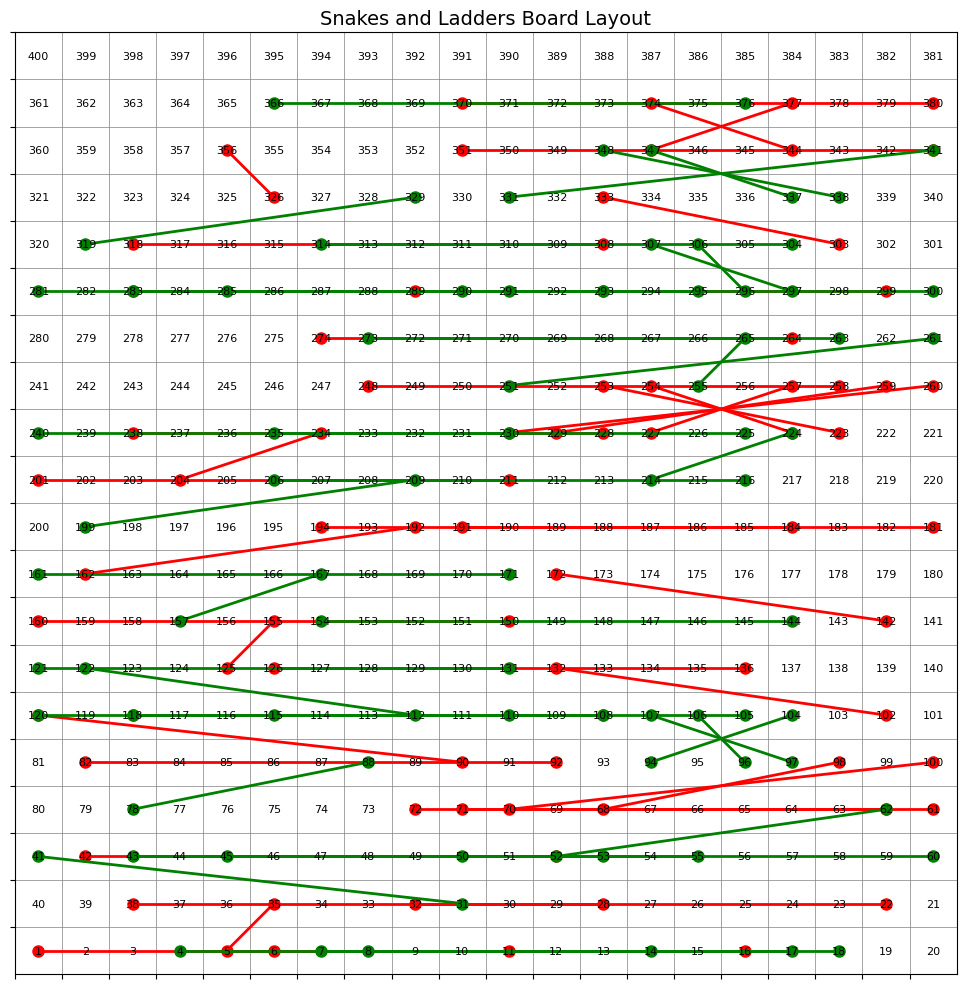

  Simulating with 40 snakes, 26 ladders (Ns/Nl ratio: 1.5)


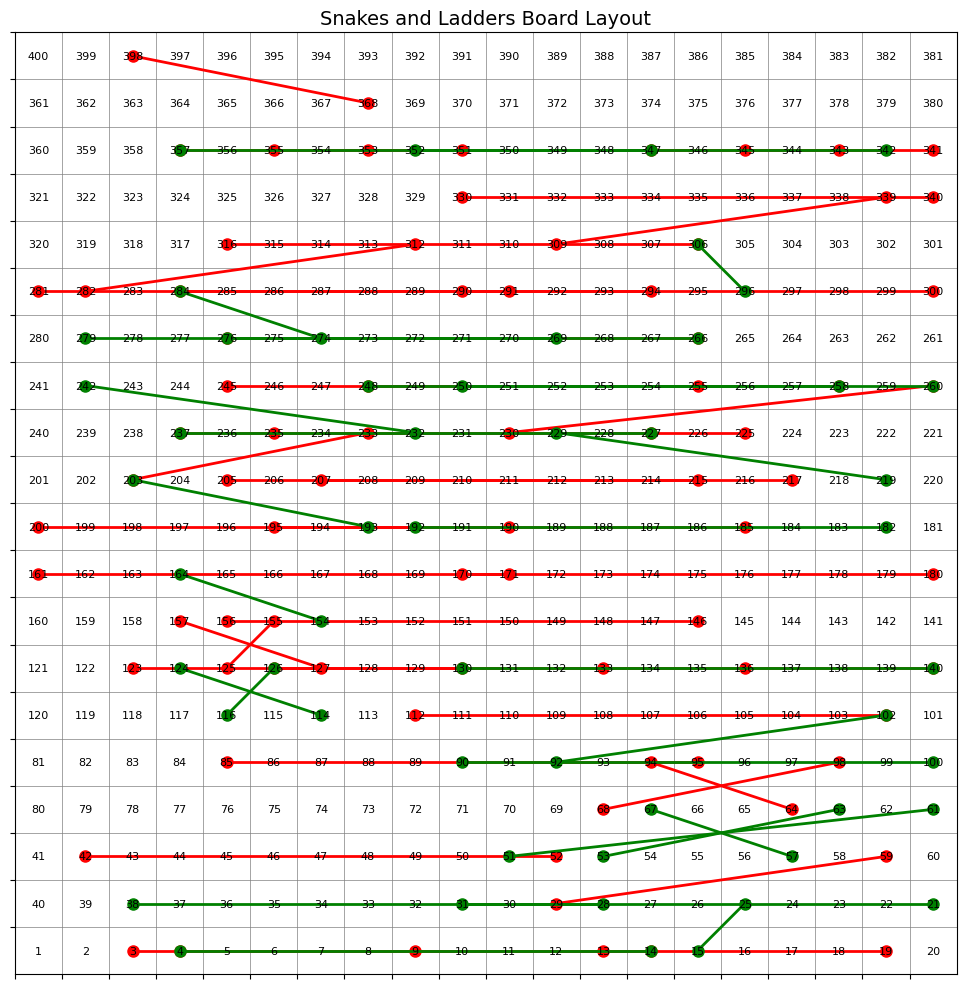

  Simulating with 40 snakes, 20 ladders (Ns/Nl ratio: 2.0)


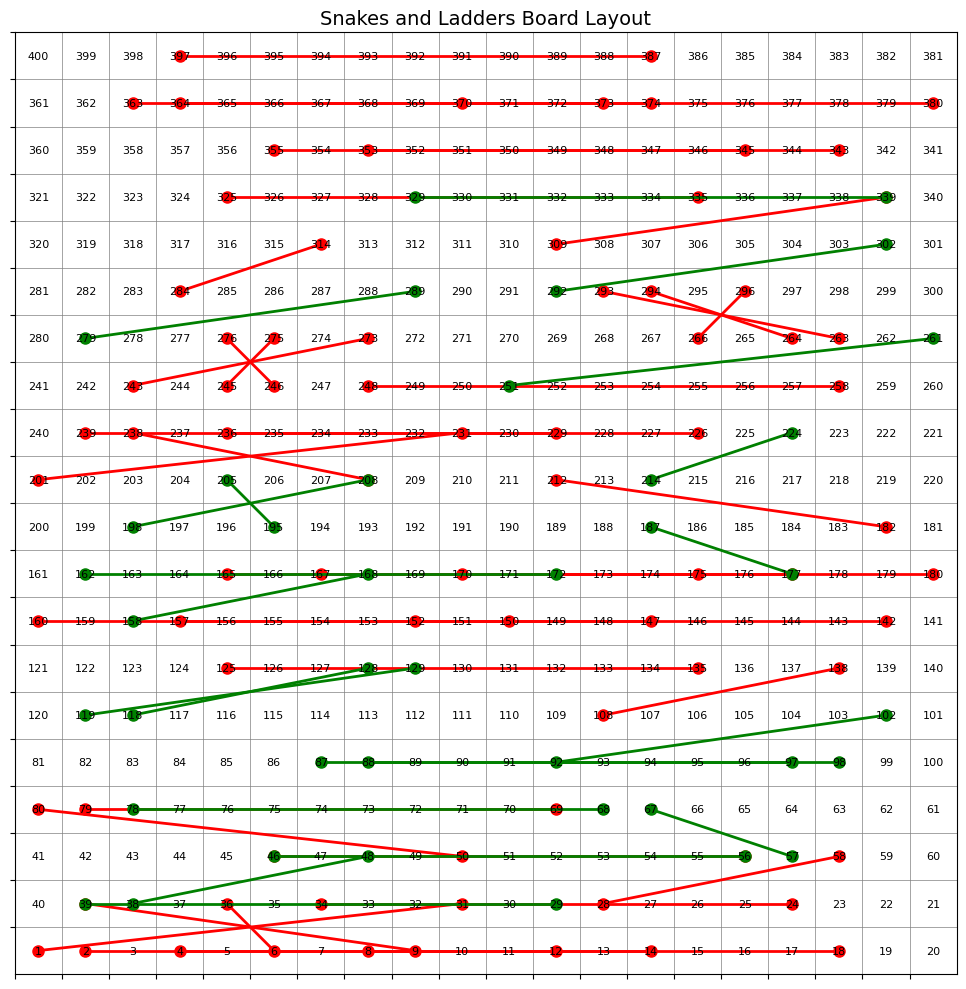


=== FIXED LADDER DENSITY SIMULATIONS ===

--- Board Size: 8x8 ---
  Simulating with 3 snakes, 6 ladders (Ns/Nl ratio: 0.5)


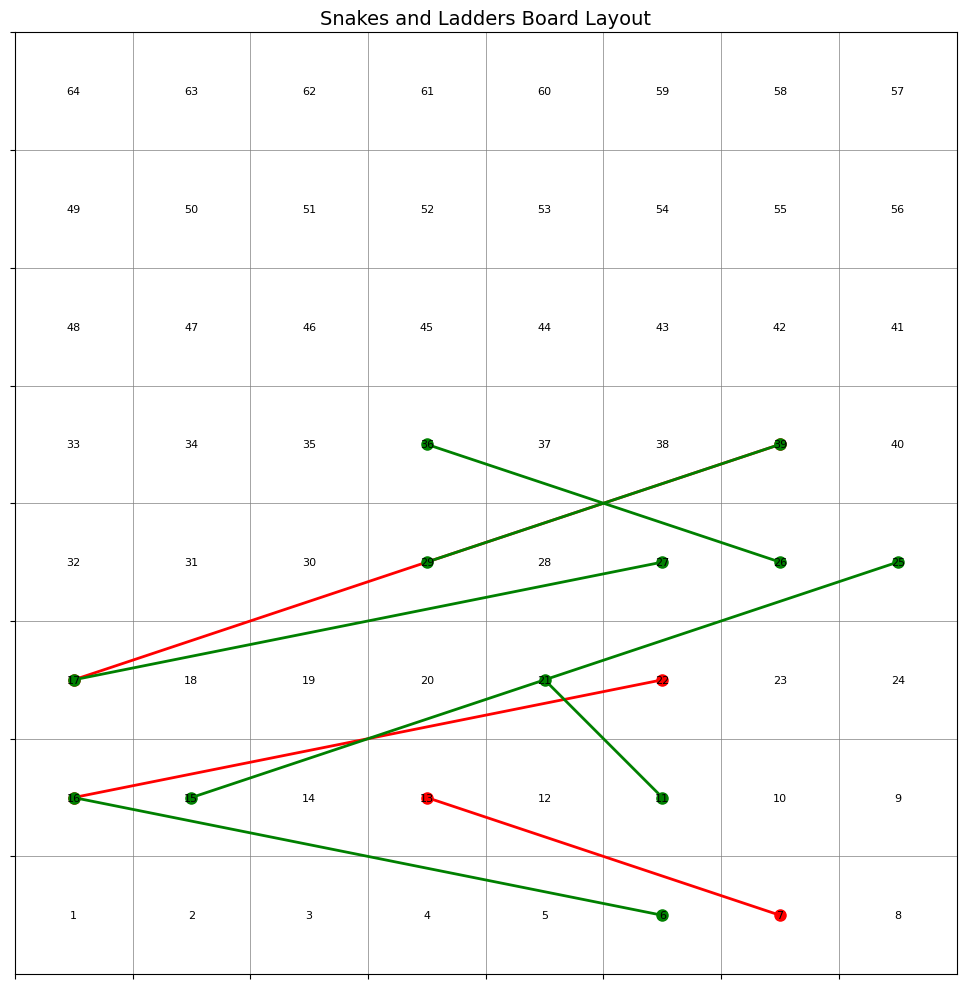

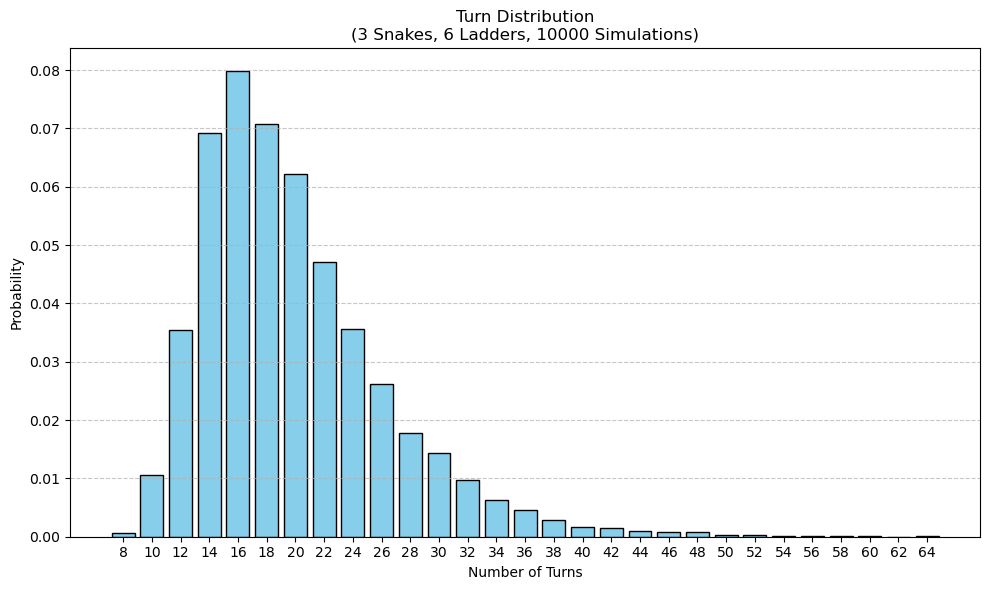

  Simulating with 6 snakes, 6 ladders (Ns/Nl ratio: 1.0)


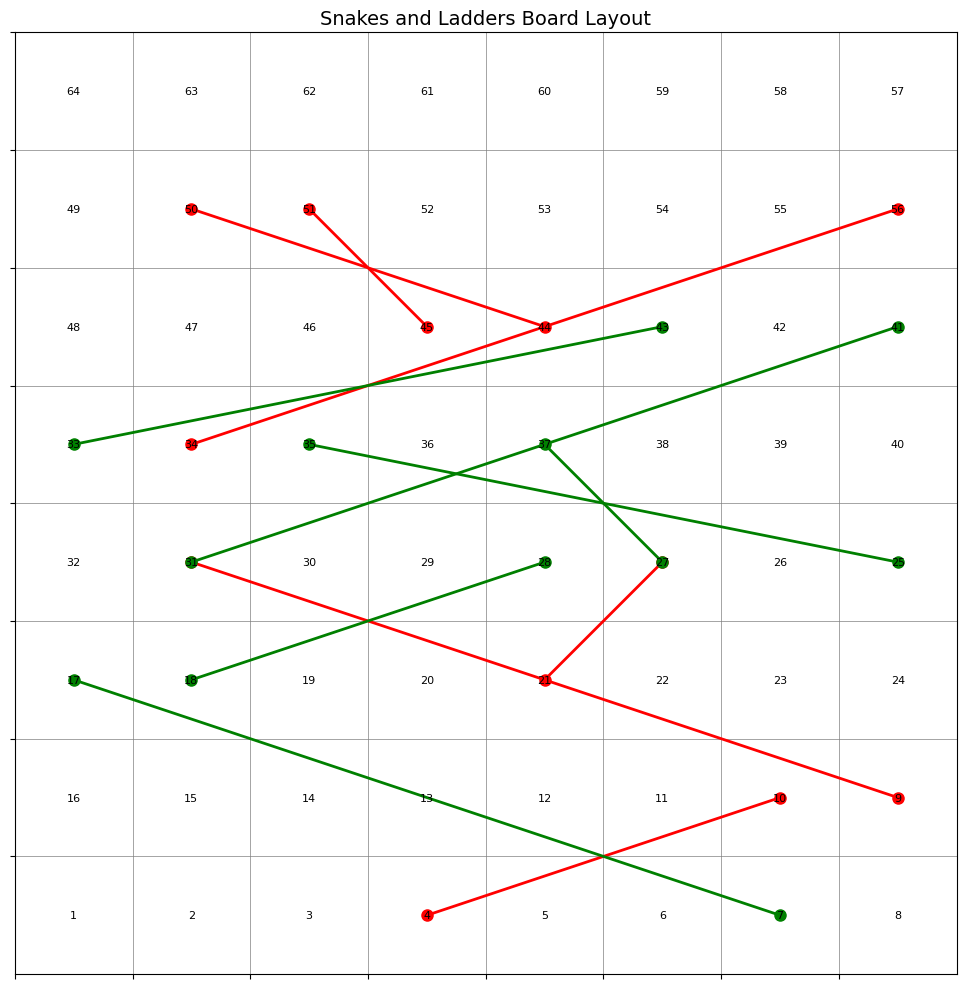

  Simulating with 9 snakes, 6 ladders (Ns/Nl ratio: 1.5)


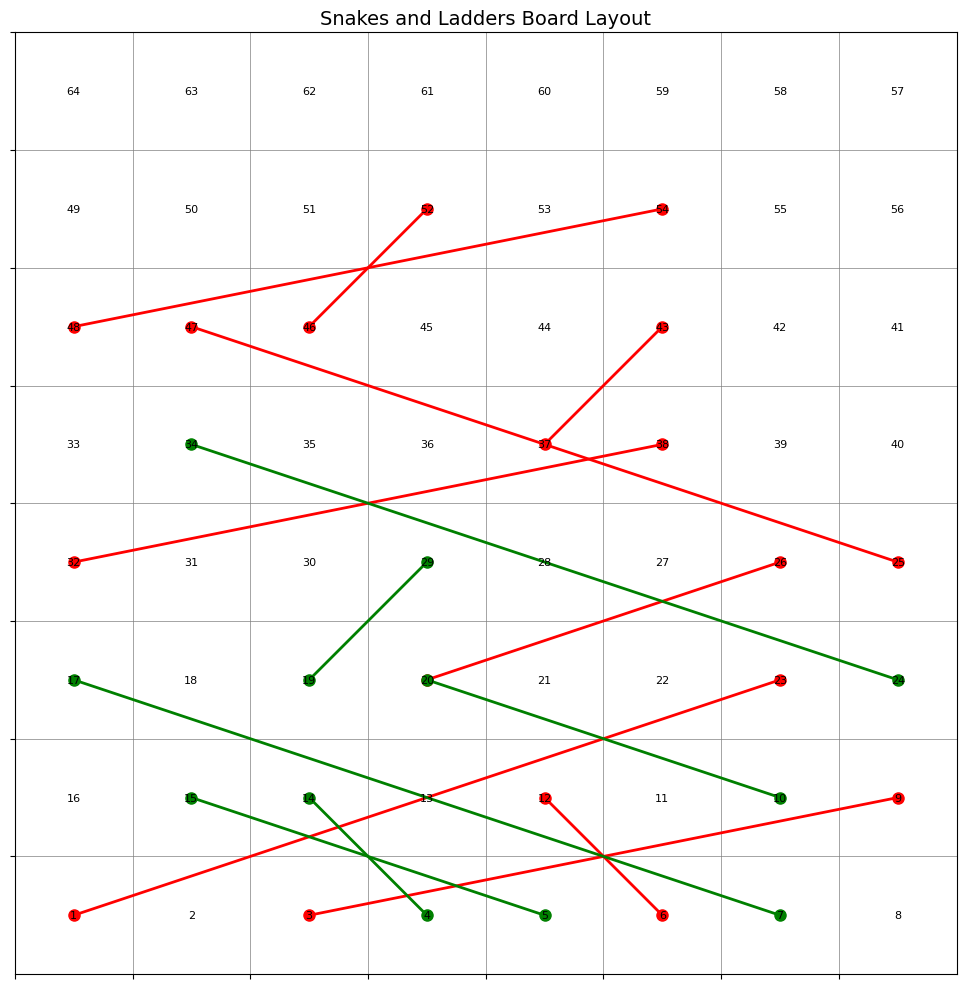

  Simulating with 12 snakes, 6 ladders (Ns/Nl ratio: 2.0)


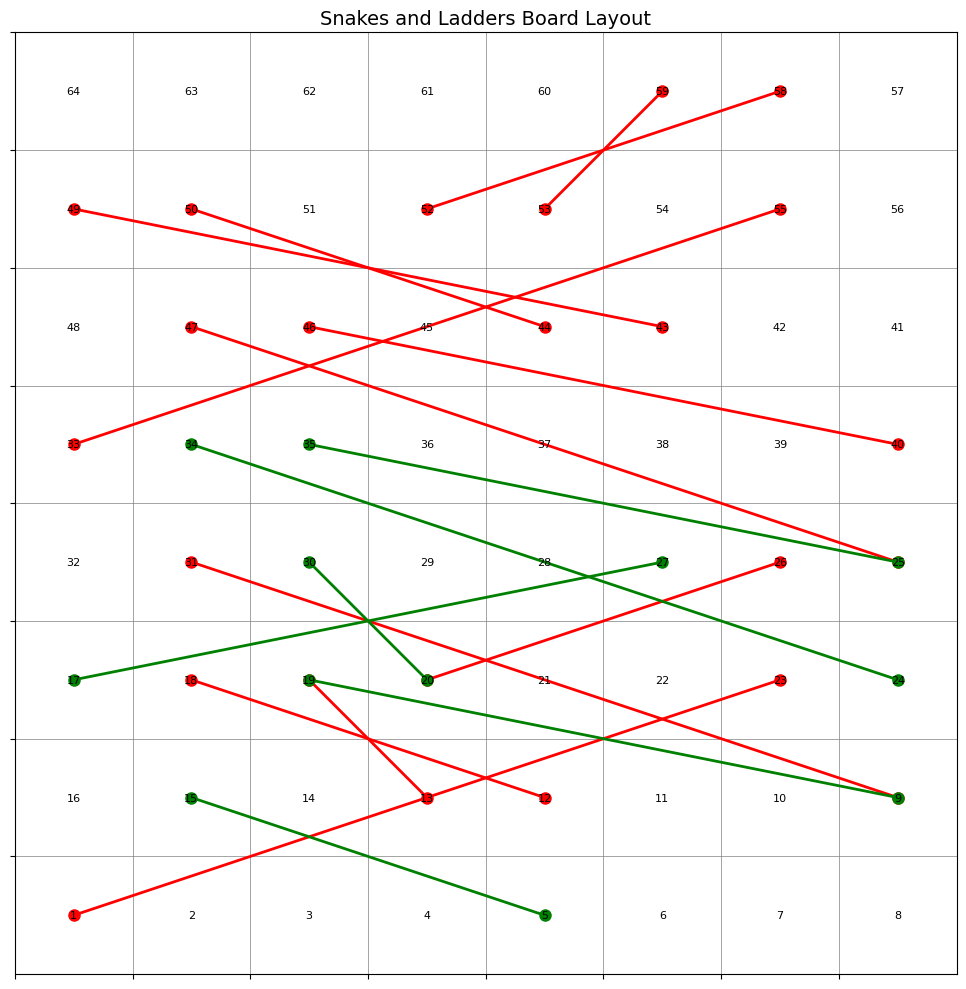


--- Board Size: 10x10 ---
  Simulating with 5 snakes, 10 ladders (Ns/Nl ratio: 0.5)


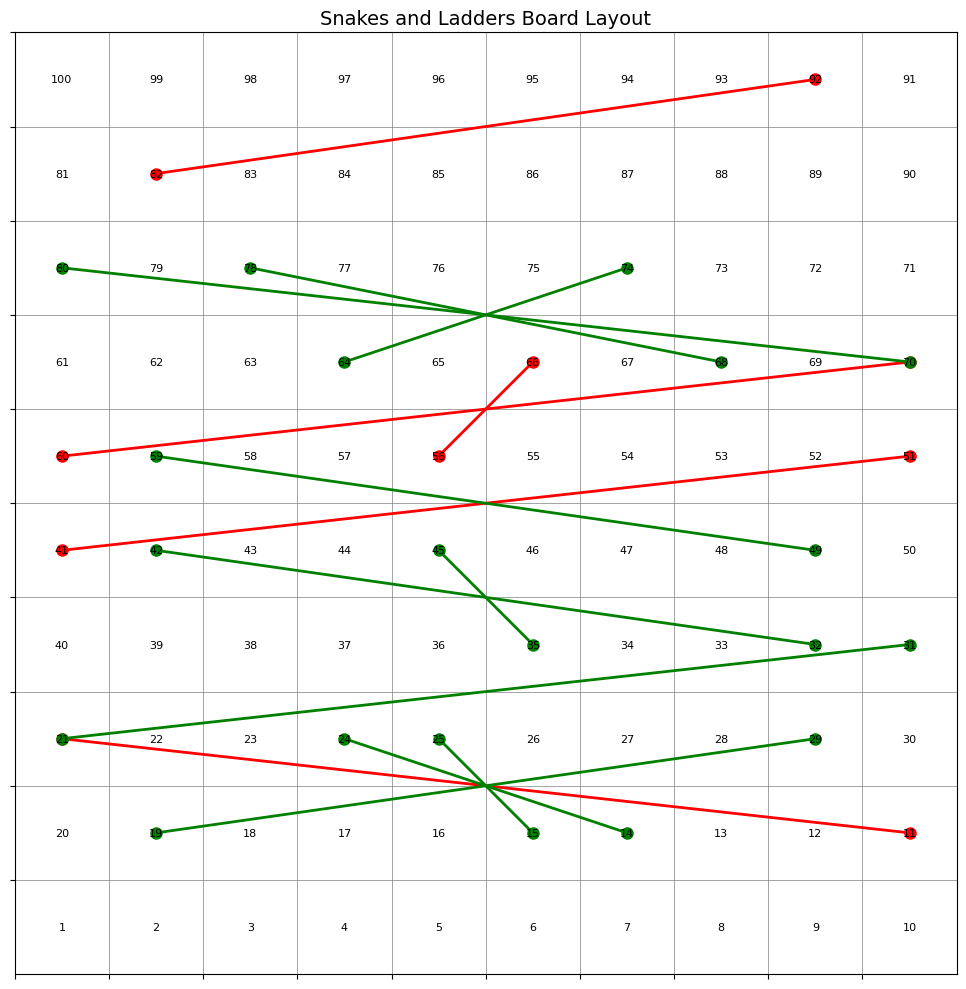

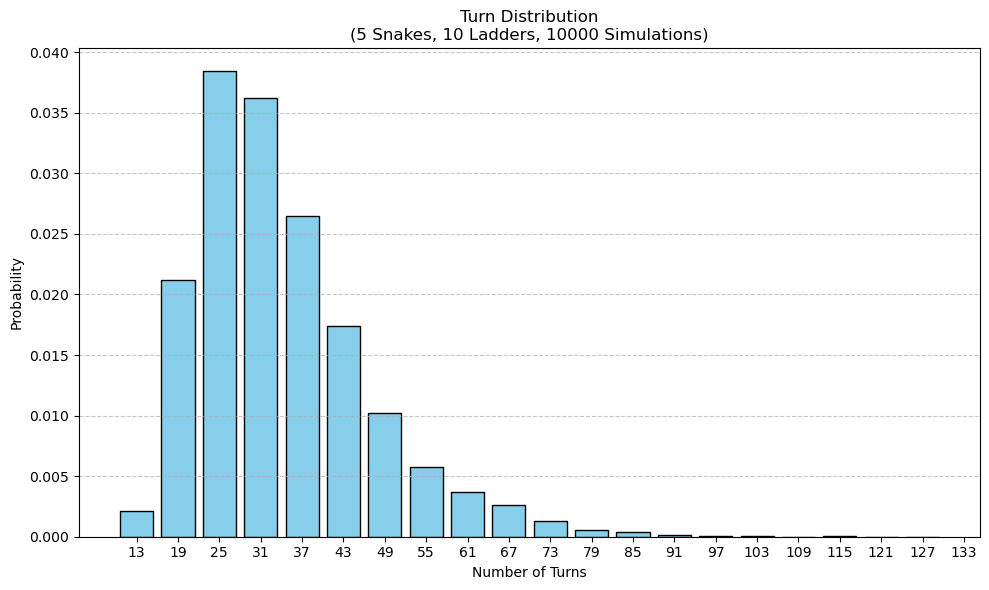

  Simulating with 10 snakes, 10 ladders (Ns/Nl ratio: 1.0)


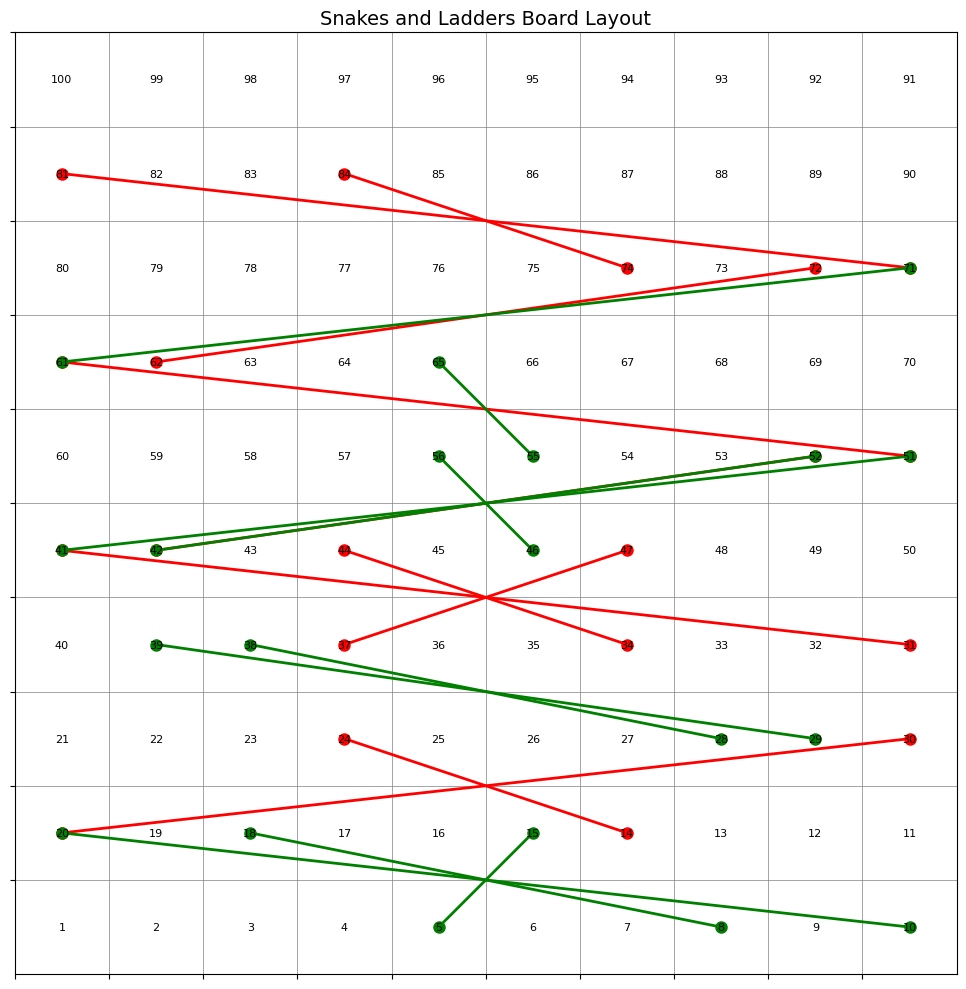

  Simulating with 15 snakes, 10 ladders (Ns/Nl ratio: 1.5)


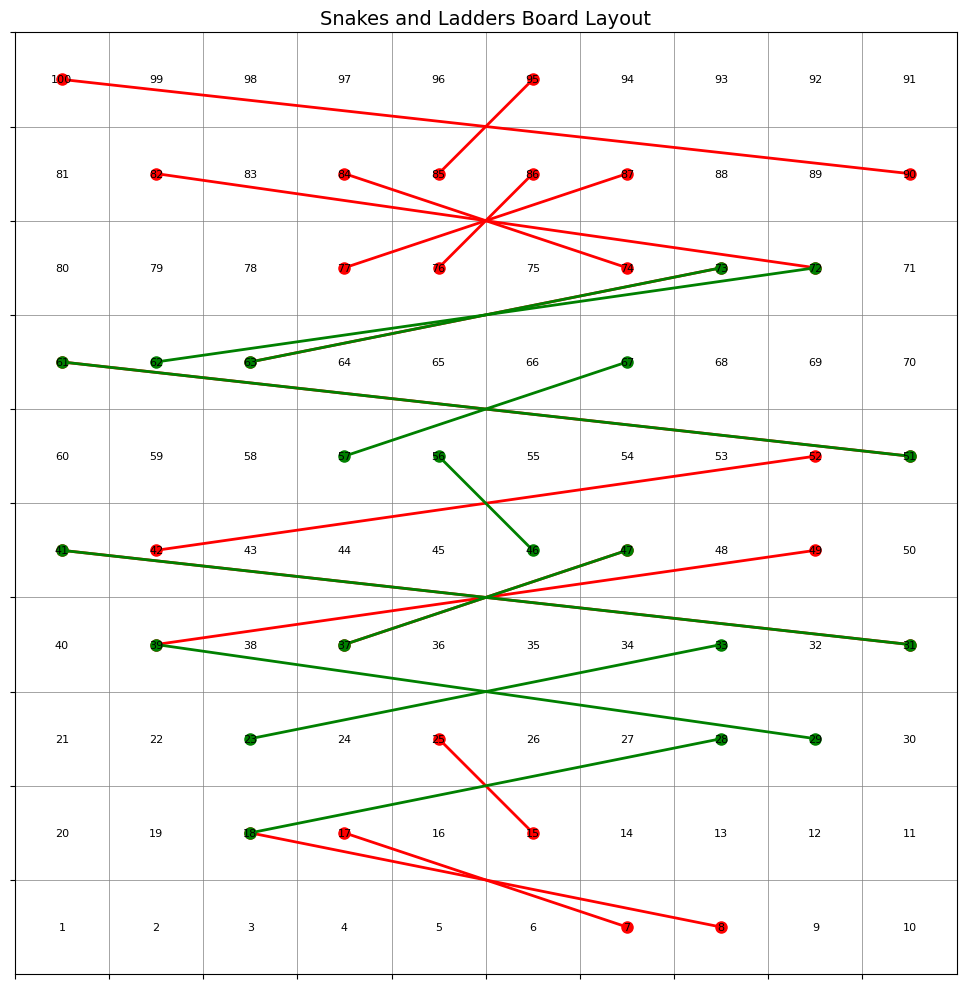

  Simulating with 20 snakes, 10 ladders (Ns/Nl ratio: 2.0)


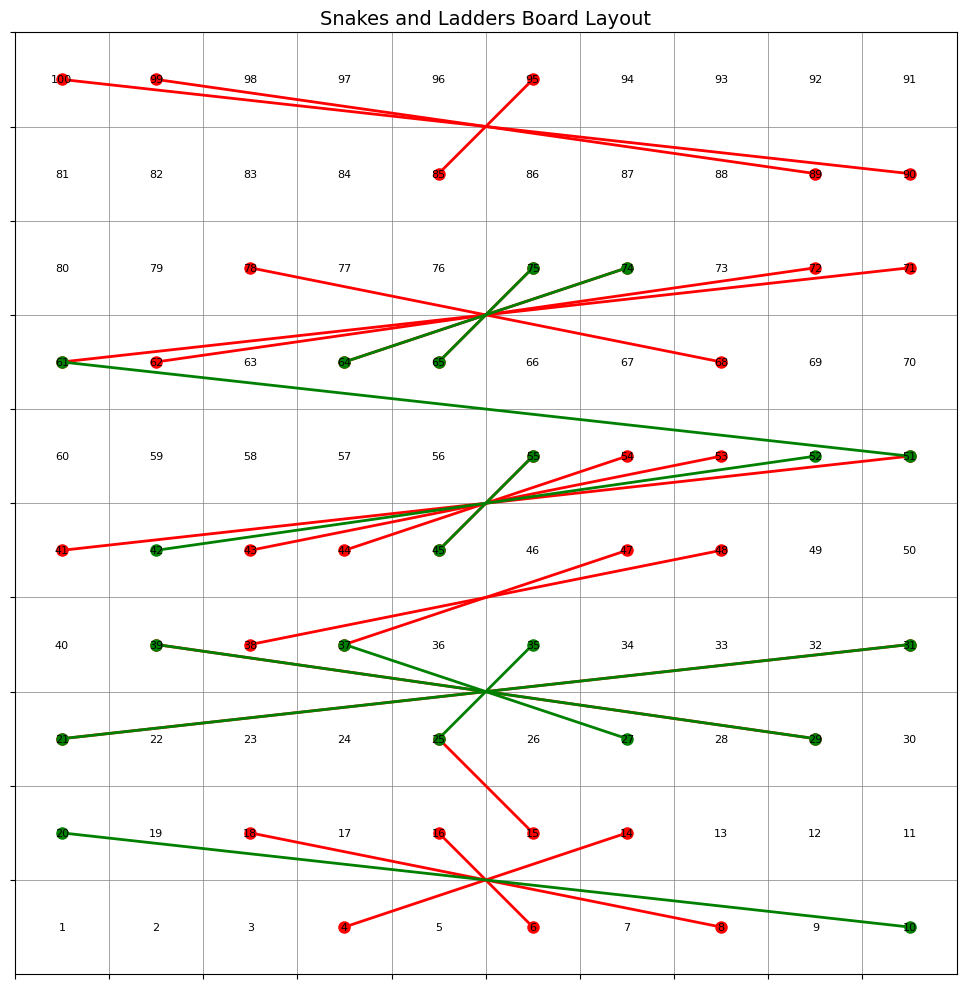


--- Board Size: 12x12 ---
  Simulating with 7 snakes, 14 ladders (Ns/Nl ratio: 0.5)


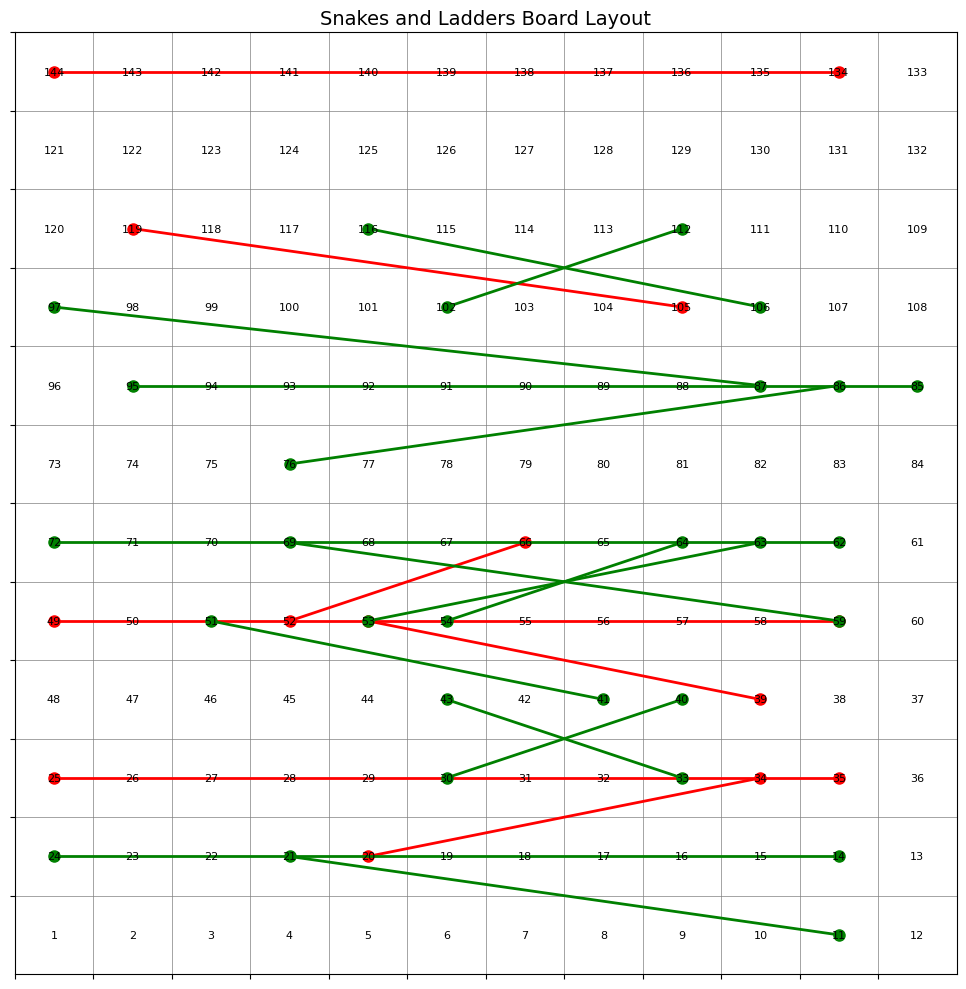

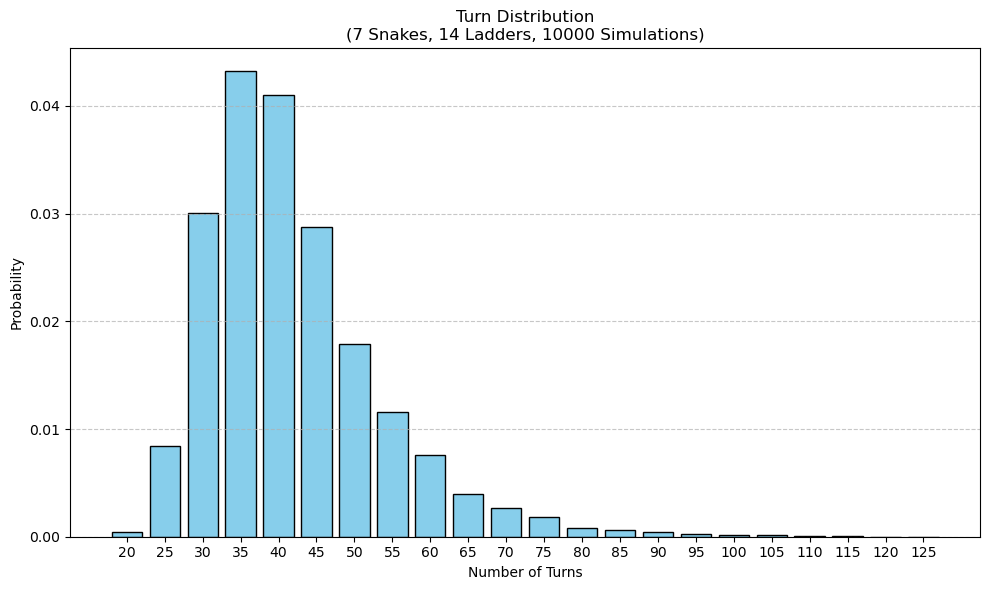

  Simulating with 14 snakes, 14 ladders (Ns/Nl ratio: 1.0)


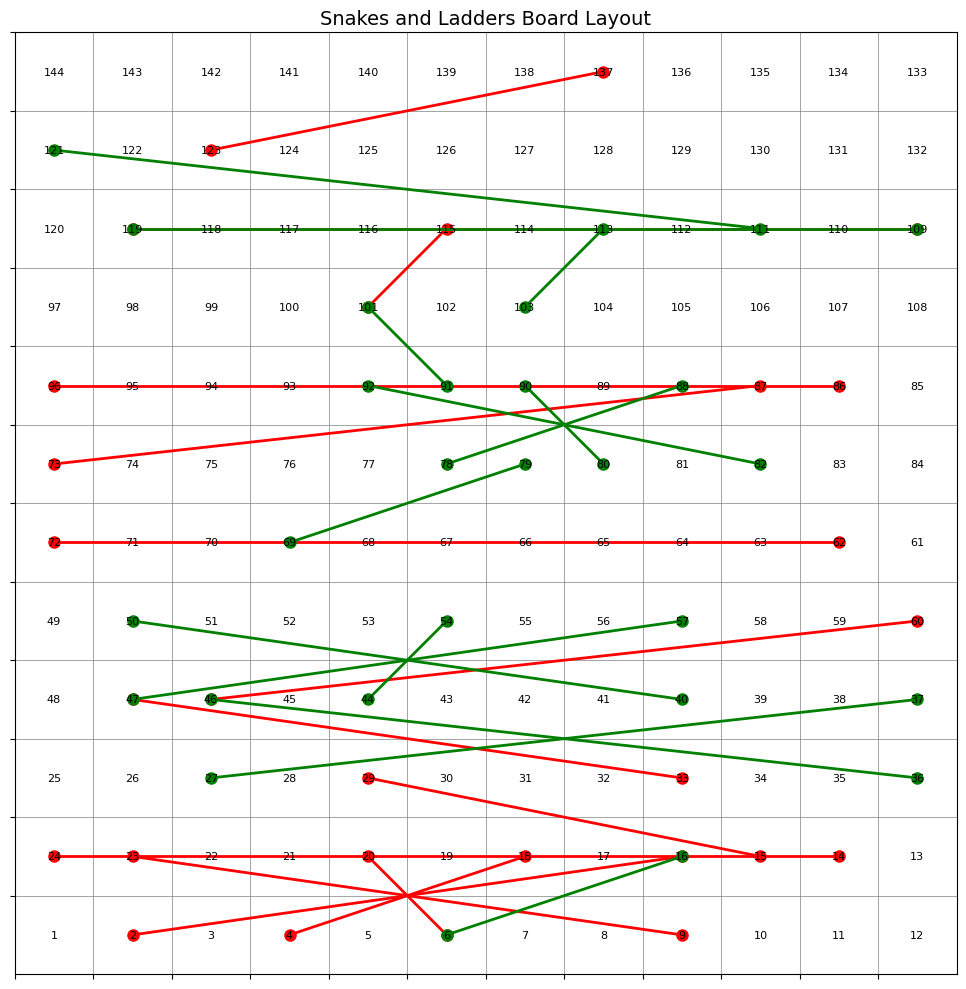

  Simulating with 21 snakes, 14 ladders (Ns/Nl ratio: 1.5)


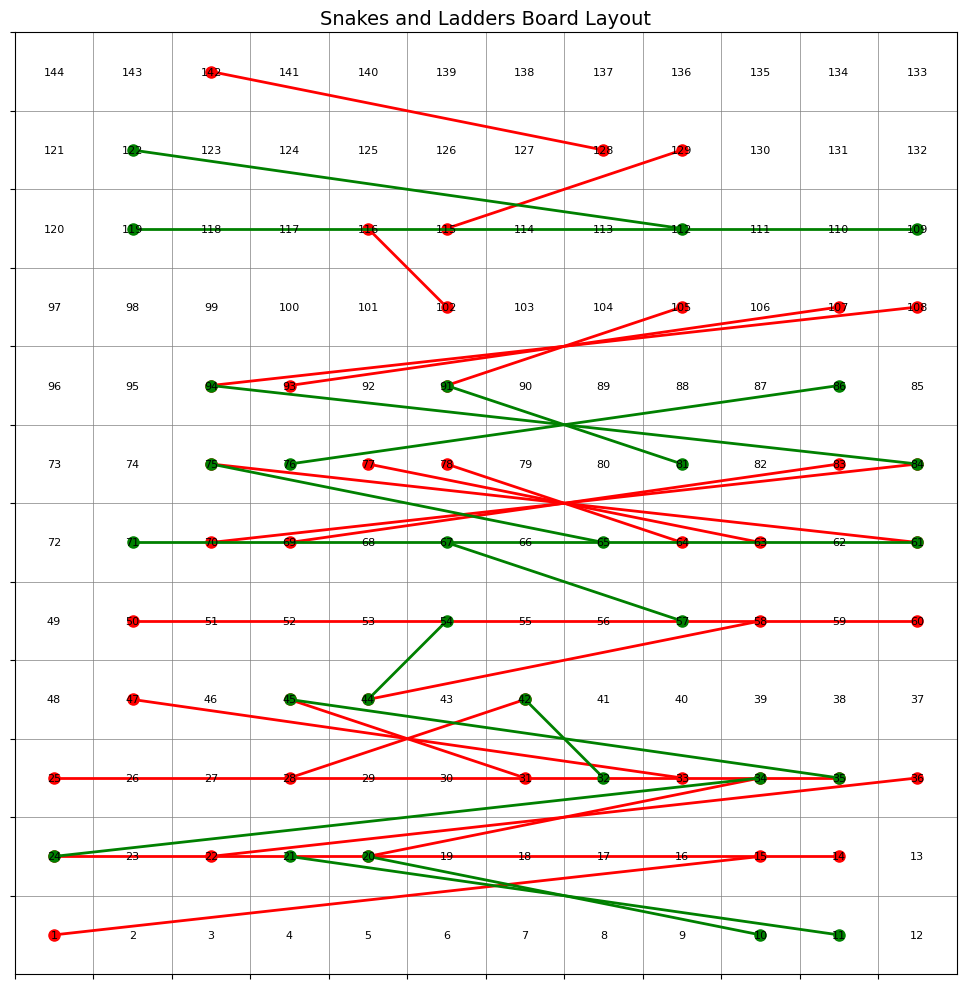

  Simulating with 28 snakes, 14 ladders (Ns/Nl ratio: 2.0)


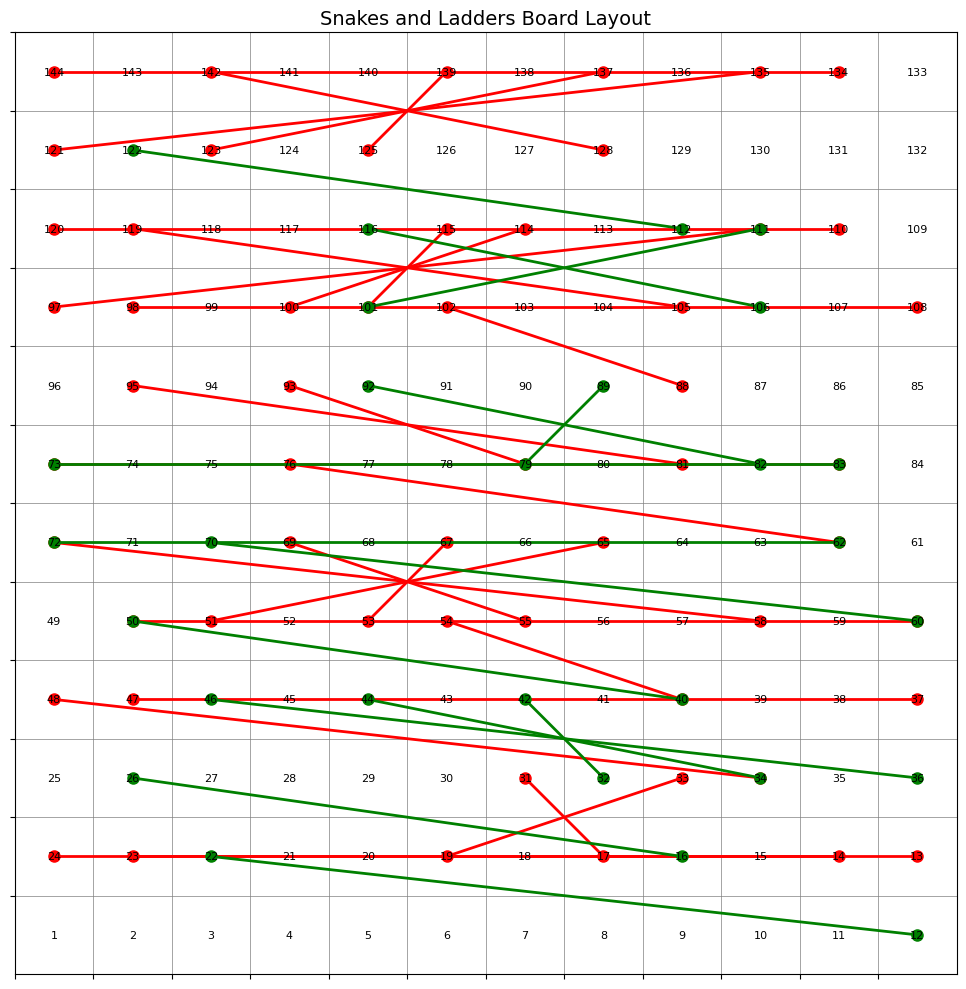


--- Board Size: 14x14 ---
  Simulating with 9 snakes, 19 ladders (Ns/Nl ratio: 0.5)


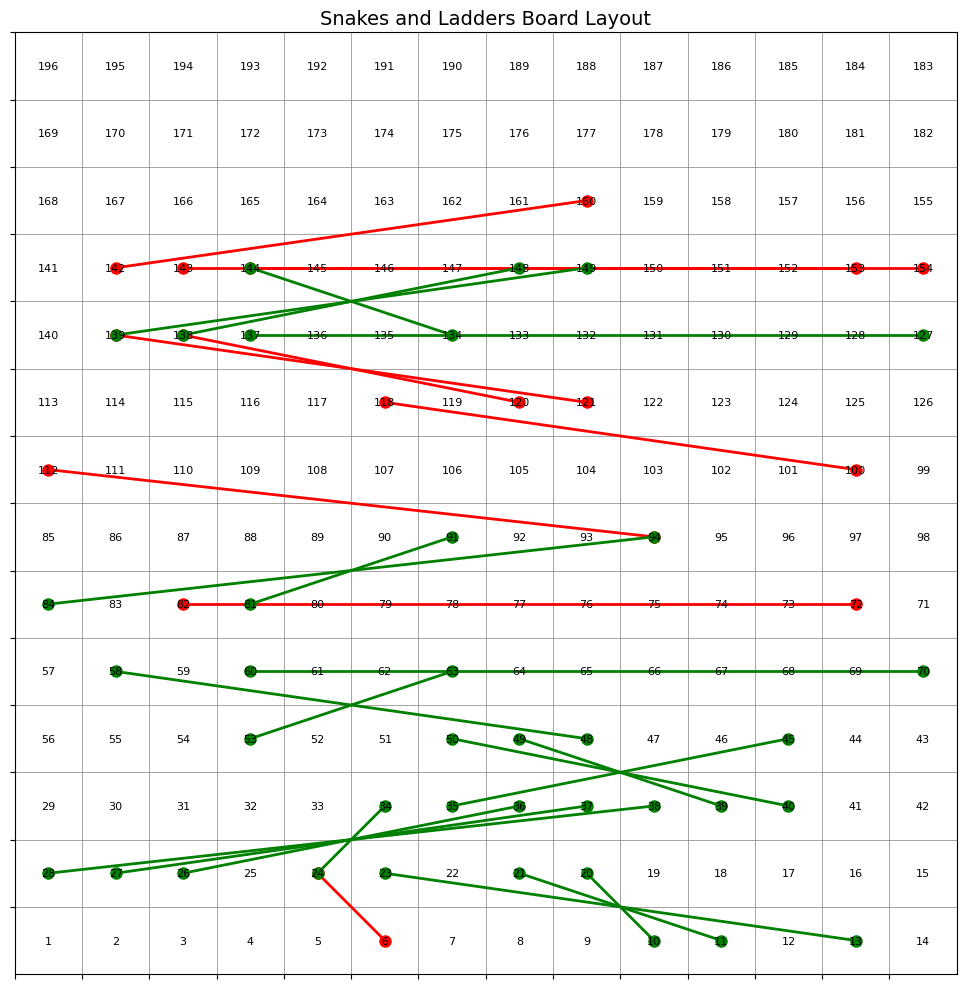

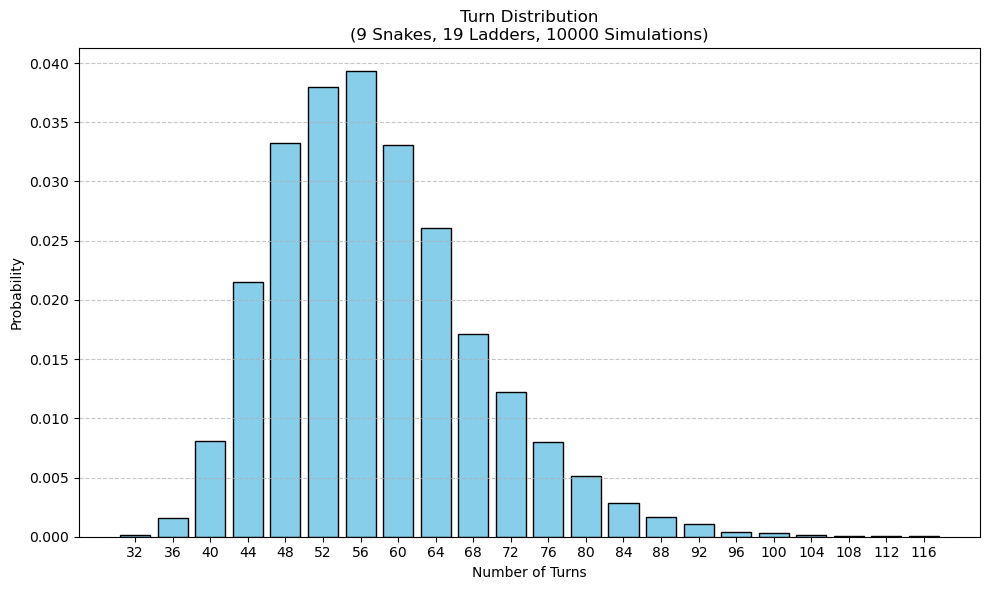

  Simulating with 19 snakes, 19 ladders (Ns/Nl ratio: 1.0)


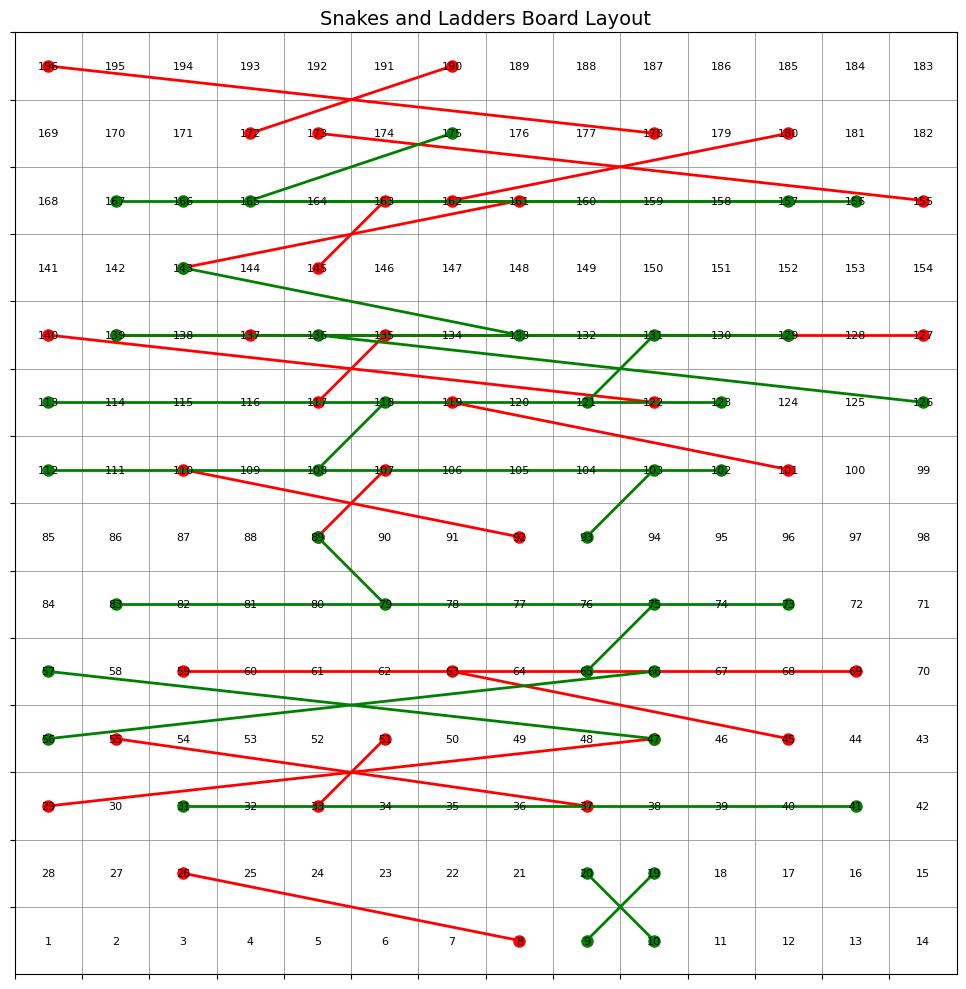

  Simulating with 28 snakes, 19 ladders (Ns/Nl ratio: 1.5)


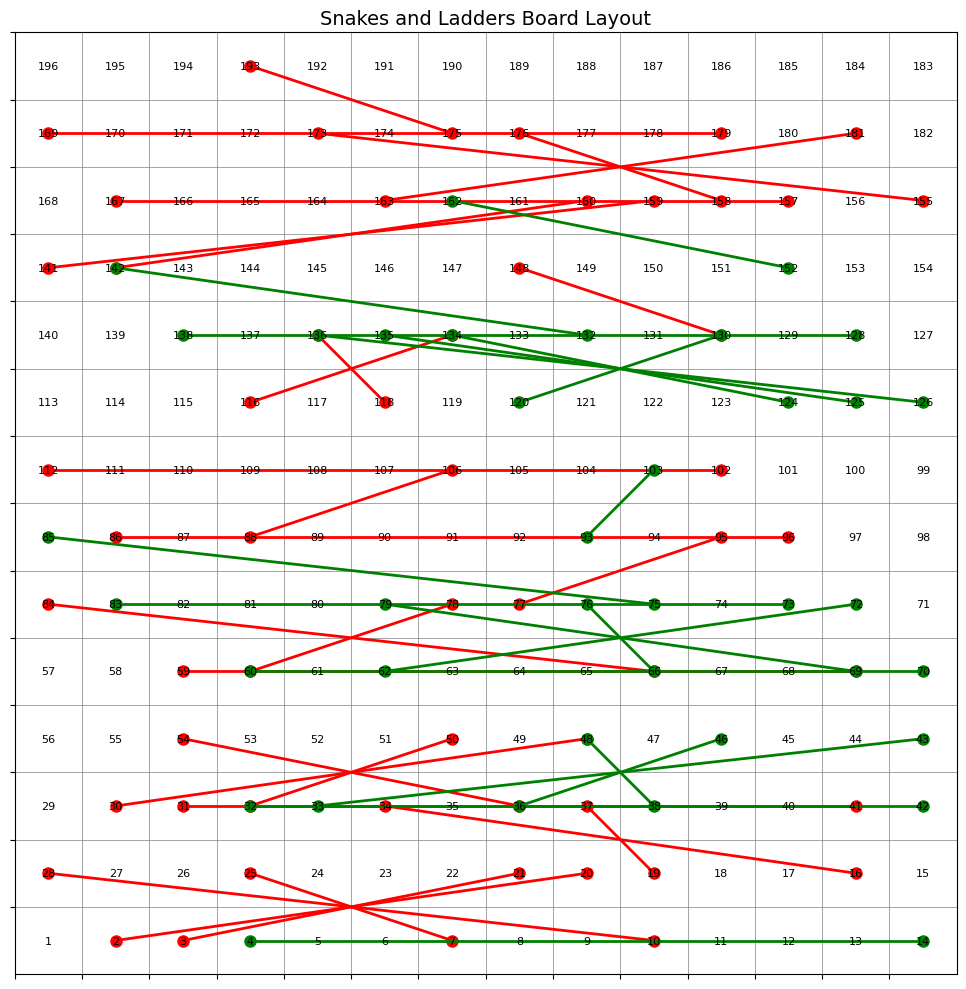

  Simulating with 38 snakes, 19 ladders (Ns/Nl ratio: 2.0)


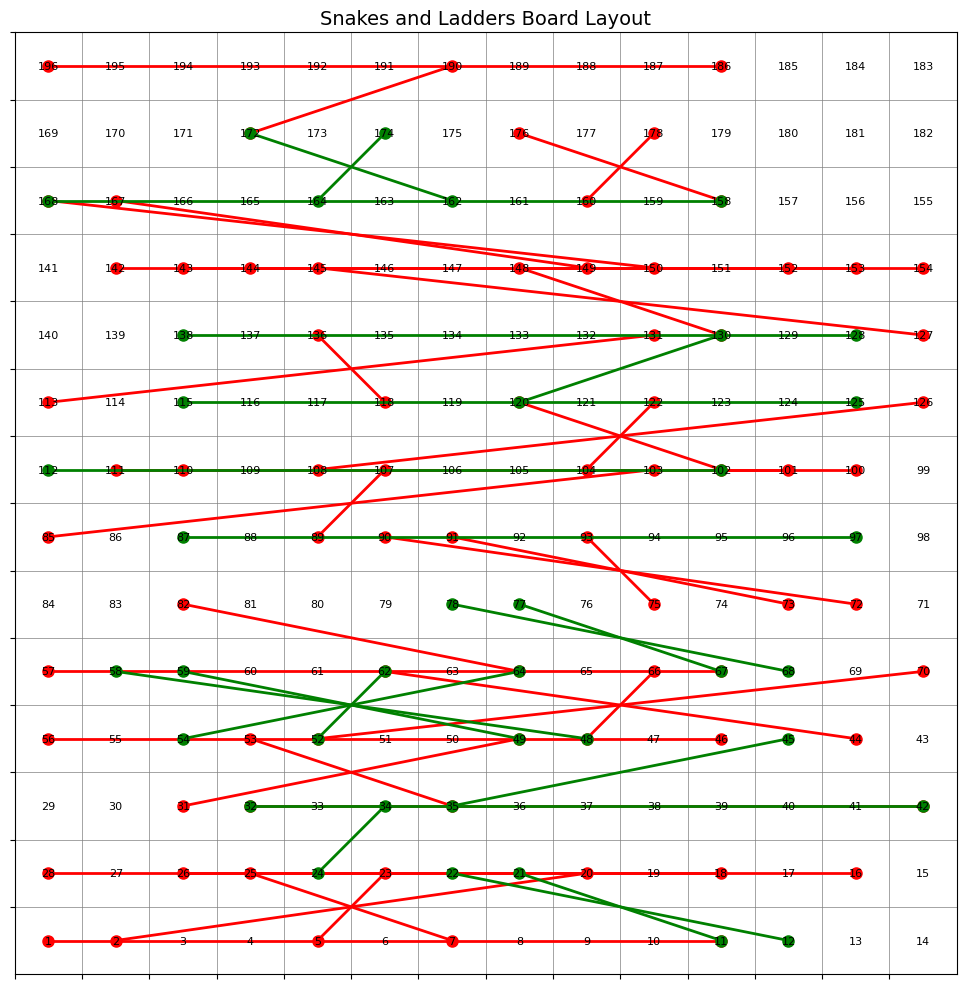


--- Board Size: 16x16 ---
  Simulating with 12 snakes, 25 ladders (Ns/Nl ratio: 0.5)


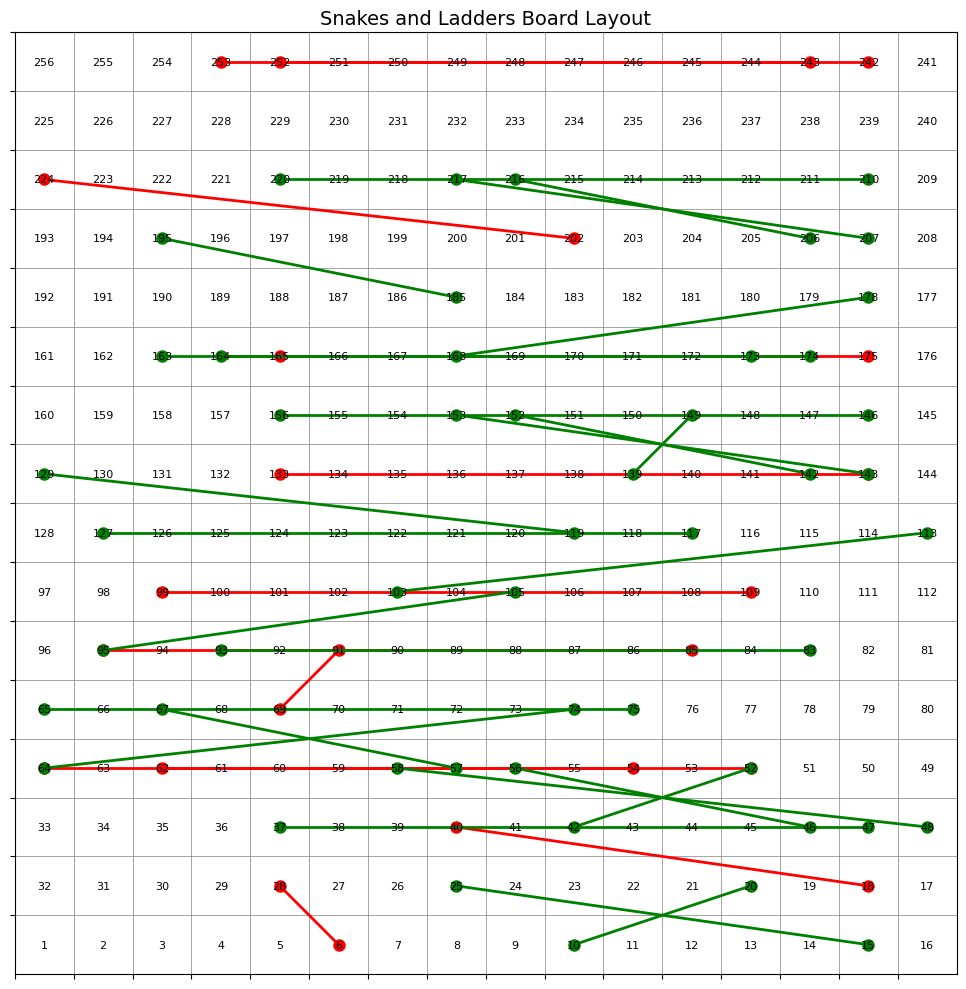

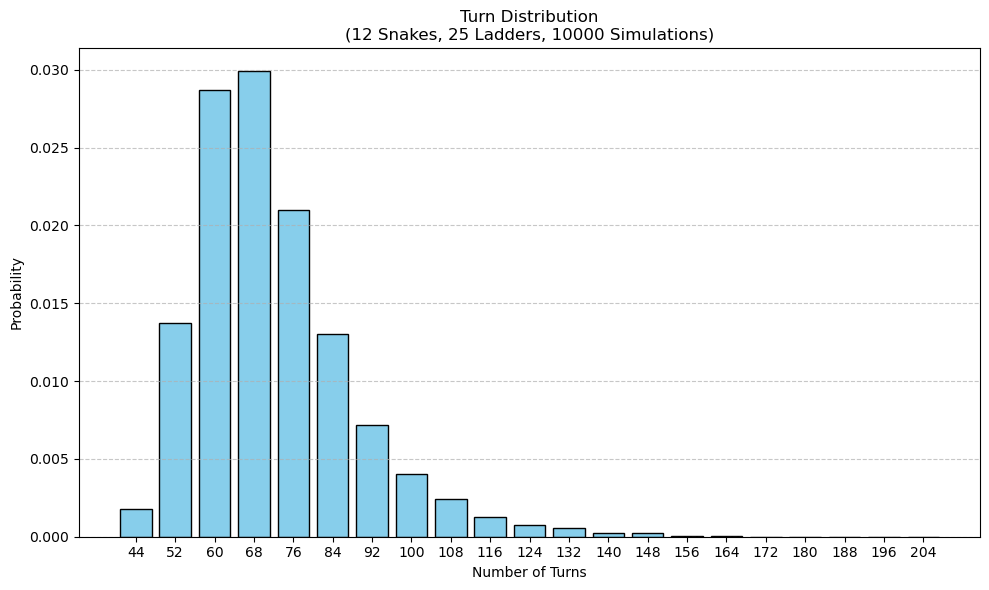

  Simulating with 25 snakes, 25 ladders (Ns/Nl ratio: 1.0)


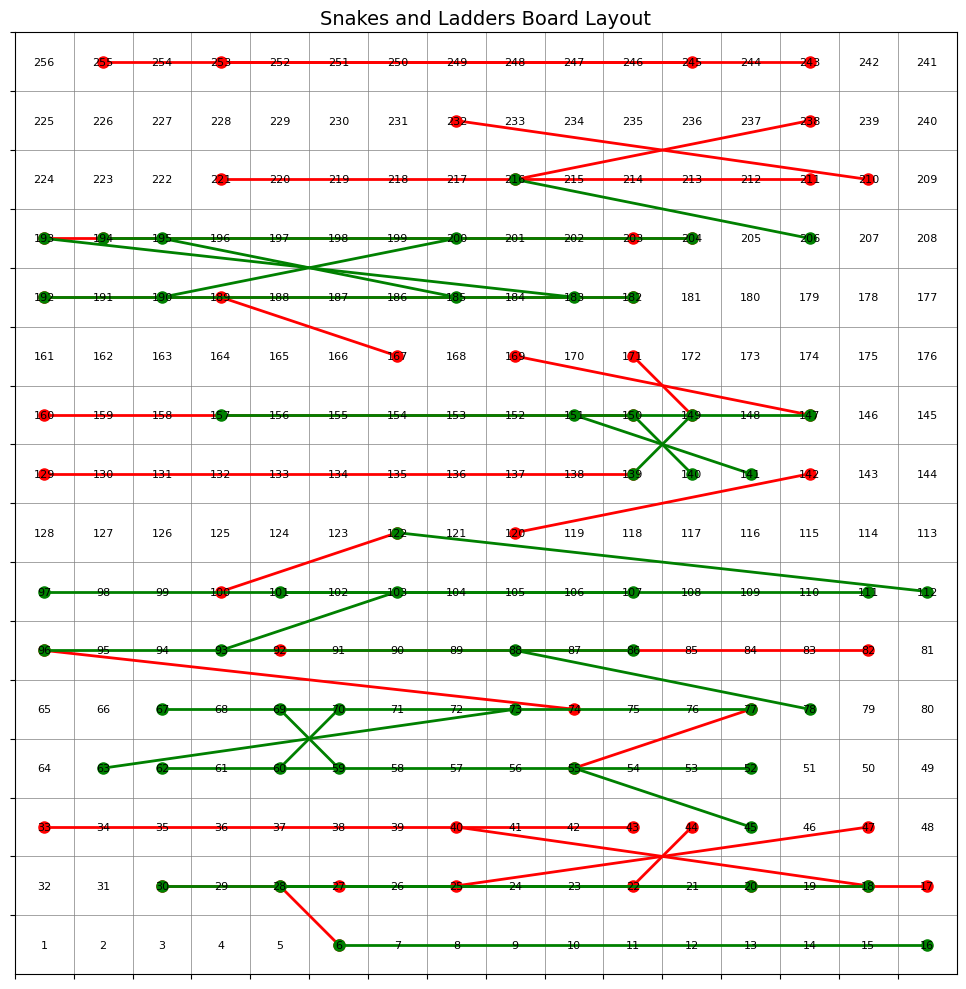

  Simulating with 37 snakes, 25 ladders (Ns/Nl ratio: 1.5)


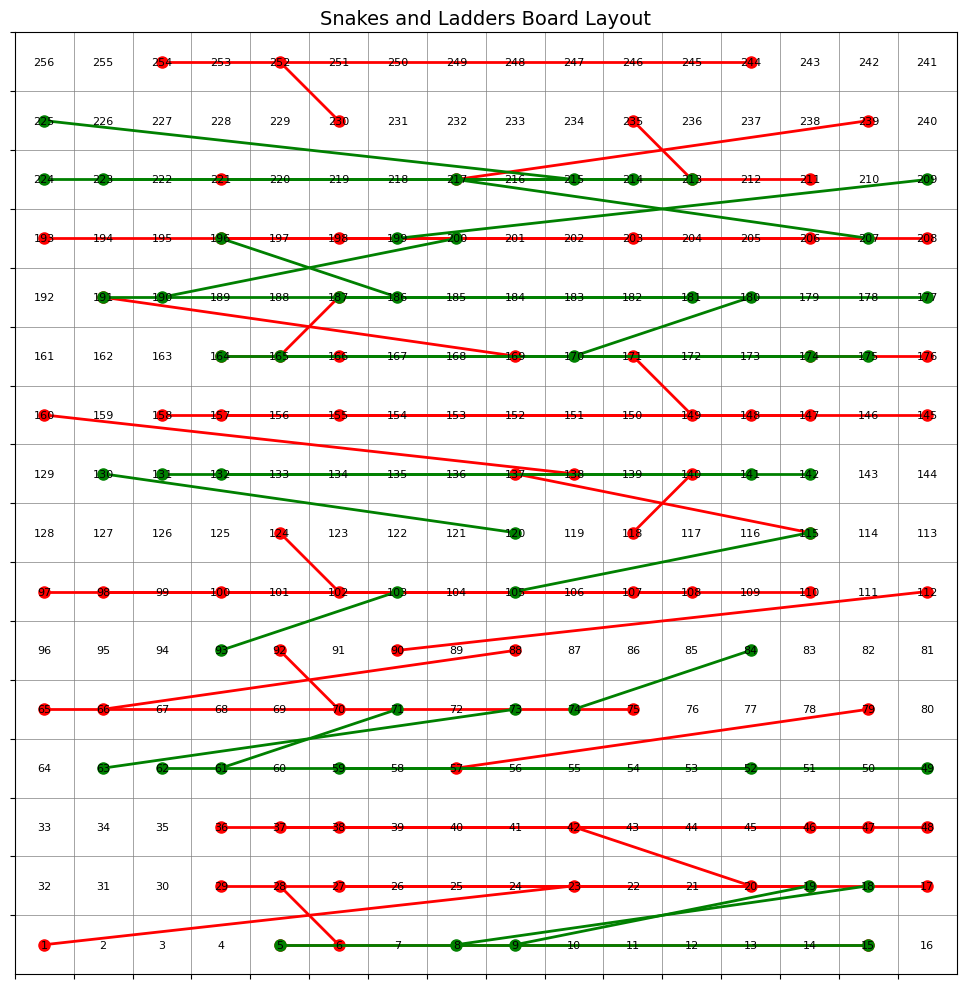

  Simulating with 50 snakes, 25 ladders (Ns/Nl ratio: 2.0)


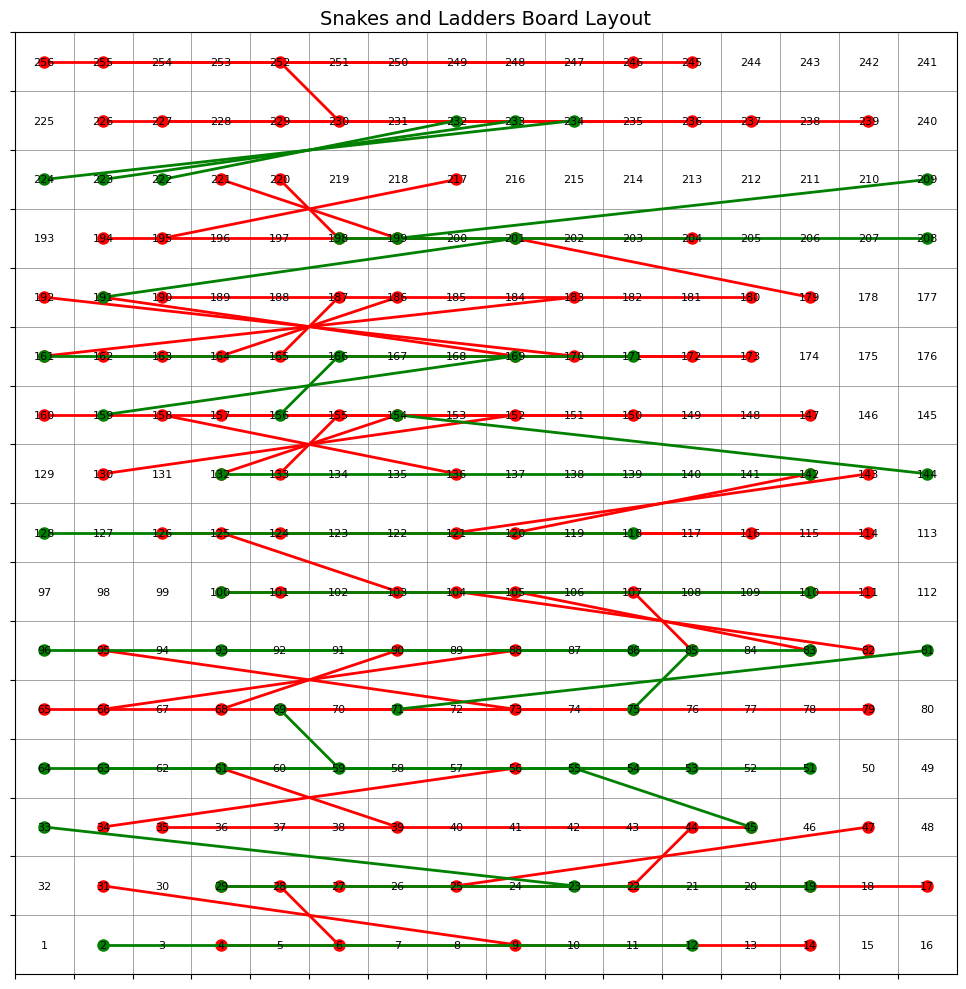


--- Board Size: 18x18 ---
  Simulating with 16 snakes, 32 ladders (Ns/Nl ratio: 0.5)


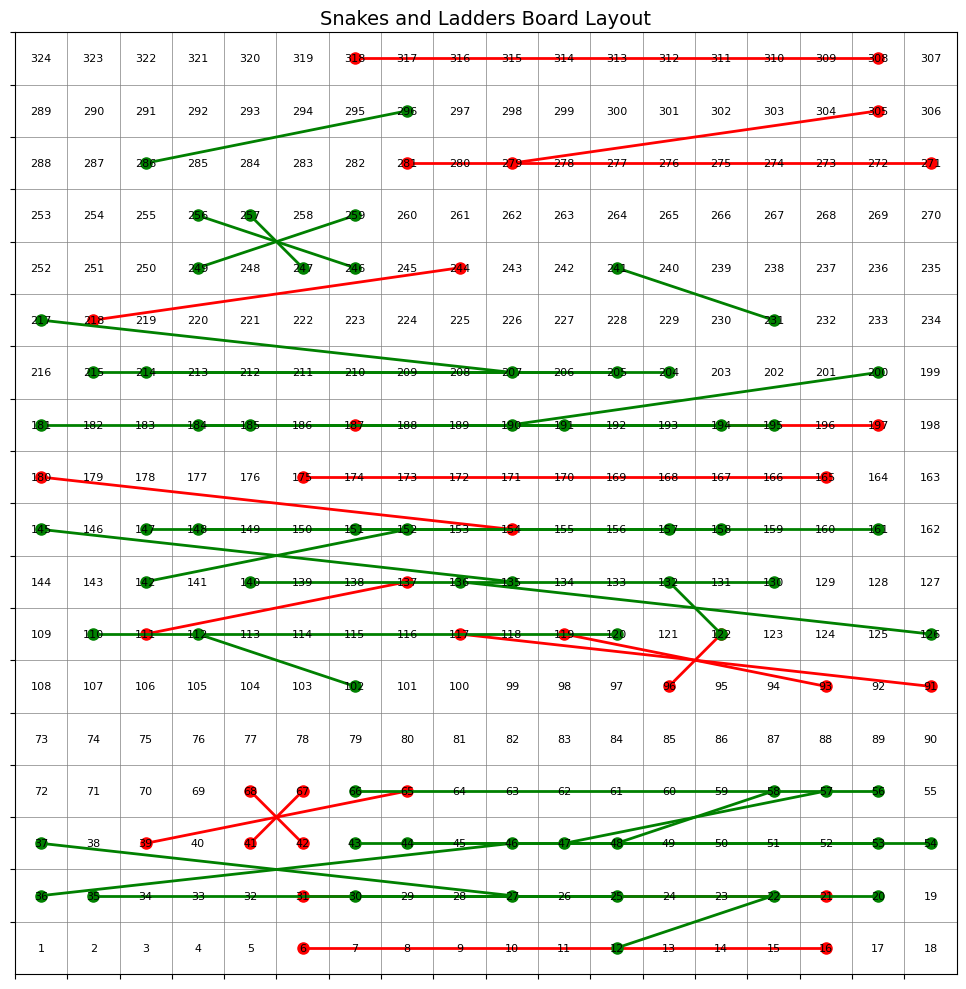

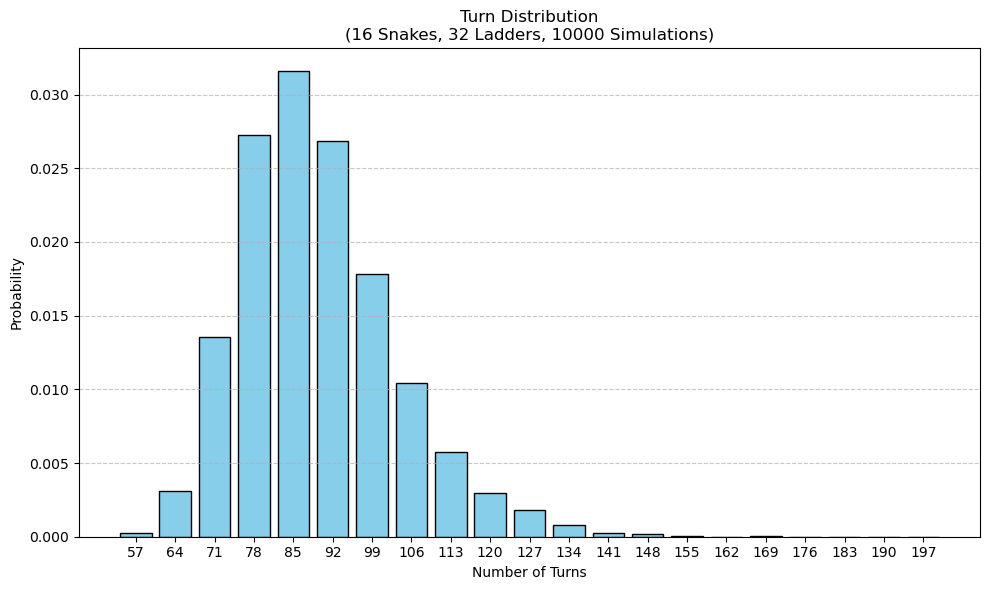

  Simulating with 32 snakes, 32 ladders (Ns/Nl ratio: 1.0)


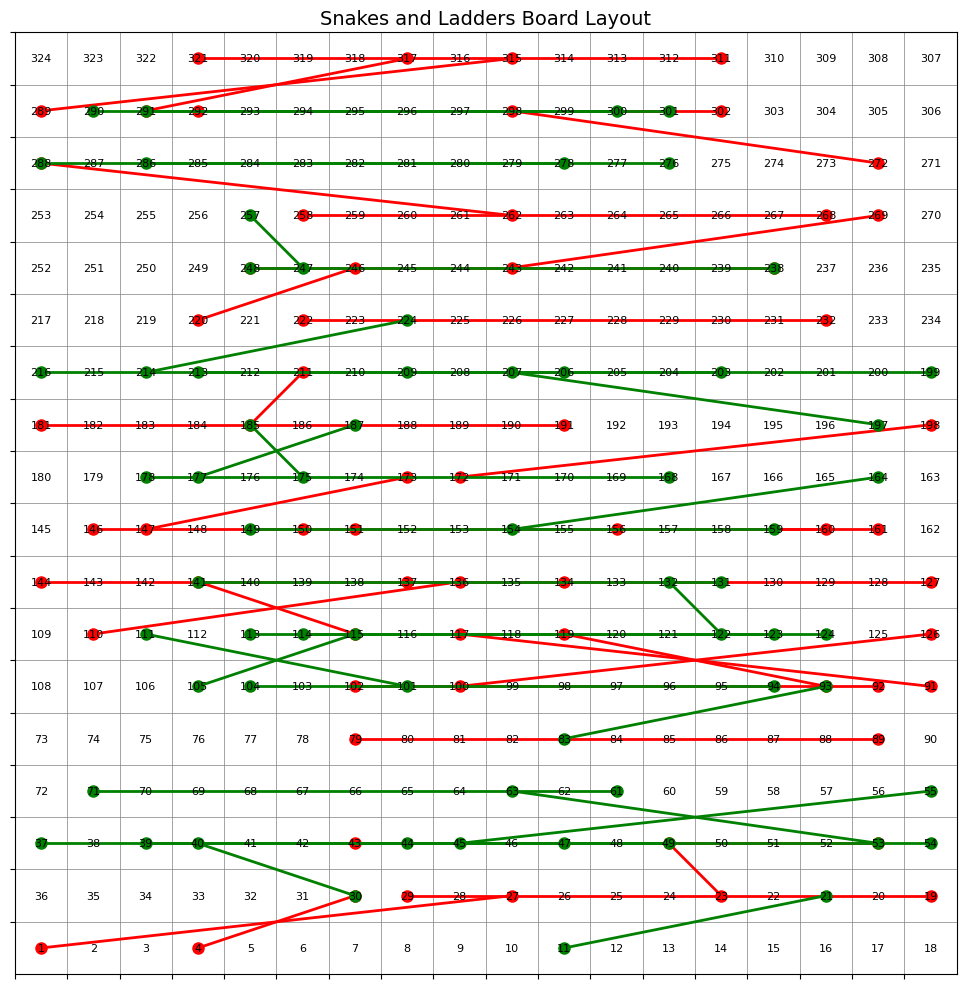

  Simulating with 48 snakes, 32 ladders (Ns/Nl ratio: 1.5)


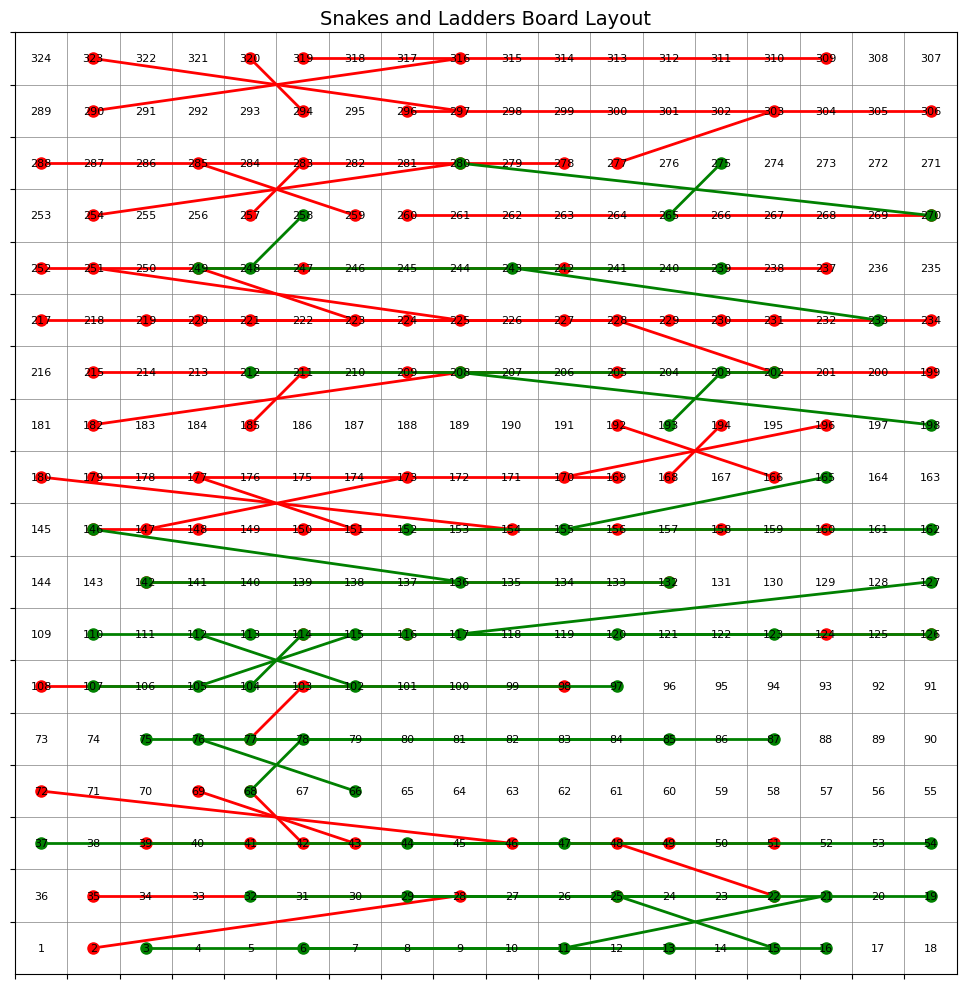

  Simulating with 64 snakes, 32 ladders (Ns/Nl ratio: 2.0)


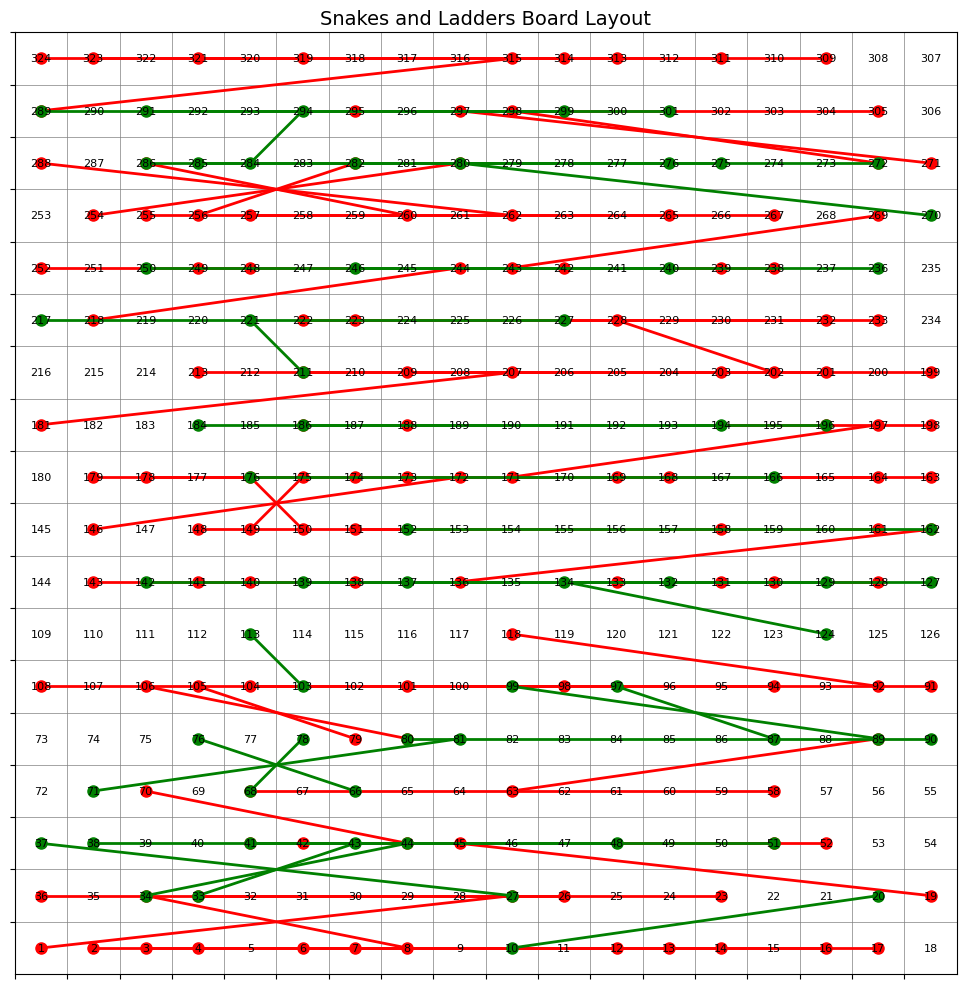


--- Board Size: 20x20 ---
  Simulating with 20 snakes, 40 ladders (Ns/Nl ratio: 0.5)


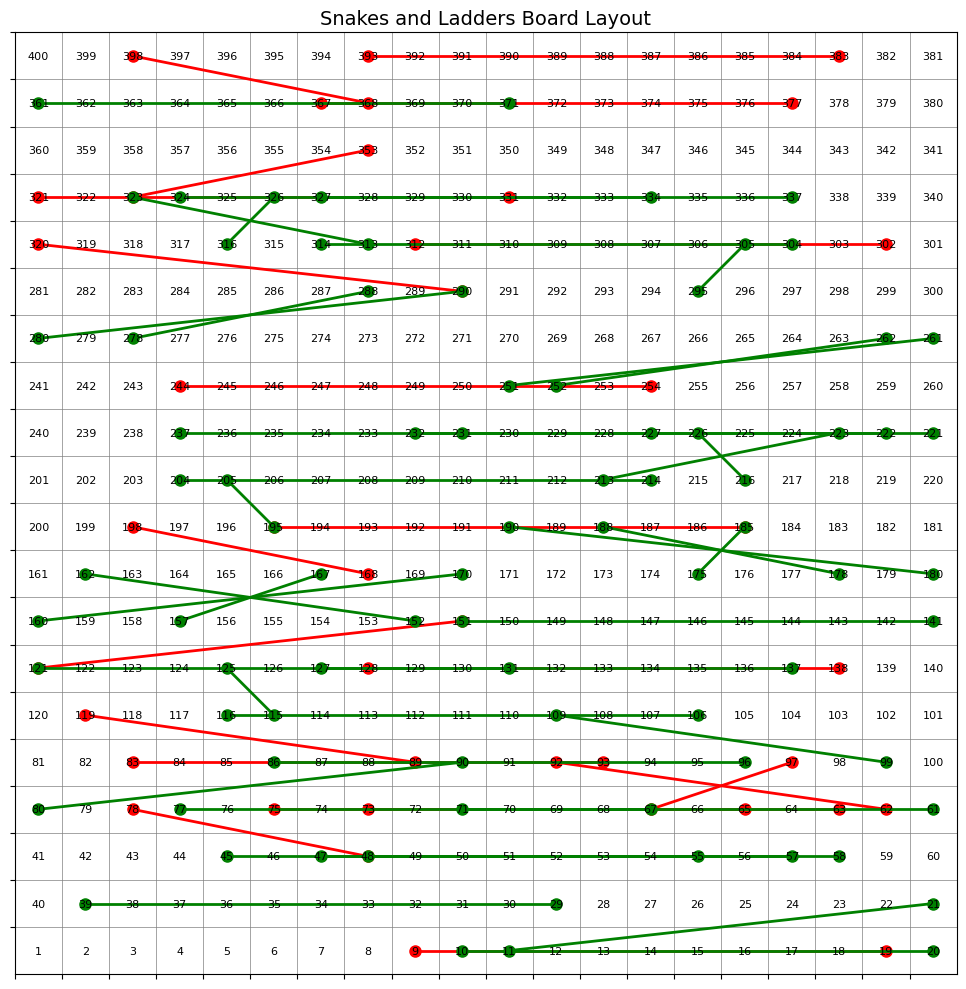

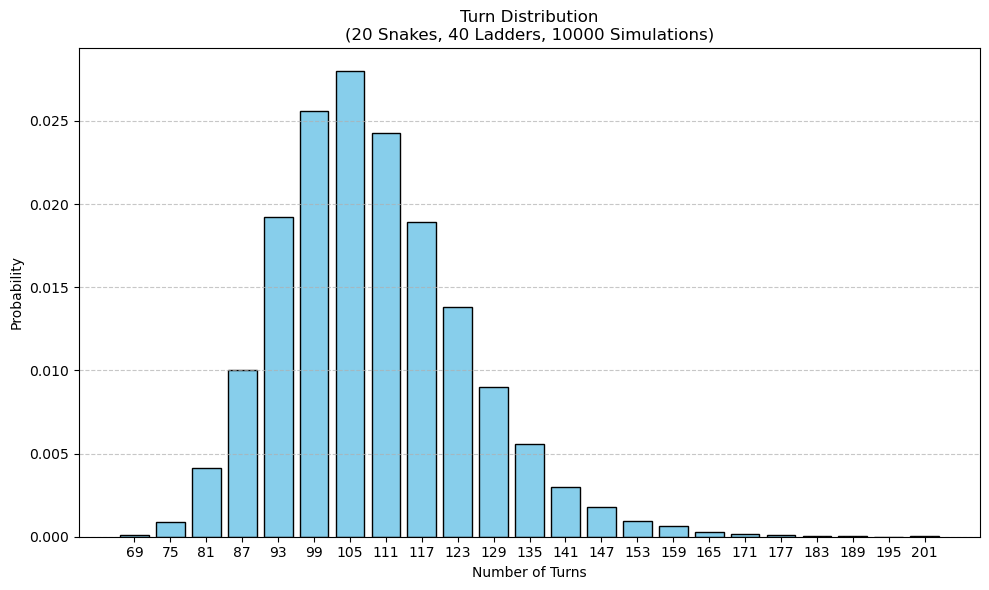

  Simulating with 40 snakes, 40 ladders (Ns/Nl ratio: 1.0)


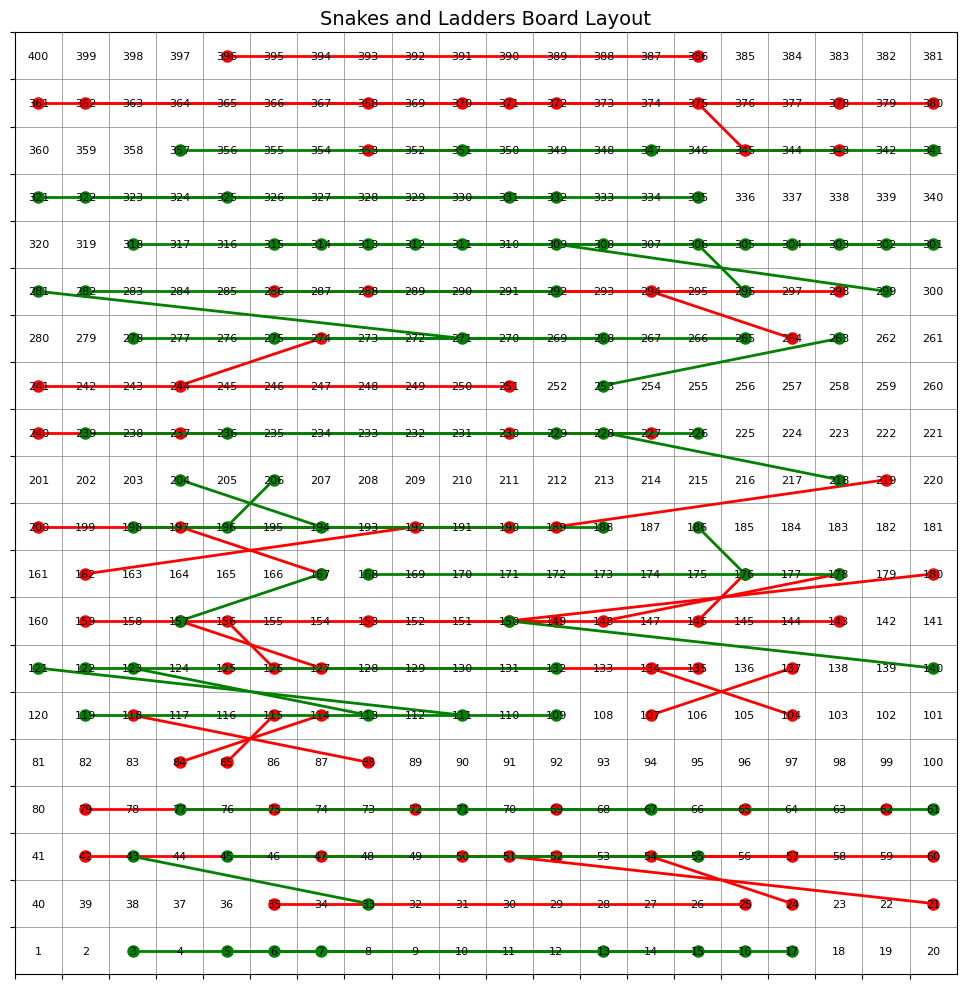

  Simulating with 60 snakes, 40 ladders (Ns/Nl ratio: 1.5)


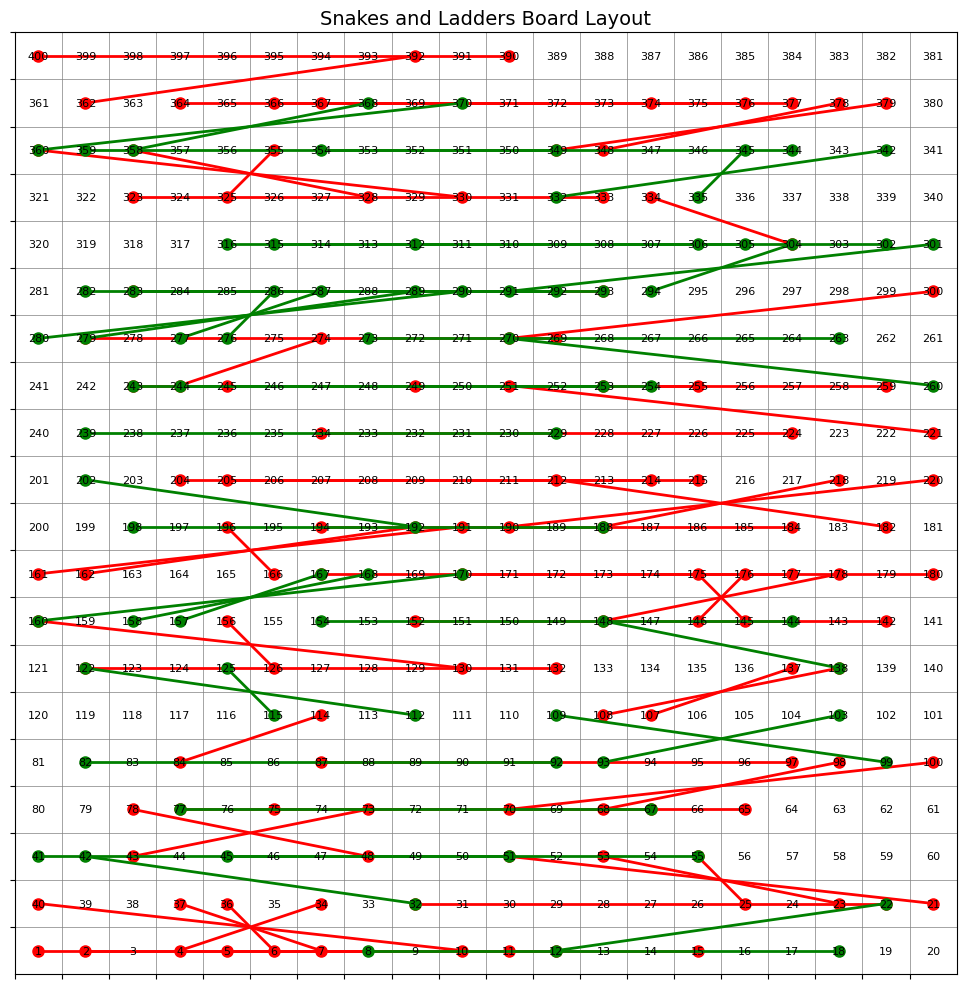

  Simulating with 80 snakes, 40 ladders (Ns/Nl ratio: 2.0)


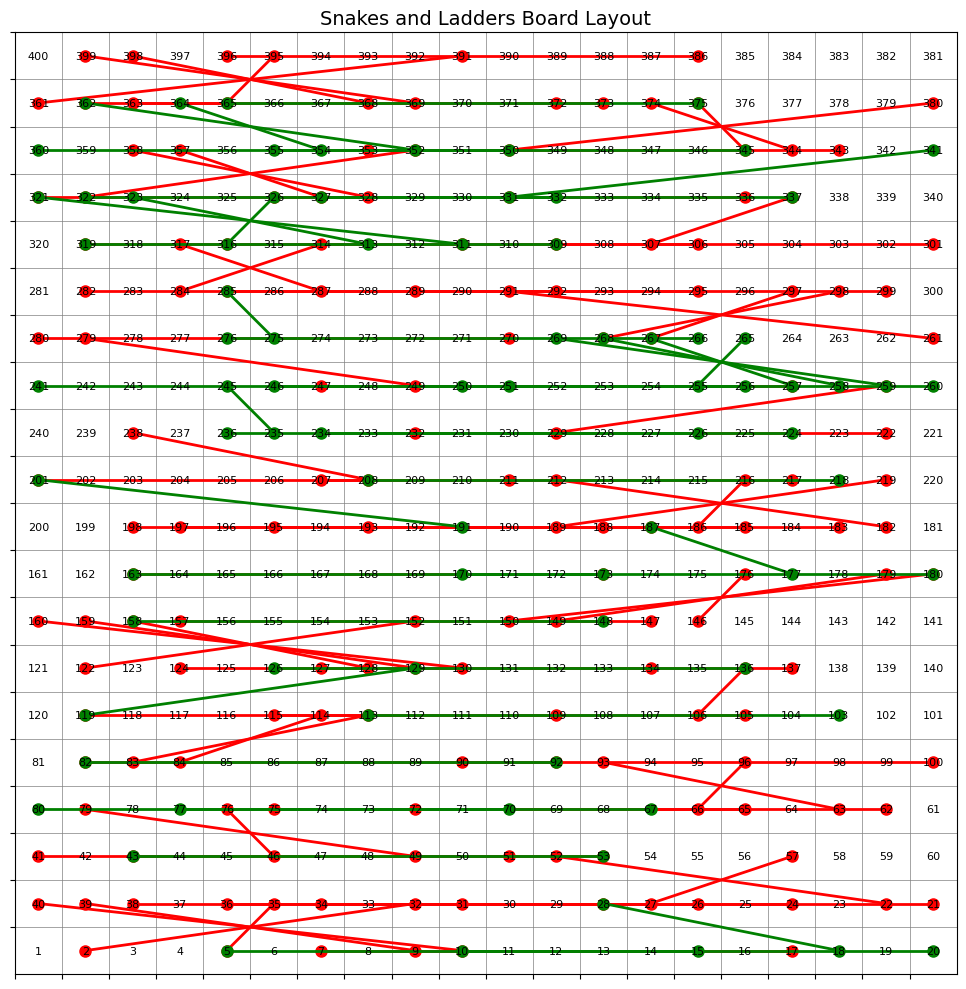


=== AGGREGATED RESULTS ===
    board_size  num_snakes  num_ladders  snake_ladder_ratio  average_turns  \
0           64           6           12            0.500000        24.8885   
1           64           6            6            1.000000        31.1660   
2           64           6            4            1.500000        26.4654   
3           64           6            3            2.000000        38.3363   
4          100          10           20            0.500000        32.7801   
5          100          10           10            1.000000        53.1081   
6          100          10            6            1.666667        39.6765   
7          100          10            5            2.000000        46.5208   
8          144          14           28            0.500000        41.4913   
9          144          14           14            1.000000        52.1466   
10         144          14            9            1.555556        56.1367   
11         144          14          

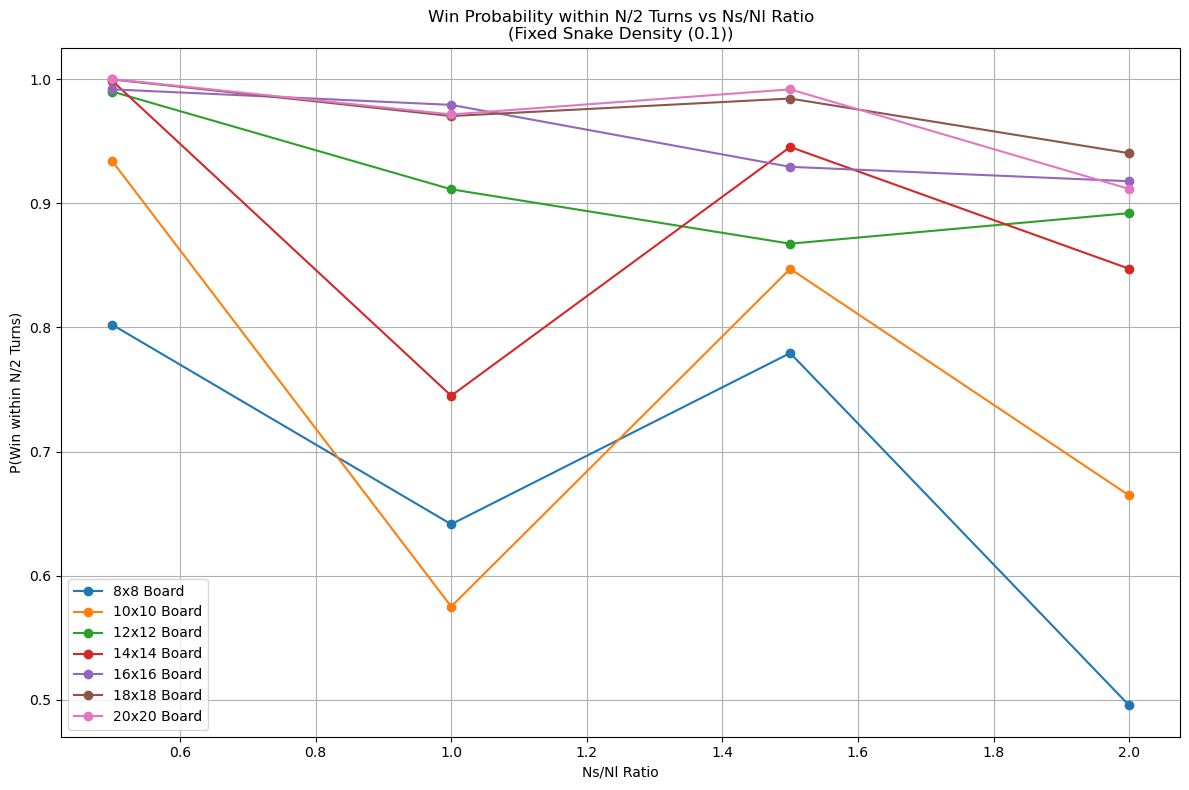

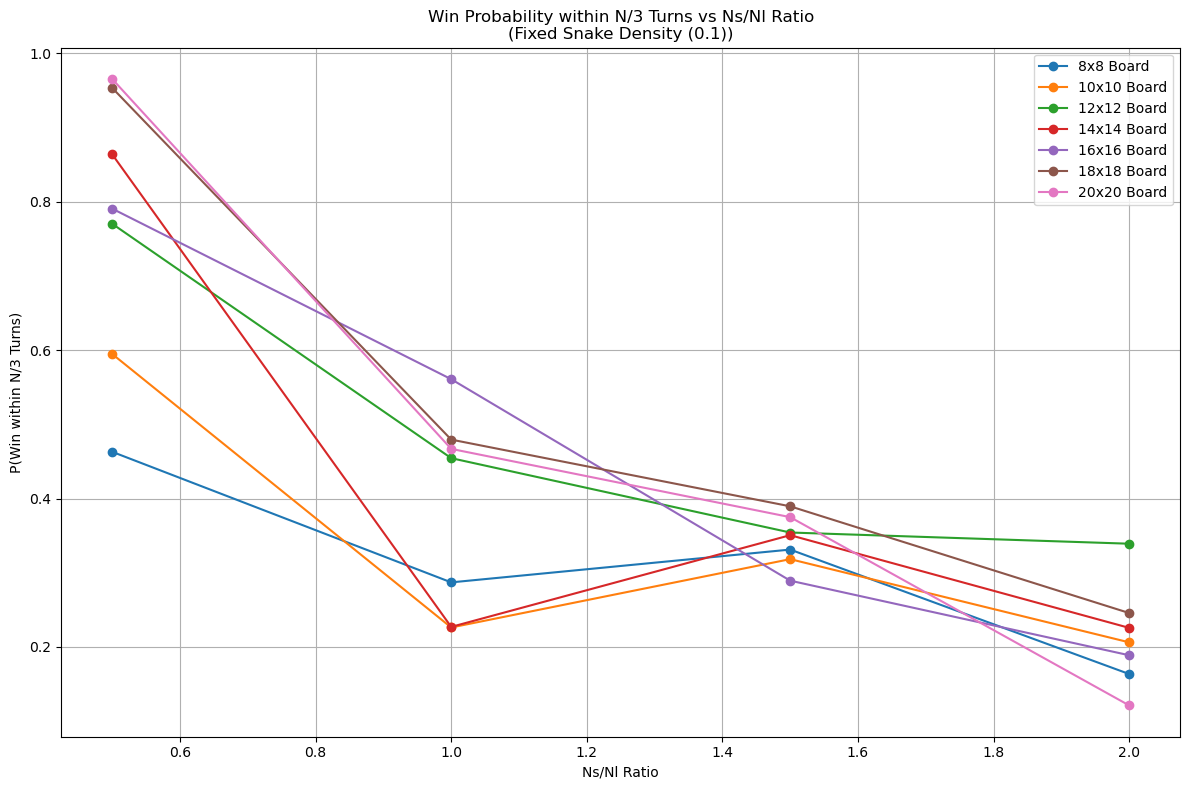

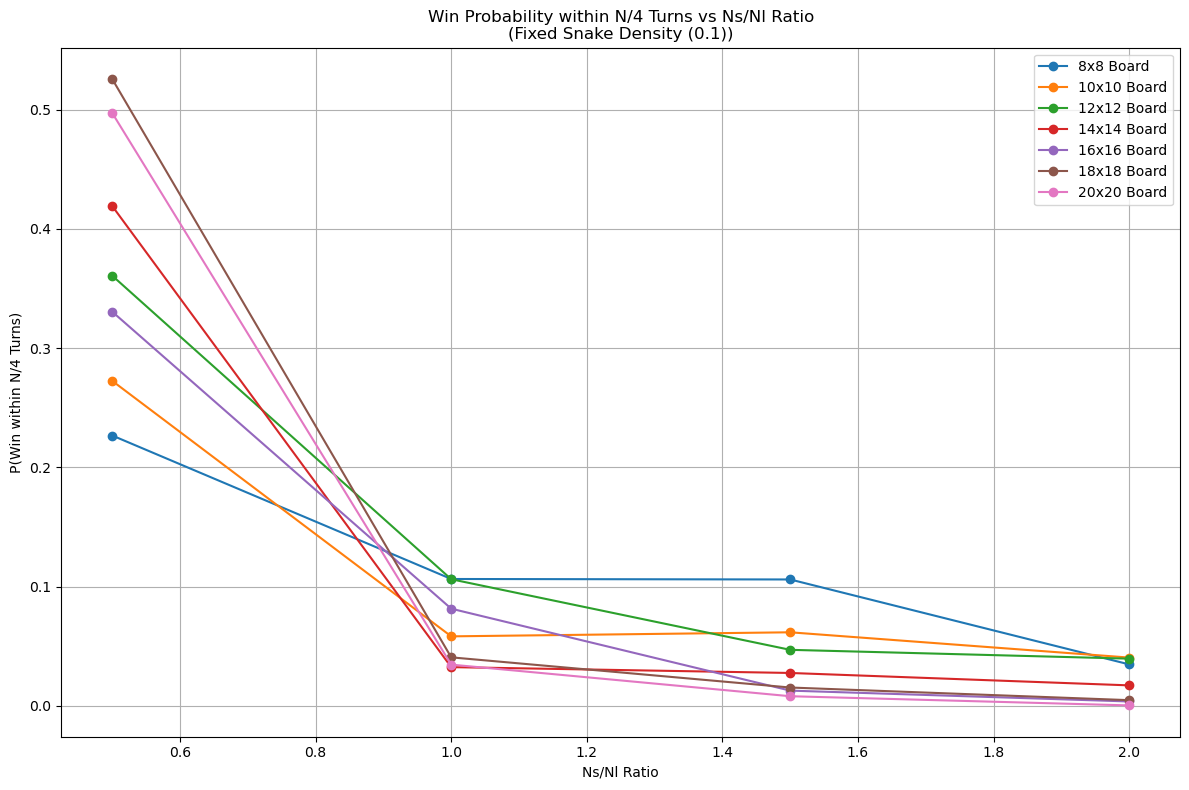

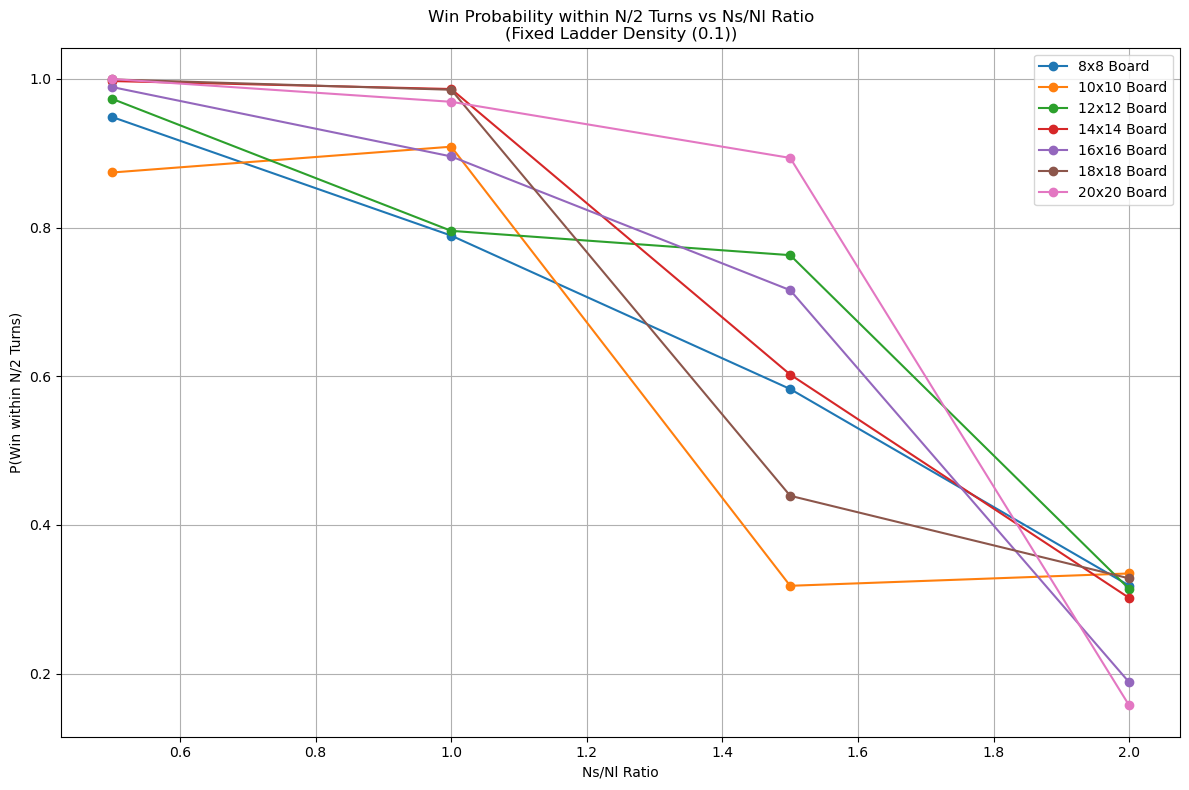

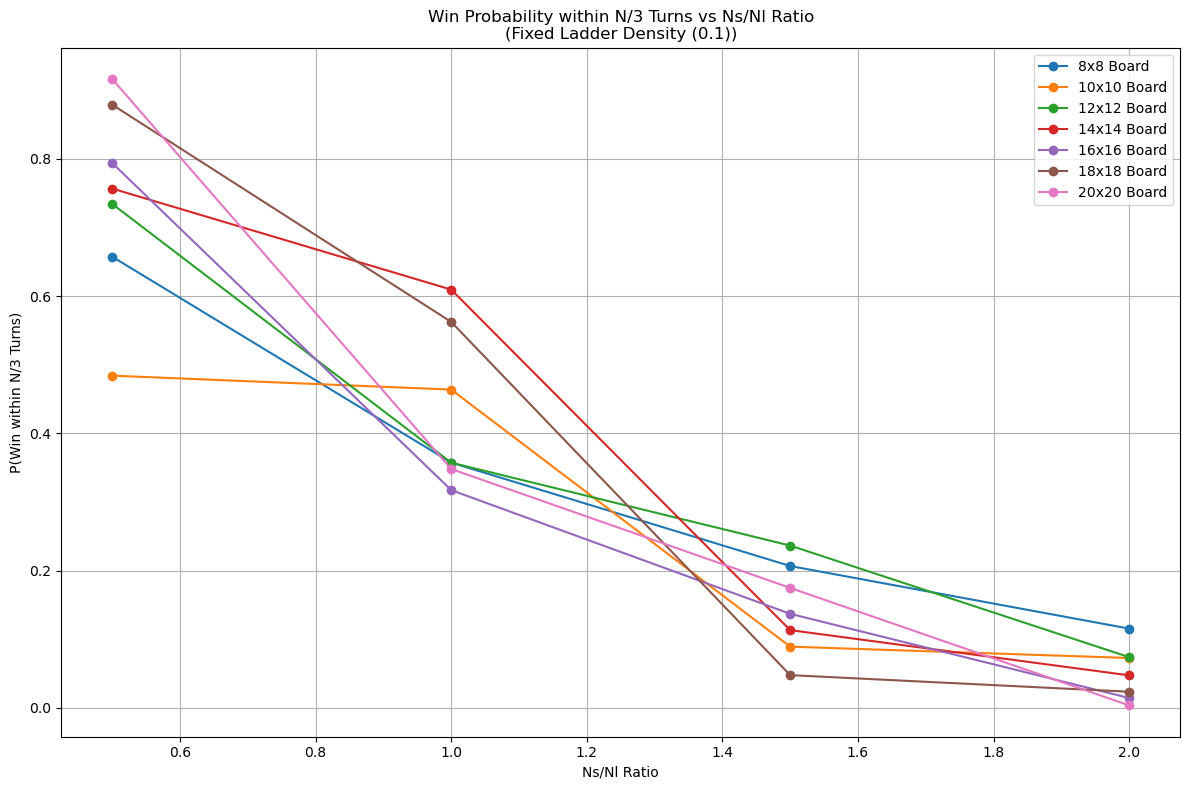

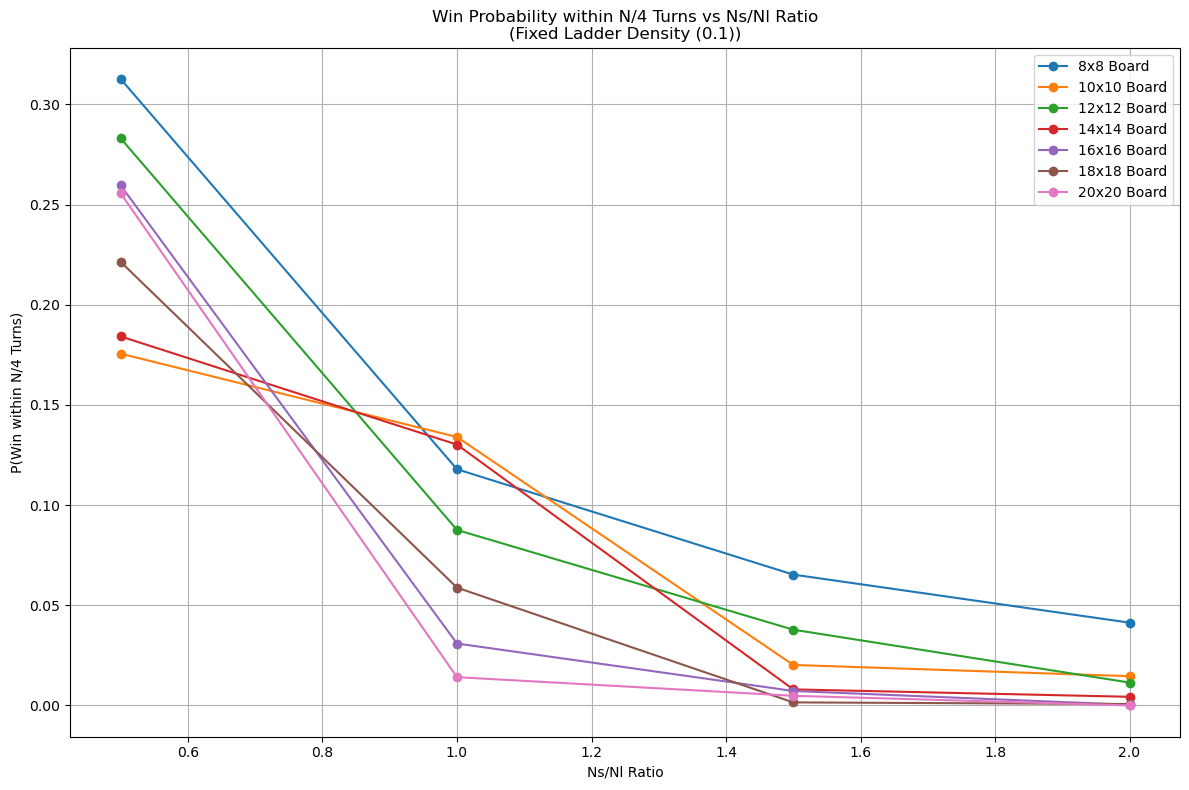

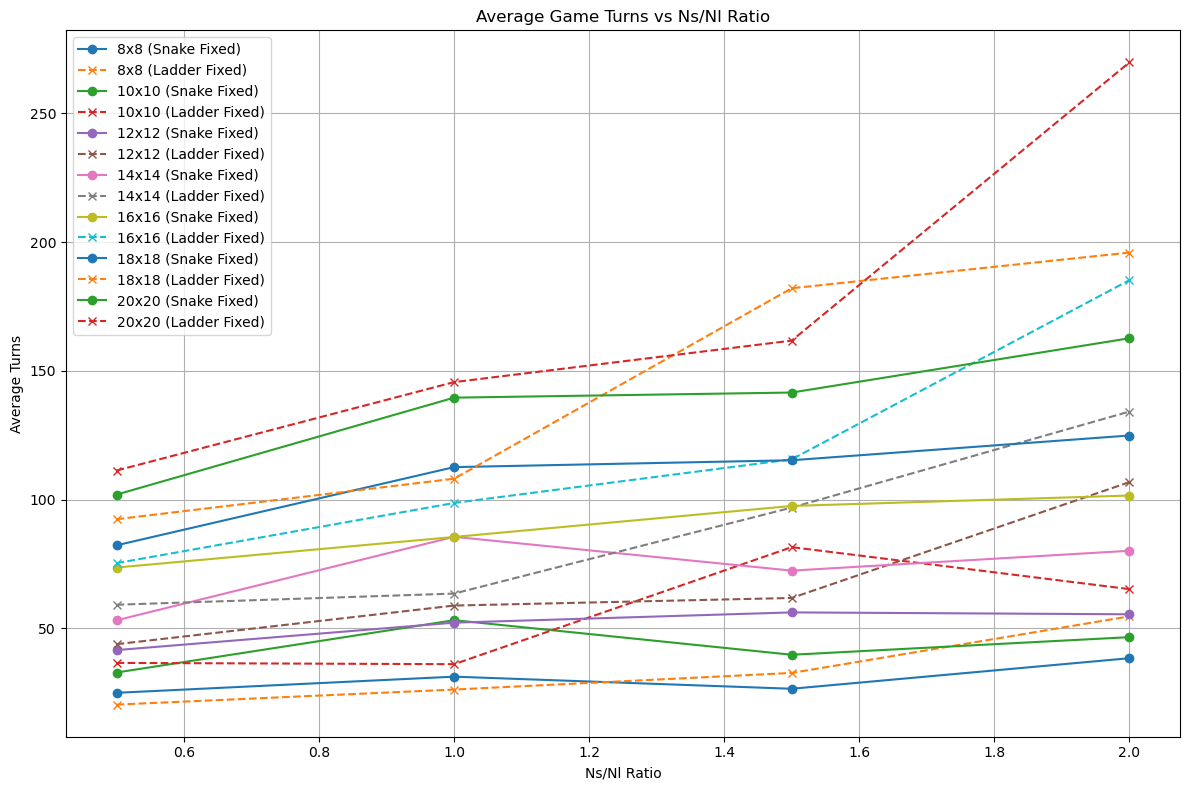


Analysis complete. Results saved to 'snakes_ladders_simulation_results.csv'


In [12]:
def run_analysis():
    """
    Run the complete analysis with both simulation types.
    """
    # Run both types of simulations
    print("\n=== FIXED SNAKE DENSITY SIMULATIONS ===")
    snake_density_results = run_fixed_snake_density_simulations()
    
    print("\n=== FIXED LADDER DENSITY SIMULATIONS ===")
    ladder_density_results = run_fixed_ladder_density_simulations()
    
    
    # Combine results
    all_results = snake_density_results + ladder_density_results
    results_df = pd.DataFrame(all_results)
    
    # Display aggregated results
    print("\n=== AGGREGATED RESULTS ===")
    print(results_df)
    
    # Plot win probability vs ratio for each board size
    for board_size in BOARD_SIZES:
        square_side = int(np.sqrt(board_size))        
        
        # Fixed snake density plots
        plot_win_probability_vs_ratio(results_df, board_size, "all", "fixed_snake_density")
        plt.savefig(f"win_prob_vs_ratio_snake_density_{square_side}x{square_side}.png")
        plt.close()
        
        # Fixed ladder density plots
        plot_win_probability_vs_ratio(results_df, board_size, "all", "fixed_ladder_density")
        plt.savefig(f"win_prob_vs_ratio_ladder_density_{square_side}x{square_side}.png")
        plt.close()
    
    # Plot combined graphs for each simulation type
    plot_win_probability_vs_ratio_combined(results_df, "fixed_snake_density")
    plot_win_probability_vs_ratio_combined(results_df, "fixed_ladder_density")
    
    # Plot average turns vs Ns/Nl ratio
    plt.figure(figsize=(12, 8))
    
    for board_size in BOARD_SIZES:
        square_side = int(np.sqrt(board_size))
        snake_df = results_df[(results_df['board_size'] == board_size) & 
                              (results_df['simulation_type'] == "fixed_snake_density")]
        
        plt.plot(snake_df['ns_nl_ratio'], snake_df['average_turns'], 
                 marker='o', linestyle='-', label=f'{square_side}x{square_side} (Snake Fixed)')
        
        ladder_df = results_df[(results_df['board_size'] == board_size) & 
                               (results_df['simulation_type'] == "fixed_ladder_density")]
        
        plt.plot(ladder_df['ns_nl_ratio'], ladder_df['average_turns'], 
                 marker='x', linestyle='--', label=f'{square_side}x{square_side} (Ladder Fixed)')
    
    plt.xlabel("Ns/Nl Ratio")
    plt.ylabel("Average Turns")
    plt.title("Average Game Turns vs Ns/Nl Ratio")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return results_df


if __name__ == "__main__":
    results_df = run_analysis()
    
    # Save results to CSV for further analysis if needed
    results_df.to_csv("snakes_ladders_simulation_results.csv", index=False)
    
    print("\nAnalysis complete. Results saved to 'snakes_ladders_simulation_results.csv'")